<a id='introduction'></a>
# <p style="padding:15px;background-color:#fff798;margin:10px 0;color:#435672;font-family:'Arial',sans-serif;text-align:center;border-radius:15px 50px;overflow:hidden;font-weight:600">🇪🇺🏛️ European Citizens' Initiatives: After the Signatures</p>

<div align="center">
  <img src="./images/european_commission_logo.svg" alt="EU Commission Logo" height="200" style="display:inline-block; margin:10px;">
  <img src="./images/eci_participation_campaign.jpg" alt="ECI Material" height="200" style="display:inline-block; margin:10px;">
</div>

<p style="text-align:center;">
  <i>Source: European Citizens' Initiative | European Commission (CC BY 4.0)</i>
</p>

In [9]:
# ------------------------------------------------------------------------------
# Standard Library Imports
# ------------------------------------------------------------------------------
import ast
from contextlib import contextmanager
from datetime import datetime, timedelta
import json
from pathlib import Path
import re
import textwrap
from typing import Any, Union, Dict, List, Optional, Tuple
import warnings

# ------------------------------------------------------------------------------
# Data Science & Statistics
# ------------------------------------------------------------------------------
from dateutil import parser
import numpy as np
import pandas as pd
from scipy import stats

# ------------------------------------------------------------------------------
# Visualization
# ------------------------------------------------------------------------------
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

# ------------------------------------------------------------------------------
# Jupyter / Environment (already in the environment)
# ------------------------------------------------------------------------------
from IPython.display import display, HTML

# ------------------------------------------------------------------------------
# Configuration
# ------------------------------------------------------------------------------
warnings.filterwarnings('ignore') # Suppress warnings

# Set defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# # ------------------------------------------------------------------------------
# # Dev data
# # ------------------------------------------------------------------------------

# # Load main datasets
# # Load the dataset
# data_folder = "../data/2025-09-18_16-33-57"

# df_initiatives = pd.read_csv(f'{data_folder}/eci_initiatives_2025-12-15_19-12-45.csv')
# df_responses = pd.read_csv(f'{data_folder}/eci_merger_responses_and_followup_2026-01-13_13-52-31.csv')

# ------------------------------------------------------------------------------
# Searching for most recent CSVs in the `ECI_initiatives/data/...`
# ------------------------------------------------------------------------------


def find_latest_timestamp_folder(base_path: Path) -> Path:
    """Find the most recent timestamped folder in the data directory."""
    timestamp_folders = [d for d in base_path.iterdir() if d.is_dir() and d.name.startswith('20')]
    
    if not timestamp_folders:
        raise FileNotFoundError(f"No timestamped folders found in {base_path.resolve()}")
    
    return max(timestamp_folders, key=lambda x: x.name)



def find_latest_csv(folder: Path, prefix: str) -> Path:
    """Find the latest CSV file with the given prefix in the folder."""
    files = list(folder.glob(f"{prefix}*.csv"))
    if not files:
        raise FileNotFoundError(f"No file starting with '{prefix}' found in {folder.name}")
    return max(files, key=lambda x: x.name)



def load_latest_eci_data(root_path: Path, data_directory: str = "data") -> Tuple[pd.DataFrame, pd.DataFrame, Path]:
    """
    Load the most recent ECI datasets from the data directory.
    
    Returns:
        Tuple of (df_initiatives, df_responses, latest_folder_path)
    """
    base_data_path = root_path / data_directory
    
    # Find latest timestamped folder
    latest_folder = find_latest_timestamp_folder(base_data_path)
    
    # Locate CSV files
    path_initiatives = find_latest_csv(latest_folder, "eci_initiatives_")
    path_responses = find_latest_csv(latest_folder, "eci_merger_responses_and_followup_")
    
    # Load dataframes
    df_initiatives = pd.read_csv(path_initiatives)
    df_responses = pd.read_csv(path_responses)
    
    return df_initiatives, df_responses, latest_folder



# Execute data loading
root_path = Path("../../")
data_directory = "data"


try:
    df_initiatives, df_responses, data_folder = load_latest_eci_data(root_path, data_directory)
    
    
except Exception as e:
    print(f"❌ Error locating or loading data: {e}")
    raise

# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# Introduction: ECI Analysis Overview
# ------------------------------------------------------------------------------

from IPython.display import Markdown as md
import pandas as pd
import re

# Create a copy for intro analysis transformations
df_initiatives_intro = df_initiatives.copy()

# Parse numeric signature count from signatures_collected
def parse_signatures(sig_str):
    if pd.isna(sig_str):
        return 0
    # Extract numeric value, removing commas
    match = re.search(r'[\d,]+', str(sig_str))
    if match:
        return int(match.group().replace(',', ''))
    return 0

# Parse threshold count from signatures_threshold_met
def parse_threshold(threshold_str):
    if pd.isna(threshold_str):
        return 0
    try:
        return float(threshold_str)
    except:
        return 0

# Extract registration year from timeline_registered
def parse_year(date_str):
    if pd.isna(date_str):
        return None
    # Extract year from DD/MM/YYYY format
    match = re.search(r'\d{4}', str(date_str))
    if match:
        return int(match.group())
    return None

# Create derived columns on the copy
df_initiatives_intro['signatures_numeric'] = df_initiatives_intro['signatures_collected'].apply(parse_signatures)
df_initiatives_intro['signatures_threshold_met_numeric'] = df_initiatives_intro['signatures_threshold_met'].apply(parse_threshold)
df_initiatives_intro['registration_year'] = df_initiatives_intro['timeline_registered'].apply(parse_year)

# Calculate the derived boolean columns
df_initiatives_intro['reached_signatures'] = df_initiatives_intro['signatures_numeric'] >= 1_000_000
df_initiatives_intro['met_country_threshold'] = df_initiatives_intro['signatures_threshold_met_numeric'] >= 7

# Filter for ECIs that met both signature requirements
ecis_met_requirements = df_initiatives_intro[
    (df_initiatives_intro['reached_signatures'] == True) & 
    (df_initiatives_intro['met_country_threshold'] == True)
]

# Calculate dynamic values
min_year = int(ecis_met_requirements['registration_year'].min())
max_year = int(df_initiatives_intro['registration_year'].max())
met_requirements_count = len(ecis_met_requirements)

font_size = 14

# Render markdown with dynamic values
md(f"""
<span style="font-size: {font_size}px;">
Examines Commission responses to <a href="https://citizens-initiative-forum.europa.eu/practical-guidance/european-citizens-initiative-basics_en">European Citizens' Initiative proposals</a> that successfully collected enough signatures between {min_year} and {max_year}. Once an ECI collects 1 million signatures from at least 7 member states, the Commission must respond within 6 months, explaining whether it will propose legislation. This dataset covers {met_requirements_count} ECIs that met both signature requirements (1M+ signatures and 7-country thresholds) — tracking Commission response types, implementation timelines, parliamentary engagement, and follow-up actions.<br>


This study focuses exclusively on what happens <strong>after</strong> ECIs meet signature requirements, building on the previous <a href="https://github.com/Luk-kar/eu-citizens-initiatives-tracker/blob/main/ECI_initiatives/exploratory_data_analysis/initiatives_campaigns/eci_analysis_signatures.ipynb"><strong>🇪🇺✍️ European Citizens' Initiatives: Signature Collection</strong></a> which examined all {len(df_initiatives)} registered ECIs. It does not cover the registration approval process—which proposed ECIs were refused registration or how to prepare a successful application — <a href="https://citizens-initiative.europa.eu/how-it-works_en">more about this here</a>. However, collecting enough signatures doesn't guarantee legislative action, a reality sometimes called the <a href="https://thegoodlobby.eu/when-failure-succeeds-and-success-fails-a-reality-check-on-the-european-citizens-initiative/">"successful but failed" paradox</a>.


Success here is measured by Commission legislative outcome (as the tool suggests itself) like (Law Active, Law Promised, Rejected, etc.) and implementation status—not by whether proposals were substantively "correct" or how organizers themselves interpret their outcomes.


The data was <a href="https://github.com/Luk-kar/eu-citizens-initiatives-tracker">scraped</a> directly from the <a href="https://citizens-initiative.europa.eu/find-initiative_en">initiatives site</a>.


NOTE:<br>
> For a quick overview of how EU laws are passed and what each institution actually does, check out this <a href="https://www.youtube.com/watch?v=cotxhOkux18">10-minute explanation</a>.
</span>
""")


<span style="font-size: 14px;">
Examines Commission responses to <a href="https://citizens-initiative-forum.europa.eu/practical-guidance/european-citizens-initiative-basics_en">European Citizens' Initiative proposals</a> that successfully collected enough signatures between 2012 and 2026. Once an ECI collects 1 million signatures from at least 7 member states, the Commission must respond within 6 months, explaining whether it will propose legislation. This dataset covers 16 ECIs that met both signature requirements (1M+ signatures and 7-country thresholds) — tracking Commission response types, implementation timelines, parliamentary engagement, and follow-up actions.<br>


This study focuses exclusively on what happens <strong>after</strong> ECIs meet signature requirements, building on the previous <a href="https://github.com/Luk-kar/eu-citizens-initiatives-tracker/blob/main/ECI_initiatives/exploratory_data_analysis/initiatives_campaigns/eci_analysis_signatures.ipynb"><strong>🇪🇺✍️ European Citizens' Initiatives: Signature Collection</strong></a> which examined all 126 registered ECIs. It does not cover the registration approval process—which proposed ECIs were refused registration or how to prepare a successful application — <a href="https://citizens-initiative.europa.eu/how-it-works_en">more about this here</a>. However, collecting enough signatures doesn't guarantee legislative action, a reality sometimes called the <a href="https://thegoodlobby.eu/when-failure-succeeds-and-success-fails-a-reality-check-on-the-european-citizens-initiative/">"successful but failed" paradox</a>.


Success here is measured by Commission legislative outcome (as the tool suggests itself) like (Law Active, Law Promised, Rejected, etc.) and implementation status—not by whether proposals were substantively "correct" or how organizers themselves interpret their outcomes.


The data was <a href="https://github.com/Luk-kar/eu-citizens-initiatives-tracker">scraped</a> directly from the <a href="https://citizens-initiative.europa.eu/find-initiative_en">initiatives site</a>.


NOTE:<br>
> For a quick overview of how EU laws are passed and what each institution actually does, check out this <a href="https://www.youtube.com/watch?v=cotxhOkux18">10-minute explanation</a>.
</span>


<a id='table-of-contents'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">🧭 Table of content</p>

[🌟 **Introduction**](#introduction)

[❓ **Questions to Ask:**](#question-1)
- [1. What are the outcomes of ECIs?](#question-1)
- [2. How long does the ECI process take?](#question-2)
- [3. How do ECIs progress through EU institutions?](#question-3)
- [4. How are ECIs funded?](#question-4)
- [5. What does a successful ECI team look like?](#question-5)
- [6. What kind of legislation can you find?](#question-6)
- [7. What are official hearings and meetings with policy-makers?](#question-7)
- [8. Are other examples of actions besides the legislative ones?](#question-8)
- [9. How does the Commission set a deadline for itself?](#question-9)
- [10. What is the role of the Court of Justice in ECIs?](#question-10)
- [11. Key Findings](#question-11)

[**✉️ Contact**](#contact)

<a id='setup'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">⚙️ Setup: Import Libraries and Load Data</p>

In [10]:
# ------------------------------------------------------------------------------
# Code moved to the first code block, due to dynamic intro values calculations
# ------------------------------------------------------------------------------

# Print loading information
base_data_path = root_path / data_directory
print(f"✓ Base Data Path: {base_data_path.resolve()}")
print(f"✓ Target Data Directory: {data_folder.name}")
print(f"✓ Loaded Initiatives: {(data_folder / f'eci_initiatives_{data_folder.name}.csv').name}")
print(f"✓ Loaded Responses:   {(data_folder / f'eci_merger_responses_and_followup_{data_folder.name}.csv').name}")

✓ Base Data Path: /home/karol/Documents/Programming/Data_Engineering/airflow/ECI_initiatives/data
✓ Target Data Directory: 2026-02-06_16-11-19
✓ Loaded Initiatives: eci_initiatives_2026-02-06_16-11-19.csv
✓ Loaded Responses:   eci_merger_responses_and_followup_2026-02-06_16-11-19.csv


In [11]:
# ------------------------------------------------------------------------------
# Code moved to the first code block, due to dynamic intro values calculations
# ------------------------------------------------------------------------------

print(f"✓ Initiatives file: {df_initiatives.shape[0]} ECIs")
print(f"✓ Merger file: {df_responses.shape[0]} Commission responses")
print(f"\nColumns: {len(df_initiatives.columns)} initiative columns")
print(f"        {len(df_responses.columns)} response columns")

✓ Initiatives file: 126 ECIs
✓ Merger file: 11 Commission responses

Columns: 26 initiative columns
        36 response columns


[↑ Table of Contents ↑](#table-of-contents)

<a id='data-cleaning'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">🧹 Data Cleaning and Feature Engineering</p>

In [12]:
# ==============================================================================
# COMMON UTILITY FUNCTIONS (Reusable across entire notebook)
# ==============================================================================

# ------------------------------------------------------------------------------
# Numeric Parsing Functions
# ------------------------------------------------------------------------------

def parse_numeric_with_separators(value):
    """Convert numeric strings with commas/separators to float."""
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        return float(value.replace(',', ''))
    return float(value)

def parse_numeric_or_zero(value):
    """Convert numeric strings to float, return 0 for missing values."""
    if pd.isna(value):
        return 0
    if isinstance(value, str):
        return float(value.replace(',', ''))
    return float(value)

# ------------------------------------------------------------------------------
# Date Parsing Functions
# ------------------------------------------------------------------------------

def parse_date(date_str):
    """Convert date string to datetime object (supports DD/MM/YYYY and ISO)."""
    if pd.isna(date_str) or date_str == '':
        return pd.NaT
    try:
        return pd.to_datetime(date_str, format='%d/%m/%Y')
    except:
        try:
            return pd.to_datetime(date_str, errors='coerce')
        except:
            return pd.NaT

def parse_dates_in_dataframe(df, date_columns):
    """Parse multiple date columns in a dataframe."""
    df = df.copy()
    for col in date_columns:
        if col in df.columns:
            df[col] = df[col].apply(parse_date)
    return df

def format_dates_for_display(df, date_columns):
    """
    Convert datetime columns to formatted strings for display.
    Creates new columns with '_formatted' suffix.
    """
    df = df.copy()
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            df[f'{col}_formatted'] = df[col].dt.strftime('%d %b %Y').fillna('Unknown')
    return df

# ------------------------------------------------------------------------------
# Duration Calculation Functions
# ------------------------------------------------------------------------------

def format_duration(start_date, end_date):
    """Format duration between two dates as 'X years Y months Z days'."""
    if pd.isna(start_date) or pd.isna(end_date):
        return 'Unknown'
    
    delta = (end_date - start_date).days
    
    if delta < 0:
        return 'Invalid date range'
    
    years = delta // 365
    remaining = delta % 365
    months = remaining // 30
    days = remaining % 30
    
    parts = []
    if years > 0:
        parts.append(f"{years} year{'s' if years > 1 else ''}")
    if months > 0:
        parts.append(f"{months} month{'s' if months > 1 else ''}")
    if days > 0 or len(parts) == 0:
        parts.append(f"{days} day{'s' if days != 1 else ''}")
    
    return ' '.join(parts)

# ------------------------------------------------------------------------------
# Text Formatting Functions
# ------------------------------------------------------------------------------

def format_objective(objective, words_per_line=11):
    """Format objective text with line breaks and bullet preservation for hover tooltips."""
    if pd.isna(objective):
        return "No objective provided"
    
    obj_str = str(objective)
    bullet_sections = obj_str.split('•')
    formatted_sections = []
    
    for i, section in enumerate(bullet_sections):
        section = section.strip()
        if not section:
            continue
            
        if i > 0:
            section = '• ' + section
        
        words = section.split()
        lines = [' '.join(words[j:j+words_per_line]) for j in range(0, len(words), words_per_line)]
        formatted_sections.append('<br>'.join(lines))
    
    return '<br>'.join(formatted_sections)

# ------------------------------------------------------------------------------
# JSON Parsing Functions
# ------------------------------------------------------------------------------

def safe_json_load(x):
    """Safely parse JSON strings."""
    try:
        return json.loads(x) if pd.notna(x) else None
    except:
        return None

# ------------------------------------------------------------------------------
# Updating `status` for `laws_actions` from historical to current one
# ------------------------------------------------------------------------------

def extract_effective_date_text(text):
    """
    Extracts the effective date and its corresponding status label from text.
    Returns: (datetime_object, status_string)
             status_string is either 'law_active' or 'in_vacatio_legis'
    """
    if not isinstance(text, str):
        return None, None
    
    # Clean up text for easier parsing
    text_clean = text.replace('\xa0', ' ').strip()
    
    # 1. Regex definitions
    
    # Force: "entered into force on 18 August 2024"
    force_pattern = r"(?:enter(?:ed)?|coming|came).{0,10}(?:into force).{0,10}(?:on|in)\s+((?:\d{1,2}\s+)?[A-Za-z]{3,10}\s+\d{4}|\d{4}-\d{2}-\d{2})"
    
    # Apply: "applies from...", "applicable on..."
    apply_pattern = r"(?<!will )(?:appl(?:y|ies|ied|icable|ication)|transpos(?:ed|ition)|edition).{0,20}(?:on|from|in)\s+((?:\d{1,2}\s+)?[A-Za-z]{3,10}\s+\d{4}|\d{4}-\d{2}-\d{2})"
    
    # Special Case: "became applicable immediately"
    immediate_pattern = r"(?:bec(?:ome|ame|omes)|is|are)\s+applicable\s+immediately"
    
    def parse_date(d_str):
        try:
            # Clean up "on " or "in " prefixes if captured
            d_str = re.sub(r'^(on|in)\s+', '', d_str.strip(), flags=re.IGNORECASE)
            return parser.parse(d_str)
        except:
            return None

    valid_dates = []

    # 2. Check for "Applicable Immediately" Case
    # If explicitly stated as immediately applicable, the Force date IS 'law_active'
    if re.search(immediate_pattern, text_clean, re.IGNORECASE):
        force_match = re.search(force_pattern, text_clean, re.IGNORECASE)
        if force_match:
            dt = parse_date(force_match.group(1))
            if dt:
                return dt, 'law_active'

    # 3. Standard Search
    
    # Find Application Dates -> Map to 'law_active'
    for match in re.finditer(apply_pattern, text_clean, re.IGNORECASE):
        dt = parse_date(match.group(1))
        if dt:
            valid_dates.append({'date': dt, 'status': 'law_active'})

    # Find Entry into Force Dates -> Map to 'in_vacatio_legis'
    for match in re.finditer(force_pattern, text_clean, re.IGNORECASE):
        dt = parse_date(match.group(1))
        if dt:
            valid_dates.append({'date': dt, 'status': 'in_vacatio_legis'})

    if not valid_dates:
        return None, None
        
    # Priority: law_active > in_vacatio_legis
    active_dates = [d for d in valid_dates if d['status'] == 'law_active']
    if active_dates:
        active_dates.sort(key=lambda x: x['date'], reverse=True)
        return active_dates[0]['date'], 'law_active'
    
    # Fallback to force date (in_vacatio_legis)
    valid_dates.sort(key=lambda x: x['date'], reverse=True)
    return valid_dates[0]['date'], 'in_vacatio_legis'

def update_law_status(json_str, current_date_str="2026-01-13"):
    if pd.isna(json_str) or json_str == "":
        return json_str
    
    try:
        actions = json.loads(json_str)
    except:
        return json_str
        
    current_date = datetime.strptime(current_date_str, "%Y-%m-%d")
    updated_actions = []
    
    for action in actions:
        desc = action.get('description', '')
        
        # Get date AND the direct status label
        text_date, status_label = extract_effective_date_text(desc)
        
        if text_date:
            # Check if date is in the past relative to analysis date
            if text_date <= current_date:
                action['status'] = status_label
            else:
                # If date is future, it's always in_vacatio_legis regardless of type
                action['status'] = 'in_vacatio_legis'
            
            # FIX: Update the date field to reflect the new effective date found
            action['date'] = text_date.strftime('%Y-%m-%d')
                
        updated_actions.append(action)
        
    return json.dumps(updated_actions)

# ------------------------------------------------------------------------------
# Get ECIs with the `status` for `waiting for response``
# ------------------------------------------------------------------------------

def get_waiting_for_response_ecis(df_initiatives, df_responses):
    """
    Identifies ECIs that successfully met collection thresholds but have not 
    yet received a Commission response.
    
    Returns dict with keys: 'registration_numbers', 'count', 'dataframe'
    """
    
    def has_collection_closed(timeline_json):
        if pd.isna(timeline_json):
            return False
        try:
            timeline = json.loads(timeline_json) if isinstance(timeline_json, str) else timeline_json

            if isinstance(timeline, list):
                return any("Collection closed" in str(event.get("step", "")) for event in timeline)

        except:
            return False
            
        return False
    
    successful_closed = df_initiatives[
        (df_initiatives['success_collection'] == True) &
        (df_initiatives['timeline'].apply(has_collection_closed))
    ]['registration_number'].tolist()
    
    responded_ecis = df_responses['registration_number'].tolist()
    waiting_ecis = [eci for eci in successful_closed if eci not in responded_ecis]
    
    waiting_df = df_initiatives[
        df_initiatives['registration_number'].isin(waiting_ecis)
    ].copy()
    
    return {
        'registration_numbers': waiting_ecis,
        'count': len(waiting_ecis),
        'dataframe': waiting_df
    }

# ==============================================================================
# DATA CLEANING: Apply to Raw Data
# ==============================================================================

# ------------------------------------------------------------------------------
# Signature Data Parsing
# ------------------------------------------------------------------------------

df_initiatives['signatures_numeric'] = df_initiatives['signatures_collected'].apply(parse_numeric_with_separators)
df_initiatives['signatures_threshold_met_numeric'] = pd.to_numeric(
    df_initiatives['signatures_threshold_met'], errors='coerce'
)

# ------------------------------------------------------------------------------
# Funding Data Parsing
# ------------------------------------------------------------------------------

df_initiatives['funding_numeric'] = df_initiatives['funding_total'].apply(parse_numeric_or_zero)

# ------------------------------------------------------------------------------
# Date Parsing
# ------------------------------------------------------------------------------

date_cols = ['timeline_registered', 'timeline_collection_start_date', 
             'timeline_collection_closed', 'timeline_verification_start',
             'timeline_verification_end', 'timeline_response_commission_date']

df_initiatives = parse_dates_in_dataframe(df_initiatives, date_cols)

# Extract year from registration
df_initiatives['registration_year'] = df_initiatives['timeline_registered'].dt.year

# ------------------------------------------------------------------------------
# Duration Calculations (Basic)
# ------------------------------------------------------------------------------

df_initiatives['collection_days'] = (
    df_initiatives['timeline_collection_closed'] - 
    df_initiatives['timeline_collection_start_date']
).dt.days

df_initiatives['verification_days'] = (
    df_initiatives['timeline_verification_end'] - 
    df_initiatives['timeline_verification_start']
).dt.days

df_initiatives['time_to_response_days'] = (
    df_initiatives['timeline_response_commission_date'] - 
    df_initiatives['timeline_registered']
).dt.days

# ------------------------------------------------------------------------------
# JSON Fields Parsing
# ------------------------------------------------------------------------------

df_initiatives['organizer_data'] = df_initiatives['organizer_representative'].apply(safe_json_load)

# ==============================================================================
# FEATURE ENGINEERING: Create Analysis Features
# ==============================================================================

# ------------------------------------------------------------------------------
# Success Metrics (Core Analysis Features)
# ------------------------------------------------------------------------------

df_initiatives['reached_signatures'] = df_initiatives['signatures_numeric'] >= 1000000
df_initiatives['met_country_threshold'] = df_initiatives['signatures_threshold_met_numeric'] >= 7
df_initiatives['success_collection'] = (
    df_initiatives['reached_signatures'] & 
    df_initiatives['met_country_threshold']
)

success_outcomes = ['Commission Response', 'Answered initiative', 'Valid initiative']
df_initiatives['collection_accepted'] = df_initiatives['final_outcome'].isin(success_outcomes).astype(int)

# ------------------------------------------------------------------------------
# Signature Volume Categories
# ------------------------------------------------------------------------------

df_initiatives['signature_category'] = pd.cut(
    df_initiatives['signatures_numeric'],
    bins=[0, 100000, 500000, 1000000, float('inf')],
    labels=['<100k', '100k-500k', '500k-1M', '>1M'],
    include_lowest=True
)

# ------------------------------------------------------------------------------
# Renaming 'Law Approved' to 'Law Passed' for better readability
# ------------------------------------------------------------------------------

df_responses['final_outcome_status'] = df_responses['final_outcome_status'].replace('Law Approved', 'Law Passed')

# ------------------------------------------------------------------------------
# Updating `laws actions` to current status
# ------------------------------------------------------------------------------

df_responses['laws_actions'] = df_responses['laws_actions'].apply(update_law_status)

# ------------------------------------------------------------------------------
#  `laws_actions` - Fix False Positive Status Values
# ------------------------------------------------------------------------------
# Corrects specific cases where "adopted" incorrectly refers to a policy 
# document (Vision for Agriculture and Food) rather than the legislation itself.
# These entries describe future legislative proposals ("will present proposals")
# and should be marked as "planned" instead of "adopted".
# ------------------------------------------------------------------------------

def fix_vision_status(json_str):
    """
    Corrects the status of specific 'Vision for Agriculture' entries where
    'adopted' refers to the Vision document, not the legislation.
    """
    if pd.isna(json_str) or json_str == "":
        return json_str
    
    try:
        actions = json.loads(json_str)
    except (json.JSONDecodeError, TypeError):
        return json_str
        
    modified = False
    # Unique substring identifying the specific false positive cases
    target_phrase = "Vision for Agriculture and Food adopted on 19 February 2025"
    
    for action in actions:
        description = action['description']
        status = action['status']
        
        # Check if this is the specific false positive case
        if target_phrase in description and status == 'adopted':
            # "will present proposals" implies the legislation is in planning stage
            action['status'] = 'planned'
            modified = True
                
    if modified:
        return json.dumps(actions)
    return json_str

df_responses['laws_actions'] = df_responses['laws_actions'].apply(fix_vision_status)

# ------------------------------------------------------------------------------
# Updating `final status` based on the `laws actions`
# ------------------------------------------------------------------------------

# Define Hierarchy Ranks (Higher number = "more advanced" status)
OUTCOME_HIERARCHY = {
    'Law Active': 50,
    'Law Passed': 40,
    'Law Proposed': 30,
    'Law Promised': 20,
    'Action Plan Created': 20, # Equivalent to Promised
    'Being Studied': 10,
    'Rejected - Already Covered': 0,
    'Rejected - Alternative Actions': 0,
    'Rejected': 0,
    'Withdrawn': 0
}

# Map CSV 'status' values to the Outcome Hierarchy
# Tuple format: (New Label, Rank)
ACTION_STATUS_MAPPING = {
    'law_active': ('Law Active', 50),
    'in_vacatio_legis': ('Law Passed', 40),
    'adopted': ('Law Passed', 40), # Maps 'adopted' acts to Approved
    'proposed': ('Law Promised', 20), # Maps 'proposed'/consultations to Promised
    'planned': ('Law Promised', 20),
    'withdrawn': ('Withdrawn', 0)
}

def update_outcome_status_upwards(row):
    """
    Updates final_outcome_status only if the derived status from laws_actions
    is strictly higher in the hierarchy than the current status.
    """

    current_status = row['final_outcome_status']
    current_rank = OUTCOME_HIERARCHY.get(current_status, -1)
    
    actions_json = row['laws_actions']
    
    # Parse JSON
    if pd.isna(actions_json) or actions_json == '':
        return current_status
    try:
        actions = json.loads(actions_json)
    except:
        return current_status
        
    if not actions:
        return current_status

    # Find the highest rank achieved by any action in the list
    max_action_rank = -1
    best_new_status = current_status
    
    for action in actions:
        act_status = action['status'].lower()
        
        if act_status in ACTION_STATUS_MAPPING:
            candidate_status, candidate_rank = ACTION_STATUS_MAPPING[act_status]
            
            # Keep the highest ranked action
            if candidate_rank > max_action_rank:
                max_action_rank = candidate_rank
                best_new_status = candidate_status
    
    # Update only if the found action status is higher than the current outcome
    if max_action_rank > current_rank:
        return best_new_status
    
    return current_status

# Apply the function to the merged dataframe
df_responses['final_outcome_status'] = df_responses.apply(update_outcome_status_upwards, axis=1)

# ==============================================================================
# CREATE MASTER MERGED DATAFRAME (Once, used by all plots)
# ==============================================================================

# Merge df_responses with df_initiatives to create comprehensive dataset
df_responses_enriched = df_responses.merge(
    df_initiatives, 
    on='registration_number', 
    how='left',
    suffixes=('_response', '_initiative')
)


print("✅ Data cleaning complete!")
print(f"   - Initiatives: {len(df_initiatives)} records")
print(f"   - Commission Responses: {len(df_responses)} records")
print(f"   - Merged dataset: {len(df_responses_enriched)} records")
print(f"   - Signatures converted: {df_initiatives['signatures_numeric'].notna().sum()} records")
print(f"   - Successful ECIs: {df_initiatives['success_collection'].sum()} out of {len(df_initiatives)}")

✅ Data cleaning complete!
   - Initiatives: 126 records
   - Commission Responses: 11 records
   - Merged dataset: 11 records
   - Signatures converted: 62 records
   - Successful ECIs: 16 out of 126


[↑ Table of Contents ↑](#table-of-contents)

<a id='question-1'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">1. What are the outcomes of ECIs?</p>

Examines the final outcomes of European Citizens' Initiatives that reached the Commission response stage, categorizing them by the **highest legislative status achieved** to understand what happens after 1 million signatures are collected.<br>

This section looks at whether collecting signatures leads to concrete legal changes, policy commitments, or rejections. A "successful" classification means **some legislative action occurred**—not that the initiative achieved its full vision. Initiatives resulting **only in non-legislative actions** (such as working groups or communications) are **not treated as "success"** in this analysis. The **interpretation of "success" varies significantly**: organizers may view partial implementation as a failure if core demands are unmet, while institutions may view the same outcome as a policy win.<br>

NOTE:<br>
> - The **outcome ranking** (`Law Active`, `Law Passed`, etc.) represents the **highest legislative milestone reached**, not comprehensive success.
> - A status like `Law Active` means **at least one law** related to the ECI became operational, but **doesn't guarantee all ECI objectives were met**.
> - The classification **prioritizes legislative actions** over non-legislative measures (like international negotiations, policy frameworks, or stakeholder consultations).
> - **Partial implementation is common**: The Commission may adopt some ECI demands while rejecting others, leading to outcomes that organizers don't consider successful.

**Example: Ban Glyphosate ECI (2017/000002)**<br>
This initiative had [three objectives](https://citizens-initiative.europa.eu/initiatives/details/2017/000002/ban-glyphosate-and-protect-people-and-environment-toxic-pesticides_en):
1. Ban glyphosate-based herbicides → ❌ **Rejected**: Commission stated "neither scientific nor legal grounds to justify a ban"
2. Ensure transparent, publicly-commissioned studies → ✅ **Success**: [Regulation 2019/1381](https://eur-lex.europa.eu/legal-content/EN/TXT/PDF/?uri=CELEX:32019R1381) entered into force on March 27, 2021, strengthening transparency in EU food safety assessments
3. Set mandatory pesticide reduction targets → 🟡 **Partial**: The Farm to Fork Strategy (May 2020) established binding 50% reduction targets for chemical pesticide use and risk by 2030. However, these remain **policy commitments** rather than legally binding law.

**Organizers' Response**: Despite the passed law, some organizers were [dissatisfied](https://www.pan-europe.info/press-releases/2017/12/commission-rejects-demands-stopglyphosate-citizens%E2%80%99-initiative), stating the Commission *"proposed action that could fulfil one aspect of one of the three demands"* while rejecting the primary objective of banning glyphosate and ignoring mandatory pesticide reduction targets.


### How ECI Outcomes Are Classified

In [13]:
# ==============================================================================
# PIE CHART: Outcome Distribution
# ==============================================================================

# ==============================================================================
# CONSTANTS
# ==============================================================================

MAX_HOVER_ITEMS = 15

# Outcome ranking: higher = better outcome
OUTCOME_RANKING = {
    'Law Active': 5,
    'Law Passed': 4,
    'Law Promised': 3,
    'Action Plan Created': 2,
    'Being Studied': 1,
    'Waiting for Response': 0,
    'Rejected - Alternative Actions': -1,
    'Rejected - Already Covered': -2,
}

# Color scheme: green (good) → yellow (neutral) → red (bad)
OUTCOME_COLORS = {
    'Law Active': 'rgb(60, 163, 113)',
    'Law Passed': 'rgb(102, 187, 106)',
    'Law Promised': 'rgb(156, 204, 101)',
    'Action Plan Created': 'rgb(255, 193, 7)',
    'Being Studied': 'rgb(255, 152, 0)',
    'Rejected - Alternative Actions': 'rgb(244, 67, 54)',
    'Rejected - Already Covered': 'rgb(183, 28, 28)',
    'Waiting for Response': 'rgb(158, 158, 158)',
}

DEFAULT_COLOR = 'rgb(117, 117, 117)'

# ==============================================================================
# HELPER FUNCTIONS
# ==============================================================================

def has_collection_closed(timeline_json):
    """Check if 'Collection closed' appears in timeline."""
    if pd.isna(timeline_json):
        return False
    
    try:
        timeline = json.loads(timeline_json) if isinstance(timeline_json, str) else timeline_json
        if isinstance(timeline, list):
            return any('Collection closed' in str(event.get('step', '')) for event in timeline)
    except (json.JSONDecodeError, AttributeError, TypeError):
        return False
    
    return False


def prepare_eci_list_for_hover(eci_titles, max_items=MAX_HOVER_ITEMS):
    """Prepare ECI title list for hover tooltips with truncation."""
    if not eci_titles:
        return "No ECIs"
    
    if len(eci_titles) <= max_items:
        return '<br>'.join(f"• {title}" for title in eci_titles)
    
    displayed_items = '<br>'.join(f"• {title}" for title in eci_titles[:max_items])
    return f"{displayed_items}<br><i>... (and {len(eci_titles) - max_items} more)</i>"


def get_outcome_color(outcome):
    """Get color for outcome status."""
    return OUTCOME_COLORS.get(outcome, DEFAULT_COLOR)


def prepare_outcome_data(df_responses_enriched, waiting_ecis_data):
    """Prepare aggregated outcome counts with waiting ECIs."""
    # Get outcome counts from responded ECIs
    plot_data = df_responses_enriched[['final_outcome_status', 'title']].copy()
    outcome_counts = plot_data['final_outcome_status'].value_counts().reset_index()
    outcome_counts.columns = ['Outcome', 'Count']
    
    # Add waiting ECIs if any
    waiting_count = waiting_ecis_data['count']
    if waiting_count > 0:
        waiting_row = pd.DataFrame({
            'Outcome': ['Waiting for Response'],
            'Count': [waiting_count]
        })
        outcome_counts = pd.concat([outcome_counts, waiting_row], ignore_index=True)
    
    return outcome_counts, plot_data, waiting_count


def enrich_outcome_data(outcome_counts, plot_data, waiting_ecis_data, total_responses):
    """Add percentages, rankings, colors, and ECI lists to outcome data."""
    total_count = total_responses + waiting_ecis_data['count']
    
    # Add percentage
    outcome_counts['Percentage'] = (outcome_counts['Count'] / total_count * 100).round(1)
    
    # Add ranking and color
    outcome_counts['Rank'] = outcome_counts['Outcome'].map(OUTCOME_RANKING)
    outcome_counts['Color'] = outcome_counts['Outcome'].apply(get_outcome_color)
    
    # Add ECI lists for hover
    eci_lists = []
    for outcome in outcome_counts['Outcome']:
        if outcome == 'Waiting for Response':
            titles = waiting_ecis_data['dataframe']['title'].tolist()
        else:
            titles = plot_data[plot_data['final_outcome_status'] == outcome]['title'].tolist()
        eci_lists.append(prepare_eci_list_for_hover(titles))
    
    outcome_counts['ECI_List'] = eci_lists
    
    # Sort by rank (best outcomes first)
    return outcome_counts.sort_values('Rank', ascending=False)


def create_outcome_pie_chart(outcome_counts, total_responses, waiting_count):
    """Create interactive pie chart for outcome distribution."""
    fig = go.Figure(go.Pie(
        labels=outcome_counts['Outcome'],
        values=outcome_counts['Count'],
        hole=0.1,
        marker=dict(colors=outcome_counts['Color'].tolist()),
        customdata=outcome_counts['ECI_List'],
        hovertemplate=(
            '<b>%{label}</b><br>'
            'Count: %{value}<br>'
            'Percentage: %{percent}<br><br>'
            '<b>ECIs:</b><br>%{customdata}'
            '<extra></extra>'
        ),
        textinfo='percent+label',
        textposition='inside',
        textfont=dict(size=11, color='white', family='Arial Black'),
        sort=False
    ))
    
    fig.update_layout(
        title=f'<b>Commission Response Outcomes ({total_responses} responded, {waiting_count} waiting)</b>',
        height=600,
        showlegend=True,
        legend=dict(
            font=dict(size=12),
            orientation='v',
            yanchor='middle',
            y=0.5,
            xanchor='left',
            x=1.02
        )
    )
    
    return fig


# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

# Get waiting ECIs (those that met thresholds but haven't received a response)
waiting_ecis = get_waiting_for_response_ecis(df_initiatives, df_responses)

# Prepare outcome data
outcome_counts, plot_data, waiting_count = prepare_outcome_data(
    df_responses_enriched, 
    waiting_ecis
)

# Enrich with percentages, rankings, colors, and ECI lists
outcome_counts = enrich_outcome_data(
    outcome_counts, 
    plot_data, 
    waiting_ecis, 
    len(df_responses)
)

# Create and display pie chart
fig = create_outcome_pie_chart(outcome_counts, len(df_responses), waiting_count)
fig.show()

# Display detailed ECI lists
pd.set_option('display.max_colwidth', None)
outcome_counts_display = outcome_counts[['Outcome', 'ECI_List']].copy()
display(HTML(outcome_counts_display.to_html(escape=False, index=False)))

Outcome,ECI_List
Law Active,"• Water and sanitation are a human right! Water is a public good, not a commodity!• Ban glyphosate and protect people and the environment from toxic pesticides• Save bees and farmers ! Towards a bee-friendly agriculture for a healthy environment• Stop Finning – Stop the trade"
Law Passed,• Fur Free Europe
Law Promised,• End the Cage Age
Action Plan Created,• SAVE CRUELTY FREE COSMETICS - COMMIT TO A EUROPE WITHOUT ANIMAL TESTING
Waiting for Response,"• Stop Extremism• Ban on conversion practices in the European Union• My Voice, My Choice: For Safe And Accessible Abortion• Stop Destroying Videogames• Stop Cruelty Stop Slaughter"
Rejected - Alternative Actions,• Stop vivisection
Rejected - Already Covered,• One of us• Minority SafePack – one million signatures for diversity in Europe• Cohesion policy for the equality of the regions and sustainability of the regional cultures


For an ECI organizer, collecting 1 million signatures is just the **"entry ticket"**. The real challenge begins afterward. Here is how the legislative machine processes our demands, illustrated by actual ECI cases from data.

1. **(Law Active, Law Passed)** - Legislative Success:<br>
   The law is adopted. The legislative process is finished. 
   The organizer has secured a tangible legal act.<br>
   Example: ['Right2Water'](https://www.greeneuropeanjournal.eu/the-success-story-of-the-right2water-european-citizens-initiative/) protected public water services from privatization and influenced EU drinking water standards.
   
2. **(Law Promised, Action Plan Created, Being Studied)** - Political Commitment:<br>
   The Commission has promised action or is investigating, but NO legal act exists yet.<br>
   Risky phase: Promises can be delayed (e.g., ['End the Cage Age'](https://animalequality.org.uk/news/2025/03/25/in-2021-the-eu-promised-to-ban-cages-but-years-later-nothing-has-changed/)).
   
3. **(Rejected - All Types)** - Proposal Declined:<br>
   The Commission refuses to propose NEW legislation.<br>
   They may offer non-legislative alternatives (funding, better enforcement of old laws),<br>
   but the core legislative demand is denied.

NOTE:<br>
> - "Law Active" means the law is passed on the EU level; however, each country must still put it into their own legal system. Poland [missed the 2023 deadline](https://notesfrompoland.com/2023/08/30/poland-has-not-implemented-eu-water-quality-directive/) to implement the Drinking Water Directive (linked to Right2Water ECI)

In [14]:
# ==============================================================================
# SCATTER PLOT: Signatures vs Outcome
# ==============================================================================

# =============================================================================
# CONSTANTS
# =============================================================================

# Outcome classification and visual encoding
OUTCOME_RANKING = {
    'Law Active': 5,
    'Law Passed': 4,
    'Law Promised': 3,
    'Action Plan Created': 2,
    'Being Studied': 1,
    'Rejected - Alternative Actions': -1,
    'Rejected - Already Covered': -2,
}

OUTCOME_COLORS = {
    'Law Active': 'rgb(60, 163, 113)',
    'Law Passed': 'rgb(102, 187, 106)',
    'Law Promised': 'rgb(156, 204, 101)',
    'Action Plan Created': 'rgb(255, 193, 7)',
    'Being Studied': 'rgb(255, 152, 0)',
    'Rejected - Alternative Actions': 'rgb(244, 67, 54)',
    'Rejected - Already Covered': 'rgb(183, 28, 28)',
}

# Visual scaling parameters
BUBBLE_SIZE_EXPONENT = 4.3
BUBBLE_MAX_SIZE = 60

# Column name aliases for response date
RESPONSE_DATE_COLUMNS = [
    'official_communication_adoption_date',
    'commission_submission_date'
]

# Date columns to format
DATE_COLUMNS_TO_FORMAT = [
    'timeline_registered',
    'timeline_collection_closed',
    'response_date'
]


# =============================================================================
# DATA PREPARATION FUNCTIONS
# =============================================================================

def extract_response_date(df: pd.DataFrame) -> pd.Series:
    """Extract commission response date from available columns."""
    for col in RESPONSE_DATE_COLUMNS:
        if col in df.columns:
            return pd.to_datetime(df[col], errors='coerce')
    return pd.Series([pd.NaT] * len(df), index=df.index)


def prepare_plot_data(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare data for scatter plot with all required transformations."""
    plot_data = df.copy()
    
    # Extract and format dates
    plot_data['response_date'] = extract_response_date(plot_data)
    plot_data = format_dates_for_display(plot_data, DATE_COLUMNS_TO_FORMAT)
    
    # Format objective text
    plot_data['objective_display'] = plot_data['objective'].apply(format_objective)
    
    # Calculate wait time
    plot_data['wait_time'] = plot_data.apply(
        lambda row: format_duration(
            row['timeline_collection_closed'],
            row['response_date']
        ),
        axis=1
    )
    
    # Add outcome ranking and positioning
    plot_data['outcome_rank'] = plot_data['final_outcome_status'].map(OUTCOME_RANKING)
    outcome_order = sorted(
        plot_data['final_outcome_status'].unique(),
        key=lambda x: OUTCOME_RANKING.get(x, 0),
        reverse=True
    )
    plot_data['outcome_position'] = plot_data['final_outcome_status'].map(
        {outcome: i for i, outcome in enumerate(outcome_order)}
    )
    
    # Scale bubble sizes using power transformation
    plot_data['size_scaled'] = plot_data['signatures_numeric'] ** BUBBLE_SIZE_EXPONENT
    
    return plot_data, outcome_order


def build_hover_template() -> str:
    """Build the hover template for scatter plot points."""
    return (
        '<b>%{customdata[0]}</b><br><br>'
        '<b>Outcome:</b> %{customdata[5]}<br>'
        '<b>Signatures:</b> %{customdata[6]:,.0f}<br><br>'
        '<b>Registration:</b> %{customdata[1]}<br>'
        '<b>Signatures Ended:</b> %{customdata[2]}<br>'
        '<b>Response Date:</b> %{customdata[3]}<br>'
        '<b>Response Wait Time:</b> %{customdata[4]}<br><br>'
        '<b>Objective:</b><br>%{customdata[7]}<br>'
        '<extra></extra>'
    )


# =============================================================================
# FIGURE CREATION
# =============================================================================

def create_signatures_vs_outcome_scatter(
    df: pd.DataFrame,
    title_suffix: str = ''
) -> None:
    """Create and display scatter plot of signatures vs outcome."""
    
    # Prepare data
    plot_data, outcome_order = prepare_plot_data(df)
    
    # Create base figure
    fig = px.scatter(
        plot_data.sort_values('outcome_rank', ascending=False),
        x='outcome_position',
        y='signatures_numeric',
        size='size_scaled',
        color='final_outcome_status',
        custom_data=[
            'title',
            'timeline_registered_formatted',
            'timeline_collection_closed_formatted',
            'response_date_formatted',
            'wait_time',
            'final_outcome_status',
            'signatures_numeric',
            'objective_display'
        ],
        title=f'<b>Signatures vs Commission Response Outcome (Responses: {len(plot_data)}){title_suffix}</b>',
        labels={
            'outcome_position': 'Outcome Category',
            'signatures_numeric': 'Total Signatures Collected',
            'final_outcome_status': 'Outcome'
        },
        category_orders={'final_outcome_status': outcome_order},
        color_discrete_map=OUTCOME_COLORS,
        size_max=BUBBLE_MAX_SIZE
    )
    
    # Configure hover behavior
    fig.update_traces(hovertemplate=build_hover_template())
    
    # Configure axes
    fig.update_xaxes(
        tickmode='array',
        tickvals=list(range(len(outcome_order))),
        ticktext=outcome_order,
        tickangle=45,
        title=dict(text='Outcome Category', font=dict(size=14))
    )
    
    fig.update_yaxes(
        title=dict(text='Total Signatures Collected', font=dict(size=14)),
        tickformat=','
    )
    
    # Configure layout
    fig.update_layout(
        height=650,
        showlegend=True,
        legend=dict(
            title=dict(text='<b>Outcome</b>', font=dict(size=12)),
            font=dict(size=11),
            orientation='v',
            yanchor='top',
            y=1,
            xanchor='left',
            x=1.02
        ),
        hovermode='closest'
    )
    
    fig.show()


# =============================================================================
# EXECUTE
# =============================================================================

create_signatures_vs_outcome_scatter(df_responses_enriched)

### The Signature Paradox: Why More Signatures Don't Guarantee Success

Examples of rejected ECIs:

In [15]:
# ==============================================================================
# TABLE: Rejected ECIs with Full Reasons
# ==============================================================================

# =============================================================================
# CONSTANTS
# =============================================================================

REJECTION_OUTCOMES = [
    'Rejected - Already Covered',
    'Rejected - Alternative Actions'
]

# Column selection and renaming
REJECTION_TABLE_COLUMNS = {
    'registration_number': 'Registration Number',
    'title': 'ECI Title',
    'signatures_numeric': 'Signatures',
    'final_outcome_status': 'Rejection Type',
    'commission_rejection_reason': 'Rejection Reason'
}

# Display columns (after formatting)
DISPLAY_COLUMNS = [
    'Registration Number',
    'ECI Title',
    'Total Signatures',
    'Rejection Type',
    'Rejection Reason'
]

# Table styling
TABLE_STYLE_PROPS = {
    'text-align': 'left',
    'white-space': 'pre-wrap'
}


# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

@contextmanager
def pandas_display_options(**kwargs):
    """Context manager for temporarily setting pandas display options."""
    original_options = {}
    for key, value in kwargs.items():
        original_options[key] = pd.get_option(key)
        pd.set_option(key, value)
    
    try:
        yield
    finally:
        for key, value in original_options.items():
            pd.set_option(key, value)


def format_signatures_column(series: pd.Series) -> pd.Series:
    """Format signature numbers with thousand separators."""
    return series.apply(lambda x: f'{x:,.0f}' if pd.notna(x) else 'N/A')


# =============================================================================
# DATA PREPARATION FUNCTIONS
# =============================================================================

def filter_rejected_ecis(df: pd.DataFrame) -> pd.DataFrame:
    """Filter dataframe for rejected ECIs only."""
    return df[df['final_outcome_status'].isin(REJECTION_OUTCOMES)].copy()


def prepare_rejection_table(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare rejection data for table display."""
    # Select relevant columns
    table_data = df[list(REJECTION_TABLE_COLUMNS.keys())].copy()
    
    # Sort by signatures (highest first)
    table_data = table_data.sort_values('signatures_numeric', ascending=False)
    
    # Rename columns for display
    table_data = table_data.rename(columns=REJECTION_TABLE_COLUMNS)
    
    # Format signatures with thousand separators
    table_data['Total Signatures'] = format_signatures_column(table_data['Signatures'])
    
    # Drop the unformatted signatures column
    table_data = table_data.drop(columns=['Signatures'])
    
    return table_data[DISPLAY_COLUMNS]


def calculate_rejection_statistics(df: pd.DataFrame) -> dict:
    """Calculate summary statistics for rejected ECIs.
    
    Args:
        df: Filtered dataframe with original column names (final_outcome_status).
    """
    rejection_counts = df['final_outcome_status'].value_counts().to_dict()
    
    return {
        'total': len(df),
        'already_covered': rejection_counts.get('Rejected - Already Covered', 0),
        'alternative_actions': rejection_counts.get('Rejected - Alternative Actions', 0)
    }


# =============================================================================
# DISPLAY FUNCTIONS
# =============================================================================

def display_rejection_table(df: pd.DataFrame) -> None:
    """Display styled table of rejected ECIs."""
    styled_table = df.style.set_properties(**TABLE_STYLE_PROPS).hide(axis='index')
    
    with pandas_display_options(**{'display.max_colwidth': None}):
        display(styled_table)


def print_rejection_summary(stats: dict) -> None:
    """Print summary statistics for rejected ECIs."""
    print(f"\n📊 Total Rejected ECIs: {stats['total']}")
    print(f"   - Rejected - Already Covered: {stats['already_covered']}")
    print(f"   - Rejected - Alternative Actions: {stats['alternative_actions']}")


# =============================================================================
# MAIN EXECUTION FUNCTION
# =============================================================================

def show_rejected_ecis_table(df: pd.DataFrame) -> None:
    """Display complete table and summary of rejected ECIs."""
    # Filter data (keeps original column names)
    rejected_data = filter_rejected_ecis(df)
    
    # Calculate statistics on original data
    stats = calculate_rejection_statistics(rejected_data)
    
    # Prepare formatted table for display
    table_data = prepare_rejection_table(rejected_data)
    
    # Display table and summary
    display_rejection_table(table_data)
    print_rejection_summary(stats)


# =============================================================================
# EXECUTE
# =============================================================================

show_rejected_ecis_table(df_responses_enriched)

Registration Number,ECI Title,Total Signatures,Rejection Type,Rejection Reason
2012/000005,One of us,"1,721,626",Rejected - Already Covered,The Commission decided not to make a legislative proposal.
2019/000007,Cohesion policy for the equality of the regions and sustainability of the regional cultures,"1,269,351",Rejected - Already Covered,"The Commission carefully analysed the citizens' proposals and concluded that while some proposals fall outside of EU competence, as they would interfere with the existing constitutional setup of the concerned Member States, others are already covered under the current Cohesion policy thanks to its robust safeguards promoting inclusion and equal treatment of minorities, as well as the respect for cultural and linguistic diversity."
2012/000007,Stop vivisection,"1,173,130",Rejected - Alternative Actions,"While the Commission does share the conviction that animal testing should be phased out in Europe, its approach for achieving that objective differs from the one proposed in this Citizens' Initiative. The Commission considers that the Directive on the protection of animals used for scientific purposes (Directive 2010/63/EU), which the Initiative seeks to repeal, is the right legislation to achieve the underlying objectives of the Initiative. It sets full replacement of animals as its ultimate goal as soon as it is scientifically possibly, and provides a legally binding stepwise approach as non-animal alternatives become available. Therefore, no repeal of that legislation was proposed."
2017/000004,Minority SafePack – one million signatures for diversity in Europe,"1,123,422",Rejected - Already Covered,The Commission decided not to make a legislative proposal.



📊 Total Rejected ECIs: 4
   - Rejected - Already Covered: 3
   - Rejected - Alternative Actions: 1


Example of one of the successful ECIs:

In [16]:
# ==============================================================================
# TABLE: Water and Sanitation ECI Data
# ==============================================================================

# =============================================================================
# CONSTANTS
# =============================================================================

# Target ECI title
WATER_SANITATION_TITLE = 'Water and sanitation are a human right!  Water is a public good, not a commodity!'

# Column selection and renaming
WATER_SANITATION_COLUMNS = {
    'registration_number': 'Registration Number',
    'title': 'ECI Title',
    'signatures_numeric': 'Signatures Numeric',
    'commission_answer_text': 'Commission Answer'
}

# Final display columns
DISPLAY_COLUMNS = [
    'Registration Number',
    'ECI Title',
    'Total Signatures',
    'Commission Answer'
]

# Table styling
TABLE_STYLE_PROPS = {
    'text-align': 'left',
    'white-space': 'pre-wrap'
}


# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

@contextmanager
def pandas_display_options(**kwargs):
    """Context manager for temporarily setting pandas display options."""
    original_options = {}
    for key, value in kwargs.items():
        original_options[key] = pd.get_option(key)
        pd.set_option(key, value)
    
    try:
        yield
    finally:
        for key, value in original_options.items():
            pd.set_option(key, value)


def format_signatures_column(series: pd.Series) -> pd.Series:
    """Format signature numbers with thousand separators."""
    return series.apply(lambda x: f'{x:,.0f}' if pd.notna(x) else 'N/A')


# =============================================================================
# DATA PREPARATION FUNCTIONS
# =============================================================================

def filter_eci_by_title(df: pd.DataFrame, title: str) -> pd.DataFrame:
    """Filter dataframe for a specific ECI title (case-sensitive, stripped)."""
    return df[df['title'].str.strip() == title.strip()].copy()


def prepare_eci_detail_table(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare ECI data for detailed display table."""
    # Select relevant columns
    table_data = df[list(WATER_SANITATION_COLUMNS.keys())].copy()
    
    # Rename columns for display
    table_data = table_data.rename(columns=WATER_SANITATION_COLUMNS)
    
    # Format signatures with thousand separators
    table_data['Total Signatures'] = format_signatures_column(
        table_data['Signatures Numeric']
    )
    
    # Drop the temporary numeric column
    table_data = table_data.drop(columns=['Signatures Numeric'])
    
    return table_data[DISPLAY_COLUMNS]


# =============================================================================
# DISPLAY FUNCTIONS
# =============================================================================

def display_eci_detail_table(df: pd.DataFrame) -> None:
    """Display styled table of ECI details."""
    styled_table = df.style.set_properties(**TABLE_STYLE_PROPS).hide(axis='index')
    
    with pandas_display_options(**{'display.max_colwidth': None}):
        display(styled_table)


# =============================================================================
# MAIN EXECUTION FUNCTION
# =============================================================================

def show_eci_by_title(df: pd.DataFrame, title: str) -> None:
    """Display detailed table for a specific ECI by title.
    
    Args:
        df: Source dataframe with ECI data
        title: Exact title of the ECI to display
    """
    # Filter and prepare data
    filtered_data = filter_eci_by_title(df, title)
    
    if filtered_data.empty:
        print(f"⚠️  No ECI found with title: '{title}'")
        return
    
    table_data = prepare_eci_detail_table(filtered_data)
    
    # Display table
    display_eci_detail_table(table_data)


# =============================================================================
# EXECUTE
# =============================================================================

show_eci_by_title(df_responses_enriched, WATER_SANITATION_TITLE)


Registration Number,ECI Title,Total Signatures,Commission Answer
2012/000003,"Water and sanitation are a human right! Water is a public good, not a commodity!","1,659,543","The Commission committed, in particular, to taking the following actions: reinforcing implementation of EU water quality legislation, building on the commitments presented in the 7th Environment Action Programme (EAP) and the Water Blueprint;launching an EU-wide public consultation on the Drinking Water Directive, notably in view of improving access to quality water in the EU;improving transparency for urban wastewater and drinking water data management and explore the idea of benchmarking water quality;bringing about a more structured dialogue between stakeholders on transparency in the water sector;cooperating with existing initiatives to provide a wider set of benchmarks for water services;stimulating innovative approaches for development assistance (e.g. support to partnerships between water operators and to public-public partnerships);promoting sharing of best practices between Member States (e.g. on solidarity instruments) and identifying new opportunities for cooperation;advocating universal access to safe drinking water and sanitation as a priority area for Sustainable Development Goals. Official documents related to the decision:"


In [17]:
# ==============================================================================
# COMPARISON: Signature Paradox - Extreme Cases
# ==============================================================================

# Constants
SUCCESS_OUTCOMES = ['Law Active', 'Law Passed', 'Law Promised']
REJECTION_OUTCOMES = ['Rejected - Already Covered', 'Rejected - Alternative Actions']
NEUTRAL_OUTCOMES = ['Being Studied', 'Action Plan Created']
DIVIDER_LINE = "=" * 120


# ==============================================================================
# Helper Functions
# ==============================================================================

def get_outcome_emoji(outcome: str) -> str:
    """Return appropriate emoji based on outcome category."""
    if outcome in SUCCESS_OUTCOMES:
        return "✅"
    elif outcome in REJECTION_OUTCOMES:
        return "❌"
    elif outcome in NEUTRAL_OUTCOMES:
        return "⏳"
    else:
        raise ValueError(
            f"❌ UNKNOWN OUTCOME ERROR: Encountered unexpected outcome '{outcome}'.\n"
            f"Known outcomes:\n"
            f"  - Success: {SUCCESS_OUTCOMES}\n"
            f"  - Rejection: {REJECTION_OUTCOMES}\n"
            f"  - Neutral: {NEUTRAL_OUTCOMES}\n"
            f"Please add this outcome to the appropriate category."
        )


def validate_extreme_case(
    eci: pd.Series, 
    is_highest: bool, 
    forbidden_outcomes: list
) -> None:
    """
    Validate that extreme cases match expected signature paradox pattern.
    
    Args:
        eci: Series containing ECI data
        is_highest: True for highest signatures, False for lowest
        forbidden_outcomes: List of outcomes that contradict the paradox
    """
    case_type = "Highest" if is_highest else "Lowest"
    outcome = eci['final_outcome_status']
    
    if outcome in forbidden_outcomes:
        forbidden_type = "SUCCESS" if is_highest else "REJECTION"
        raise ValueError(
            f"❌ VALIDATION ERROR: {case_type} signature ECI "
            f"({eci['signatures_numeric']:,.0f}) has {forbidden_type} outcome '{outcome}'.\n"
            f"This contradicts the 'signature paradox' narrative."
        )


def create_explanation(outcome: str, is_highest: bool) -> str:
    """Generate explanation text for paradox finding."""
    if is_highest:
        if outcome in REJECTION_OUTCOMES:
            return 'Most signatures → Still rejected'
        return f'Most signatures → Outcome: {outcome}'
    else:
        if outcome == 'Law Active':
            return 'Least signatures → Full success'
        return f'Least signatures → Outcome: {outcome}'


def get_extreme_ecis(df: pd.DataFrame) -> Tuple[pd.Series, pd.Series]:
    """Extract highest and lowest signature ECIs."""
    return (
        df.loc[df['signatures_numeric'].idxmax()],
        df.loc[df['signatures_numeric'].idxmin()]
    )


def create_paradox_dataframe(
    highest_eci: pd.Series, 
    lowest_eci: pd.Series
) -> pd.DataFrame:
    """Build the signature paradox comparison dataframe."""
    highest_outcome = highest_eci['final_outcome_status']
    lowest_outcome = lowest_eci['final_outcome_status']
    
    return pd.DataFrame({
        'Finding': [
            '🏆 Highest signature count',
            '📉 Lowest signature count',
        ],
        'ECI Title': [
            highest_eci['title'],
            lowest_eci['title'],
        ],
        'Signatures': [
            f"{highest_eci['signatures_numeric']:,.0f}",
            f"{lowest_eci['signatures_numeric']:,.0f}",
        ],
        'Outcome': [
            f"{get_outcome_emoji(highest_outcome)} {highest_outcome}",
            f"{get_outcome_emoji(lowest_outcome)} {lowest_outcome}",
        ],
        'Explanation': [
            create_explanation(highest_outcome, is_highest=True),
            create_explanation(lowest_outcome, is_highest=False),
        ]
    })


def calculate_category_stats(df: pd.DataFrame, outcomes: List[str]) -> Dict[str, float]:
    """Calculate statistical metrics for outcome categories."""
    filtered = df[df['final_outcome_status'].isin(outcomes)]['signatures_numeric']
    return {
        'count': len(filtered),
        'min': filtered.min(),
        'mean': filtered.mean(),
        'max': filtered.max()
    }


def format_difference(diff: float) -> str:
    """Format difference value with appropriate sign and description."""
    if diff > 0:
        return f'+{diff:,.0f} more for rejected'
    return f'{abs(diff):,.0f} less for rejected'


def create_comparison_summary(
    success_stats: Dict[str, float], 
    rejected_stats: Dict[str, float]
) -> pd.DataFrame:
    """Build statistical comparison dataframe."""
    diff = {
        key: rejected_stats[key] - success_stats[key] 
        for key in ['min', 'mean', 'max']
    }
    
    count_comparison = (
        'Same' if success_stats['count'] == rejected_stats['count']
        else f"{rejected_stats['count']} vs {success_stats['count']}"
    )
    
    key_insight_rejected = (
        'Rejection with MOST signatures' if diff['mean'] > 0 
        else 'Rejection with LESS signatures'
    )
    key_insight_summary = (
        'Rejected have consistently MORE' if diff['mean'] > 0 
        else 'Law Active/Passed have consistently MORE'
    )
    
    return pd.DataFrame({
        'Outcome Category': [
            'Law Active/Passed (Success)', 
            'Rejected (All Types)', 
            'Difference'
        ],
        'Count': [
            int(success_stats['count']),
            int(rejected_stats['count']),
            count_comparison
        ],
        'Min Signatures': [
            f"{success_stats['min']:,.0f}",
            f"{rejected_stats['min']:,.0f}",
            format_difference(diff['min'])
        ],
        'Mean Signatures': [
            f"{success_stats['mean']:,.0f}",
            f"{rejected_stats['mean']:,.0f}",
            format_difference(diff['mean'])
        ],
        'Max Signatures': [
            f"{success_stats['max']:,.0f}",
            f"{rejected_stats['max']:,.0f}",
            format_difference(diff['max'])
        ],
        'Key Insight': [
            'Success with LEAST signatures' if diff['mean'] < 0 else 'Success with MORE signatures',
            key_insight_rejected, 
            key_insight_summary
        ]
    })


# ==============================================================================
# Main Analysis
# ==============================================================================

# Prepare data
plot_data = df_responses_enriched[[
    'registration_number', 'signatures_numeric', 'title', 'final_outcome_status'
]].copy()

# Extract extreme cases
highest_sig_eci, lowest_sig_eci = get_extreme_ecis(plot_data)

# Validate paradox assumptions
validate_extreme_case(highest_sig_eci, is_highest=True, forbidden_outcomes=SUCCESS_OUTCOMES)
validate_extreme_case(lowest_sig_eci, is_highest=False, forbidden_outcomes=REJECTION_OUTCOMES)

# Create and display paradox comparison
df_paradox = create_paradox_dataframe(highest_sig_eci, lowest_sig_eci)

print(DIVIDER_LINE)
print("📊 SIGNATURE PARADOX: The Two Most Extreme Cases")
print(DIVIDER_LINE)
display(df_paradox.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}).hide(axis='index'))


# ==============================================================================
# Statistical Summary
# ==============================================================================

success_stats = calculate_category_stats(plot_data, SUCCESS_OUTCOMES)
rejected_stats = calculate_category_stats(plot_data, REJECTION_OUTCOMES)

summary_comparison = create_comparison_summary(success_stats, rejected_stats)

print("\n" + DIVIDER_LINE)
print("📈 STATISTICAL SUMMARY: Law Active/Passed vs Rejected")
print(DIVIDER_LINE)
display(summary_comparison.style.hide(axis='index'))

print("\n💡 KEY TAKEAWAY FOR ORGANIZERS:")
print("""
   Beyond 1 million signatures, collecting more doesn't significantly improve success rates.
   
   The Commission evaluates each ECI based on policy alignment, legal feasibility, 
   and current EU priorities. Since Commissioners are appointed rather than directly 
   elected, they respond to broader EU institutional dynamics rather than signature 
   counts alone.
""")

📊 SIGNATURE PARADOX: The Two Most Extreme Cases


Finding,ECI Title,Signatures,Outcome,Explanation
🏆 Highest signature count,One of us,"1,721,626",❌ Rejected - Already Covered,Most signatures → Still rejected
📉 Lowest signature count,Save bees and farmers ! Towards a bee-friendly agriculture for a healthy environment,"1,054,973",✅ Law Active,Least signatures → Full success



📈 STATISTICAL SUMMARY: Law Active/Passed vs Rejected


Outcome Category,Count,Min Signatures,Mean Signatures,Max Signatures,Key Insight
Law Active/Passed (Success),6,"1,054,973","1,300,802","1,659,543",Success with MORE signatures
Rejected (All Types),4,"1,123,422","1,321,882","1,721,626",Rejection with MOST signatures
Difference,4 vs 6,"+68,449 more for rejected","+21,081 more for rejected","+62,083 more for rejected",Rejected have consistently MORE



💡 KEY TAKEAWAY FOR ORGANIZERS:

   Beyond 1 million signatures, collecting more doesn't significantly improve success rates.
   
   The Commission evaluates each ECI based on policy alignment, legal feasibility, 
   and current EU priorities. Since Commissioners are appointed rather than directly 
   elected, they respond to broader EU institutional dynamics rather than signature 
   counts alone.



[↑ Table of Contents ↑](#table-of-contents)

<a id='question-2'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">2. How long does the ECI process take?</p>

The European Citizens' Initiative process has defined legal deadlines at each stage — 12 months for signature collection, 3 months for verification, 6 months for Commission response — but actual timelines often differ from these theoretical maximums. Some ECIs move quickly through institutional processing, while others face significant delays at various checkpoints.

In [18]:
# ==============================================================================
# CONSTANTS
# ==============================================================================

CURRENT_DATE = pd.Timestamp.now()
STATUS_REJECTED = [
    'Rejected - Already Covered', 
    'Rejected - Alternative Actions', 
    'Rejected', 
    'Withdrawn'
]
OUTCOME_CATEGORIES = [
    'Commitment from Commission', 
    'Still Waiting for Response', 
    'Rejected'
]
CATEGORY_COLORS = {
    'Commitment from Commission': '#66bb6a',
    'Still Waiting for Response': '#9e9e9e',
    'Rejected': '#ef5350'
}


# ==============================================================================
# UTILITY FUNCTIONS
# ==============================================================================

def extract_collection_closed_date(timeline_json):
    """Extract collection closed date from timeline JSON."""
    if pd.isna(timeline_json):
        return pd.NaT
    
    try:
        timeline = json.loads(timeline_json) if isinstance(timeline_json, str) else timeline_json
        for step in timeline:
            if step.get('step') == 'Collection closed':
                return pd.to_datetime(step.get('date'), format='%d/%m/%Y', errors='coerce')
    except (json.JSONDecodeError, TypeError):
        pass
    
    return pd.NaT


def days_to_readable(total_days):
    """Convert days to human-readable format (years, months, days)."""
    if pd.isna(total_days):
        return "N/A"
    
    total_days = int(total_days)
    if total_days == 0:
        return "0 days"
    
    is_negative = total_days < 0
    abs_days = abs(total_days)
    
    years, remaining = divmod(abs_days, 365)
    months, days = divmod(remaining, 30)
    
    parts = []
    if years > 0:
        parts.append(f"{years} year{'s' if years != 1 else ''}")
    if months > 0:
        parts.append(f"{months} month{'s' if months != 1 else ''}")
    if days > 0 or not parts:
        parts.append(f"{days} day{'s' if days != 1 else ''}")
    
    readable_str = ' '.join(parts)
    return f"- {readable_str}" if is_negative else readable_str


def format_hover_text(text, width=50):
    """Format text for hover tooltips with word wrapping and HTML line breaks."""
    if not isinstance(text, str):
        return str(text)
    
    normalized_text = ' '.join(text.split())
    wrapped_lines = textwrap.wrap(normalized_text, width=width)
    return "<br>".join(wrapped_lines)


# ==============================================================================
# DATA PREPARATION
# ==============================================================================

def prepare_waiting_ecis(df_initiatives, df_responses):
    """Prepare data for ECIs still waiting for response."""
    waiting = get_waiting_for_response_ecis(df_initiatives, df_responses)
    
    df_waiting = waiting['dataframe'][
        ['registration_number', 'title', 'objective', 'timeline']
    ].copy()
    
    df_waiting['date_collection_closed'] = df_waiting['timeline'].apply(
        extract_collection_closed_date
    )
    df_waiting['plot_duration'] = (
        CURRENT_DATE - df_waiting['date_collection_closed']
    ).dt.days
    df_waiting['group_label'] = 'Still Waiting for Response'
    
    return df_waiting


def prepare_responded_ecis(df_initiatives, df_responses):
    """Prepare data for ECIs that have received responses."""
    df_responded = df_responses.merge(
        df_initiatives[['registration_number', 'title', 'objective', 'timeline']], 
        on='registration_number', 
        how='left'
    )
    
    df_responded['date_collection_closed'] = df_responded['timeline'].apply(
        extract_collection_closed_date
    )
    df_responded['response_date'] = pd.to_datetime(
        df_responded['official_communication_adoption_date'], 
        errors='coerce'
    )
    df_responded['plot_duration'] = (
        df_responded['response_date'] - df_responded['date_collection_closed']
    ).dt.days
    
    is_rejected = df_responded['final_outcome_status'].isin(STATUS_REJECTED)
    df_responded['group_label'] = np.where(
        is_rejected, 
        'Rejected', 
        'Commitment from Commission'
    )
    
    return df_responded


def prepare_plot_data(df_initiatives, df_responses):
    """Combine and format all ECI data for plotting."""
    df_waiting = prepare_waiting_ecis(df_initiatives, df_responses)
    df_responded = prepare_responded_ecis(df_initiatives, df_responses)
    
    plot_df = pd.concat([
        df_waiting[['registration_number', 'title', 'objective', 'plot_duration', 'group_label']],
        df_responded[['registration_number', 'title', 'objective', 'plot_duration', 'group_label']]
    ], ignore_index=True)
    
    plot_df = plot_df[plot_df['plot_duration'].notna()].copy()
    plot_df['readable_duration'] = plot_df['plot_duration'].apply(days_to_readable)
    plot_df['objective_formatted'] = plot_df['objective'].apply(format_hover_text)
    
    return plot_df


# ==============================================================================
# VISUALIZATION
# ==============================================================================

def add_median_line(fig, category, median_val, show_legend):
    """Add median line marker to the plot."""
    fig.add_trace(go.Scatter(
        x=[category, category],
        y=[median_val, median_val],
        mode='markers',
        marker=dict(
            symbol='line-ew',
            size=60,
            color='black',
            line=dict(width=3)
        ),
        hoverinfo='skip',
        showlegend=show_legend,
        name='Median',
        legendgroup='median'
    ))


def add_category_points(fig, category, subset, color):
    """Add scatter points for a category."""
    custom_data = np.stack((
        subset['readable_duration'].to_numpy(),
        subset['objective_formatted'].to_numpy()
    ), axis=-1)
    
    fig.add_trace(go.Scatter(
        x=[category] * len(subset),
        y=subset['plot_duration'],
        mode='markers',
        name=category,
        text=subset['title'],
        customdata=custom_data,
        hovertemplate=(
            '<b>%{text}</b><br>'
            'Waited: %{customdata[0]}<br>'
            '<br><b>Objective:</b><br>%{customdata[1]}'
            '<extra></extra>'
        ),
        marker=dict(
            color=color,
            size=12,
            line=dict(color='white', width=1),
            opacity=0.8
        )
    ))


def create_response_time_plot(plot_df):
    """Create dot plot showing response times by outcome category."""
    fig = go.Figure()
    median_legend_added = False
    
    for category in OUTCOME_CATEGORIES:
        subset = plot_df[plot_df['group_label'] == category]
        if subset.empty:
            continue
        
        # Add median line
        median_val = subset['plot_duration'].median()
        if not np.isnan(median_val):
            add_median_line(fig, category, median_val, not median_legend_added)
            median_legend_added = True
        
        # Add data points
        add_category_points(fig, category, subset, CATEGORY_COLORS[category])
    
    # Configure layout
    max_days = plot_df['plot_duration'].max()
    max_years = int(max_days // 365) + 2
    
    fig.update_layout(
        title='<b>Time from Collection End to Commission Response (or Current Wait)</b>',
        yaxis=dict(
            title='Duration',
            zeroline=True,
            gridcolor='rgb(243, 243, 243)',
            tickmode='array',
            tickvals=[i * 365 for i in range(max_years)],
            ticktext=[f"{i} yr" for i in range(max_years)]
        ),
        xaxis=dict(title='Outcome Group'),
        showlegend=True,
        plot_bgcolor='white',
        height=500,
        width=1000
    )
    
    return fig


# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

plot_df = prepare_plot_data(df_initiatives, df_responses)
fig = create_response_time_plot(plot_df)
fig.show()

**NOTE:**
> - [**Total timeline after signature collection**](https://citizens-initiative.europa.eu/how-it-works_en#Step-4-Get-statements-of-support-verified):<br>Up to 3 months (organizers submit signatures for verification) + 3 months (national authorities verify) + 3 months (organizers submit to Commission) + 6 months (Commission response) = **maximum 15 months** from collection closure. In practice, actual timelines vary significantly from these theoretical maximums.
> - [**Stop Extremism**](https://citizens-initiative.europa.eu/initiatives/details/2017/000007_en):<br>However, actual response times can be extreme: this ECI has been waiting over **7 years (and still ongoing)** for a Commission response

In [19]:
# ==============================================================================
# CONSTANTS
# ==============================================================================

DATE_BUFFER_DAYS = 30
DATE_FORMATS = {
    'timeline': '%d/%m/%Y',
}

# Regex patterns
FORCE_DATE_PATTERN = r"(?:entered into force|adopted)(?:\s+\w+){0,5}?(?: on| in)?\s+(\d{1,2}\s+[A-Za-z]+\s+\d{4}|[A-Za-z]+\s+\d{4})"

# Status classifications
LAW_PASSED_STATUSES = ['in_vacatio_legis', 'adopted']
LAW_ACTIVE_STATUS = 'law_active'

# Visualization constants
COLORS = {
    'collection': 'rgb(66, 165, 245)',
    'verification': 'rgb(100, 181, 246)',
    'response_wait': 'rgb(158, 158, 158)',
    'law_passed': 'rgb(102, 187, 106)',
    'law_active': 'rgb(60, 163, 113)',
    'policy': 'rgb(255, 152, 0)'
}

STAGE_ORDER = ['Collection', 'Verification', 'Response Wait', 
               'Law Passed', 'Law Active', 'Other Non-Legislative Actions']


# ==============================================================================
# UTILITY FUNCTIONS
# ==============================================================================

def days_to_readable(days: float) -> str:
    """Convert days to human-readable format."""
    if pd.isna(days) or days == 0:
        return "N/A"
    
    years = int(days // 365)
    remaining_days = int(days % 365)
    months = remaining_days // 30
    days_remainder = remaining_days % 30
    
    parts = []
    if years > 0:
        parts.append(f"{years}y")
    if months > 0:
        parts.append(f"{months}m")
    if days_remainder > 0 or not parts:
        parts.append(f"{days_remainder}d")
    
    return " ".join(parts)


def safe_json_loads(json_data: Any) -> Any:
    """Safely load JSON data, handling both strings and already-parsed objects."""
    if pd.isna(json_data):
        return None
    try:
        return json.loads(json_data) if isinstance(json_data, str) else json_data
    except (json.JSONDecodeError, TypeError):
        return None


# ==============================================================================
# DATE EXTRACTION FUNCTIONS
# ==============================================================================

def find_earlier_force_date(description: str, active_date_obj: pd.Timestamp) -> Optional[pd.Timestamp]:
    """
    Scan description for 'entered into force' or 'adopted' dates earlier than the active date.
    Returns the earliest such date found, or None.
    """
    if not isinstance(description, str) or pd.isna(active_date_obj):
        return None
    
    matches = re.finditer(FORCE_DATE_PATTERN, description, re.IGNORECASE)
    earliest_date = None
    
    for match in matches:
        date_text = match.group(1)
        found_date = pd.to_datetime(date_text, errors='coerce')
        
        if pd.notna(found_date) and found_date < (active_date_obj - pd.Timedelta(days=DATE_BUFFER_DAYS)):
            if earliest_date is None or found_date < earliest_date:
                earliest_date = found_date
    
    return earliest_date


def extract_timeline_dates(timeline_json: Any) -> Dict[str, pd.Timestamp]:
    """Extract dates from timeline JSON structure."""
    timeline = safe_json_loads(timeline_json)
    if timeline is None:
        return {}
    
    dates = {}
    for step in timeline:
        step_name = step.get('step', '')
        date_str = step.get('date', '')
        if date_str:
            dates[step_name] = pd.to_datetime(
                date_str, 
                format=DATE_FORMATS['timeline'], 
                errors='coerce'
            )
    
    return dates


def extract_action_dates(actions_json: Any, enrich_vacatio: bool = False) -> List[Dict]:
    """
    Extract all dates from laws_actions or policies_actions.
    If enrich_vacatio is True, splits 'law_active' into 'in_vacatio_legis' if earlier dates found.
    """
    actions = safe_json_loads(actions_json)
    if actions is None:
        return []
    
    dates = []
    for action in actions:
        date_str = action.get('date')
        if not date_str:
            continue
        
        date_obj = pd.to_datetime(date_str, errors='coerce')
        if pd.isna(date_obj):
            continue
        
        current_status = action.get('status', 'Unknown')
        action_type = action.get('type', 'Unknown')
        
        # Add original action
        dates.append({
            'date': date_obj,
            'type': action_type,
            'status': current_status
        })
        
        # Enrichment: check for earlier vacatio legis date
        if enrich_vacatio and current_status == LAW_ACTIVE_STATUS:
            earlier_date = find_earlier_force_date(action.get('description', ''), date_obj)
            if earlier_date:
                dates.append({
                    'date': earlier_date,
                    'type': f"{action_type} (Adopted/Force)",
                    'status': 'in_vacatio_legis'
                })
    
    return dates


def extract_followup_dates(followup_json: Any) -> List[pd.Timestamp]:
    """Extract all dates from followup_events_with_dates."""
    followup = safe_json_loads(followup_json)
    if followup is None:
        return []
    
    all_dates = []
    for event in followup:
        date_strings = event.get('dates', [])
        if not date_strings:
            continue
        
        for date_str in date_strings:
            if date_str:
                date_obj = pd.to_datetime(date_str, errors='coerce')
                if pd.notna(date_obj):
                    all_dates.append(date_obj)
    
    return all_dates


# ==============================================================================
# DATE AGGREGATION FUNCTIONS
# ==============================================================================

def get_earliest_date_by_status(action_dates: List[Dict], 
                                 status_filter: List[str]) -> Optional[pd.Timestamp]:
    """Get earliest date from actions matching any status in status_filter."""
    if not action_dates:
        return None
    
    filtered_dates = [a['date'] for a in action_dates if a['status'] in status_filter]
    return min(filtered_dates) if filtered_dates else None


def get_law_approved_date(action_dates: List[Dict]) -> Optional[pd.Timestamp]:
    """Get earliest Law Passed date (in_vacatio_legis or adopted)."""
    return get_earliest_date_by_status(action_dates, LAW_PASSED_STATUSES)


def get_law_active_date(action_dates: List[Dict]) -> Optional[pd.Timestamp]:
    """Get earliest law active date."""
    return get_earliest_date_by_status(action_dates, [LAW_ACTIVE_STATUS])


def get_earliest_policy_date(action_dates: List[Dict]) -> Optional[pd.Timestamp]:
    """Get earliest policy action date (any status)."""
    if not action_dates:
        return None
    dates = [a['date'] for a in action_dates]
    return min(dates) if dates else None


# ==============================================================================
# STATISTICS CALCULATION
# ==============================================================================

def calculate_stats(series: pd.Series) -> Dict[str, float]:
    """Calculate statistical summary for a series of durations."""
    series_clean = series.dropna()
    
    if len(series_clean) == 0:
        return {'mode': 0, 'min': 0, 'median': 0, 'max': 0, 'count': 0}
    
    mode_result = stats.mode(series_clean, keepdims=True)
    mode_val = mode_result.mode[0] if len(mode_result.mode) > 0 else series_clean.median()
    
    return {
        'mode': float(mode_val),
        'min': float(series_clean.min()),
        'median': float(series_clean.median()),
        'max': float(series_clean.max()),
        'count': len(series_clean)
    }


# ==============================================================================
# DATA PROCESSING PIPELINE
# ==============================================================================

def process_timeline_data(df: pd.DataFrame) -> pd.DataFrame:
    """Extract and calculate timeline-based stages."""
    df = df.copy()
    
    # Extract timeline dates
    df['timeline_dates'] = df['timeline'].apply(extract_timeline_dates)
    df['date_collection_start'] = df['timeline_dates'].apply(
        lambda x: x.get('Collection start date')
    )
    df['date_collection_closed'] = df['timeline_dates'].apply(
        lambda x: x.get('Collection closed')
    )
    df['date_valid_initiative'] = df['timeline_dates'].apply(
        lambda x: x.get('Valid initiative')
    )
    
    # Calculate stage durations
    df['stage_collection'] = (
        df['date_collection_closed'] - df['date_collection_start']
    ).dt.days
    df['stage_verification'] = (
        df['date_valid_initiative'] - df['date_collection_closed']
    ).dt.days
    df['stage_response_wait'] = (
        df['timeline_response_commission_date'] - df['date_valid_initiative']
    ).dt.days
    
    return df


def process_action_data(df: pd.DataFrame) -> pd.DataFrame:
    """Extract and calculate action-based milestones."""
    df = df.copy()
    
    # Extract action dates with enrichment for laws
    df['laws_action_dates'] = df['laws_actions'].apply(
        lambda x: extract_action_dates(x, enrich_vacatio=True)
    )
    df['policies_action_dates'] = df['policies_actions'].apply(
        lambda x: extract_action_dates(x, enrich_vacatio=False)
    )
    
    # Calculate milestone dates
    df['law_approved_date'] = df['laws_action_dates'].apply(get_law_approved_date)
    df['law_active_date'] = df['laws_action_dates'].apply(get_law_active_date)
    df['policy_action_date'] = df['policies_action_dates'].apply(get_earliest_policy_date)
    
    # Calculate durations from response to milestones
    df['stage_to_law_approved'] = (
        df['law_approved_date'] - df['timeline_response_commission_date']
    ).dt.days
    df['stage_to_law_active'] = (
        df['law_active_date'] - df['timeline_response_commission_date']
    ).dt.days
    df['stage_to_policy_action'] = (
        df['policy_action_date'] - df['timeline_response_commission_date']
    ).dt.days
    
    return df


# ==============================================================================
# VISUALIZATION
# ==============================================================================

def format_hover(stage_name: str, stats_dict: Dict, eci_list: Optional[List[str]] = None) -> str:
    """Format hover text for visualization bars."""
    hover = (
        f'<b>{stage_name}</b><br>'
        f'<b>most cases:</b> {days_to_readable(stats_dict["mode"])}<br>'
        '<br>'
        f'<b>min:</b> {days_to_readable(stats_dict["min"])}<br>'
        f'<b>median:</b> {days_to_readable(stats_dict["median"])}<br>'
        f'<b>max:</b> {days_to_readable(stats_dict["max"])}<br>'
        '<br>'
        f'<b>n:</b> {stats_dict["count"]} ECIs'
    )
    
    if eci_list and len(eci_list) > 0:
        hover += '<br><br><b>ECIs:</b><br>'
        for i, eci in enumerate(eci_list, 1):
            eci_short = eci if len(eci) <= 60 else eci[:57] + '...'
            hover += f'{i}. {eci_short}<br>'
    
    return hover


def add_sequential_bars(fig: go.Figure, stats_dict: Dict) -> float:
    """Add sequential stage bars to figure and return cumulative base."""
    stages_config = [
        ('Collection', 'Collection Signatures', stats_dict['collection'], COLORS['collection']),
        ('Verification', 'Verification', stats_dict['verification'], COLORS['verification']),
        ('Response Wait', 'Response Wait', stats_dict['response_wait'], COLORS['response_wait'])
    ]
    
    cumulative = 0
    for stage, hover_name, stats, color in stages_config:
        duration = stats['mode']
        
        fig.add_trace(go.Bar(
            x=[stage],
            y=[duration],
            base=[cumulative],
            marker_color=color,
            text=[f"{int(duration)} days"],
            textposition='outside',
            hovertext=format_hover(hover_name, stats),
            hoverinfo='text',
            showlegend=False
        ))
        
        cumulative += duration
    
    return cumulative


def add_branching_bars(fig: go.Figure, base: float, stats_dict: Dict, eci_lists: Dict):
    """Add branching stage bars to figure."""
    branches_config = [
        ('Law Passed', 'Law Passed (since Response)', stats_dict['law_approved'], 
         eci_lists['law_approved'], COLORS['law_passed']),
        ('Law Active', 'Law Active (since Response)', stats_dict['law_active'], 
         eci_lists['law_active'], COLORS['law_active']),
        ('Other Non-Legislative Actions', 'Other Non-Legislative Actions (since Response)', 
         stats_dict['policy'], eci_lists['policy'], COLORS['policy'])
    ]
    
    for stage, hover_name, stats, eci_list, color in branches_config:
        duration = stats['mode']
        text = f"{int(duration)} days" if not pd.isna(duration) and duration > 0 else "N/A"
        
        fig.add_trace(go.Bar(
            x=[stage],
            y=[duration],
            base=[base],
            marker_color=color,
            text=[text],
            textposition='outside',
            hovertext=format_hover(hover_name, stats, eci_list),
            hoverinfo='text',
            showlegend=False
        ))


def create_timeline_figure(stats_dict: Dict, eci_lists: Dict) -> go.Figure:
    """Create the complete timeline visualization."""
    fig = go.Figure()
    
    # Add sequential stages and get cumulative base
    base_cumulative = add_sequential_bars(fig, stats_dict)
    
    # Add branching stages
    add_branching_bars(fig, base_cumulative, stats_dict, eci_lists)
    
    # Update layout
    fig.update_layout(
        title='<b>Time to First Commission Action: From Signatures to Legislative Proposal</b>',
        xaxis=dict(
            title='Process Stage',
            categoryorder='array',
            categoryarray=STAGE_ORDER
        ),
        yaxis=dict(
            title='Duration (Days)',
            tickformat=','
        ),
        height=600,
        barmode='overlay',
        plot_bgcolor='rgb(240, 242, 246)',
        annotations=[
            dict(
                x=4.5,
                y=base_cumulative - 30,
                text="Since Response ",
                showarrow=True,
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor="gray",
                ax=-80,
                ay=0,
                font=dict(size=10, color="gray")
            )
        ]
    )
    
    return fig


# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

def main(df_responses_enriched: pd.DataFrame) -> go.Figure:
    """Main execution pipeline."""
    # Process data
    df = df_responses_enriched.copy()
    df = process_timeline_data(df)
    df = process_action_data(df)
    
    # Calculate statistics
    stats_dict = {
        'collection': calculate_stats(df['stage_collection']),
        'verification': calculate_stats(df['stage_verification']),
        'response_wait': calculate_stats(df['stage_response_wait']),
        'law_approved': calculate_stats(df['stage_to_law_approved']),
        'law_active': calculate_stats(df['stage_to_law_active']),
        'policy': calculate_stats(df['stage_to_policy_action'])
    }
    
    # Extract ECI lists
    eci_lists = {
        'law_approved': df[df['stage_to_law_approved'].notna()]['title'].tolist(),
        'law_active': df[df['stage_to_law_active'].notna()]['title'].tolist(),
        'policy': df[df['stage_to_policy_action'].notna()]['title'].tolist()
    }
    
    # Create and return visualization
    fig = create_timeline_figure(stats_dict, eci_lists)
    return fig


# Execute
fig = main(df_responses_enriched)
fig.show()


NOTE:
> This chart shows the time until the **first** law is formally adopted ("Law Passed") or becomes binding ("Law Active"). 
> 
> *   **Transition Period:** The gap between the `Law Passed` and `Law Active` stages is intentional. It provides a necessary time buffer (often called *vacatio legis*) for companies, citizens, and public institutions to learn the new regulations and prepare their systems for implementation before the rules become legally binding.
> *   **Data Limitations:** Official EU communications may sometimes omit specific legal terminology like "applicable from" or "entered into force," focusing instead on the adoption event. This inconsistency in reporting can affect the precision of the "Law Active" dates in this analysis.
> *   **Long-term Process:** Formal adoption is rarely the finish line. Often **additional laws** are needed to fully achieve the ECI's goals, and the battle shifts to **implementation**. Campaigning for complementary legislation remains crucial, as a single legal act rarely solves the entire issue.

[↑ Table of Contents ↑](#table-of-contents)

<a id='question-3'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">3. How do ECIs progress through EU institutions?</p>

After an ECI successfully collects 1 million verified signatures, it enters the formal institutional process within the European Union. The Commission must respond with an official position, Parliament typically holds a public hearing and may adopt a resolution, and the organizers engage in advocacy and lobbying efforts. 

In [20]:
# Constants
MAX_TITLE_LENGTH = 55
MAX_ANSWER_LENGTH = 900
MAX_HOVER_TEXT_LENGTH = 300
CHART_HEIGHT = 600
CHART_WIDTH = 1200
MARGIN_LEFT = 300

VIRIDIS_COLORS = px.colors.sequential.Viridis
PERIOD_COLORS = {
    'verification': VIRIDIS_COLORS[0],
    'submission': VIRIDIS_COLORS[2],
    'hearing': VIRIDIS_COLORS[4],
    'plenary': VIRIDIS_COLORS[7],
    'decision': VIRIDIS_COLORS[9]
}

OUTCOME_MARKERS = {
    'Legislative Action Taken': {
        'symbol': 'circle',
        'color': 'rgb(46, 125, 50)',
        'label': '✓ Legislative Action Taken'
    },
    'Rejected': {
        'symbol': 'x',
        'color': 'rgb(198, 40, 40)',
        'label': '✗ Rejected'
    }
}


def extract_timeline_date(timeline_json, step_name):
    """Extract date for a specific step from timeline JSON."""
    if pd.isna(timeline_json):
        return pd.NaT
    try:
        timeline = json.loads(timeline_json) if isinstance(timeline_json, str) else timeline_json
        for step in timeline:
            if step.get('step') == step_name:
                return pd.to_datetime(step.get('date'), format='%d/%m/%Y', errors='coerce')
        return pd.NaT
    except:
        return pd.NaT


def truncate_text(text, max_length, placeholder='No text available'):
    """Truncate text to specified length with ellipsis."""
    if pd.isna(text) or text == '':
        return placeholder
    text = str(text).strip()
    if len(text) > max_length:
        return text[:max_length] + '...'
    return text


def classify_outcome(outcome_status):
    """Classify outcome status into broader categories."""
    if pd.isna(outcome_status):
        return 'Unknown'
    if 'Rejected' in outcome_status:
        return 'Rejected'
    elif outcome_status in ['Law Active', 'Law Passed', 'Law Promised', 'Action Plan Created']:
        return 'Legislative Action Taken'
    return 'Other'


def prepare_timeline_data(df):
    """Extract and calculate all timeline-related dates and durations."""
    df = df.copy()

    # Extract timeline dates
    df['collection_closed'] = df['timeline'].apply(lambda x: extract_timeline_date(x, 'Collection closed'))
    df['valid_initiative'] = df['timeline'].apply(lambda x: extract_timeline_date(x, 'Valid initiative'))

    # Convert date columns
    date_columns = [
        'commission_submission_date',
        'parliament_hearing_date',
        'plenary_debate_date',
        'official_communication_adoption_date'
    ]
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

    # Calculate days from collection closed
    df['days_to_verification'] = (df['valid_initiative'] - df['collection_closed']).dt.days
    df['days_to_submission'] = (df['commission_submission_date'] - df['collection_closed']).dt.days
    df['days_to_hearing'] = (df['parliament_hearing_date'] - df['collection_closed']).dt.days
    df['days_to_plenary'] = (df['plenary_debate_date'] - df['collection_closed']).dt.days
    df['days_to_decision'] = (df['official_communication_adoption_date'] - df['collection_closed']).dt.days

    # Calculate verification to submission duration
    df['verification_to_submission_duration'] = df['days_to_submission'] - df['days_to_verification']

    return df


def prepare_display_data(df):
    """Prepare text fields for display."""
    df = df.copy()

    df['title_short'] = df['initiative_title'].apply(
        lambda x: truncate_text(x, MAX_TITLE_LENGTH, "Unknown")
    )

    df['commission_answer_truncated'] = df['commission_answer_text'].apply(
        lambda x: format_hover_text(x)
    ).apply(
        lambda x: truncate_text(x, MAX_ANSWER_LENGTH)
    )

    df['outcome_category'] = df['final_outcome_status'].apply(classify_outcome)

    return df.sort_values('days_to_decision', ascending=True).reset_index(drop=True)


def add_period_bar(fig, row, period_config, legend_shown):
    """Add a single period bar to the figure."""
    start_col, end_col, color_key, name, rank = period_config

    if pd.notna(row[end_col]) and pd.notna(row[start_col]):
        duration = row[end_col] - row[start_col]
        show_legend = color_key not in legend_shown

        if show_legend:
            legend_shown.add(color_key)

        fig.add_trace(go.Bar(
            x=[duration],
            y=[row['title_short']],
            orientation='h',
            marker=dict(color=PERIOD_COLORS[color_key]),
            name=name,
            legendgroup=color_key,
            showlegend=show_legend,
            legendrank=rank,
            hovertemplate=f"<b>{row['initiative_title']}</b><br>{name.split('→')[1].strip()}: {duration:.0f} days<extra></extra>"
        ))


def add_timeline_bars(fig, df):
    """Add all timeline period bars to the figure."""
    legend_shown = set()

    # Check if verification to submission should be shown
    all_verification_to_submission_zero = (
        (df['verification_to_submission_duration'].dropna() == 0).all() 
        if len(df['verification_to_submission_duration'].dropna()) > 0 
        else True
    )

    period_configs = [
        (0, 'days_to_verification', 'verification', 'Collection → Verification', 1),
        ('days_to_verification', 'days_to_submission', 'submission', 'Verification → Submission', 2),
        ('days_to_submission', 'days_to_hearing', 'hearing', 'Submission → Hearing', 3),
        ('days_to_hearing', 'days_to_plenary', 'plenary', 'Hearing → Plenary', 4),
    ]

    for idx, row in df.iterrows():
        # Add verification period (from 0)
        if pd.notna(row['days_to_verification']):
            show_legend = 'verification' not in legend_shown
            if show_legend:
                legend_shown.add('verification')

            fig.add_trace(go.Bar(
                x=[row['days_to_verification']],
                y=[row['title_short']],
                orientation='h',
                marker=dict(color=PERIOD_COLORS['verification']),
                name='Collection → Verification',
                legendgroup='verification',
                showlegend=show_legend,
                legendrank=1,
                hovertemplate=f"<b>{row['initiative_title']}</b><br>Verification: {row['days_to_verification']:.0f} days<extra></extra>"
            ))

        # Add verification to submission (conditional)
        if pd.notna(row['days_to_submission']) and pd.notna(row['days_to_verification']):
            duration = row['days_to_submission'] - row['days_to_verification']
            show_legend = ('submission' not in legend_shown) and (not all_verification_to_submission_zero)

            if show_legend:
                legend_shown.add('submission')

            fig.add_trace(go.Bar(
                x=[duration],
                y=[row['title_short']],
                orientation='h',
                marker=dict(color=PERIOD_COLORS['submission']),
                name='Verification → Submission',
                legendgroup='submission',
                showlegend=show_legend,
                legendrank=2,
                hovertemplate=f"<b>{row['initiative_title']}</b><br>To Submission: {duration:.0f} days<extra></extra>"
            ))

        # Add submission to hearing
        if pd.notna(row['days_to_hearing']) and pd.notna(row['days_to_submission']):
            duration = row['days_to_hearing'] - row['days_to_submission']
            show_legend = 'hearing' not in legend_shown

            if show_legend:
                legend_shown.add('hearing')

            fig.add_trace(go.Bar(
                x=[duration],
                y=[row['title_short']],
                orientation='h',
                marker=dict(color=PERIOD_COLORS['hearing']),
                name='Submission → Hearing',
                legendgroup='hearing',
                showlegend=show_legend,
                legendrank=3,
                hovertemplate=f"<b>{row['initiative_title']}</b><br>To Hearing: {duration:.0f} days<extra></extra>"
            ))

        # Add hearing to plenary
        if pd.notna(row['days_to_plenary']) and pd.notna(row['days_to_hearing']):
            duration = row['days_to_plenary'] - row['days_to_hearing']
            show_legend = 'plenary' not in legend_shown

            if show_legend:
                legend_shown.add('plenary')

            fig.add_trace(go.Bar(
                x=[duration],
                y=[row['title_short']],
                orientation='h',
                marker=dict(color=PERIOD_COLORS['plenary']),
                name='Hearing → Plenary',
                legendgroup='plenary',
                showlegend=show_legend,
                legendrank=4,
                hovertemplate=f"<b>{row['initiative_title']}</b><br>To Plenary: {duration:.0f} days<extra></extra>"
            ))

        # Add last event to decision
        if pd.notna(row['days_to_decision']):
            last_milestone = next(
                (row[col] for col in ['days_to_plenary', 'days_to_hearing', 'days_to_submission', 'days_to_verification']
                 if pd.notna(row[col])),
                0
            )

            duration = row['days_to_decision'] - last_milestone
            show_legend = 'decision' not in legend_shown

            if show_legend:
                legend_shown.add('decision')

            fig.add_trace(go.Bar(
                x=[duration],
                y=[row['title_short']],
                orientation='h',
                marker=dict(color=PERIOD_COLORS['decision']),
                name='Last Event → Decision',
                legendgroup='decision',
                showlegend=show_legend,
                legendrank=5,
                hovertemplate=f"<b>{row['initiative_title']}</b><br>To Decision: {duration:.0f} days<extra></extra>"
            ))


def add_outcome_markers(fig, df):
    """Add outcome markers at the end of timeline bars."""
    outcome_data = {'Legislative Action Taken': [], 'Rejected': []}

    for idx, row in df.iterrows():
        if pd.notna(row['days_to_decision']) and row['outcome_category'] in outcome_data:
            outcome_data[row['outcome_category']].append({
                'x': row['days_to_decision'],
                'y': row['title_short'],
                'title': row['initiative_title'],
                'outcome': row['final_outcome_status'],
                'answer': row['commission_answer_truncated'],
                'days': row['days_to_decision']
            })

    for outcome_type, data in outcome_data.items():
        if data:
            marker_config = OUTCOME_MARKERS[outcome_type]
            fig.add_trace(go.Scatter(
                x=[d['x'] for d in data],
                y=[d['y'] for d in data],
                mode='markers',
                marker=dict(
                    symbol=marker_config['symbol'],
                    size=14,
                    color=marker_config['color'],
                    line=dict(width=2, color='white')
                ),
                name=marker_config['label'],
                legendgroup=f"outcome_{outcome_type.lower().replace(' ', '_')}",
                customdata=[[d['title'], d['outcome'], d['answer'], d['days']] for d in data],
                hovertemplate=(
                    '<b>%{customdata[0]}</b><br>'
                    'Outcome: %{customdata[1]}<br>'
                    'Days since collection closed: %{customdata[3]:.0f}<br>'
                    '<br>'
                    '<i>Commission Answer:</i><br>'
                    '%{customdata[2]}<extra></extra>'
                )
            ))


def create_timeline_figure(df):
    """Create the complete ECI timeline visualization."""
    df_plot = prepare_timeline_data(df)
    df_plot = prepare_display_data(df_plot)

    fig = go.Figure()
    add_timeline_bars(fig, df_plot)
    add_outcome_markers(fig, df_plot)

    fig.update_layout(
        title='<b>ECI Timeline: From Collection End to the Decision</b>',
        xaxis=dict(
            title='Days from Collection End',
            gridcolor='rgb(230, 230, 230)',
            zeroline=True
        ),
        yaxis=dict(
            title='',
            tickfont=dict(size=10)
        ),
        barmode='stack',
        height=CHART_HEIGHT,
        width=CHART_WIDTH,
        plot_bgcolor='white',
        hovermode='closest',
        legend=dict(
            orientation='v',
            yanchor='top',
            y=1,
            xanchor='left',
            x=1.02,
            font=dict(size=9)
        ),
        margin=dict(l=MARGIN_LEFT)
    )

    return fig


# Main execution
df_plot = df_responses_enriched.copy()
fig = create_timeline_figure(df_plot)
fig.show()

NOTE:<br>
> **Understanding the Eci Timeline Steps:**
> - **Collection → Verification**:<br>After the 12-month collection period closes, organizers have 3 months to submit statements of support to national authorities for verification.<br><br>
> - **Verification → Submission**:<br>Once verification is complete (max 3 months), organizers have 3 months to submit the successful initiative to the European Commission.<br><br>
> - **Submission → Hearing**:<br>The European Parliament must organize a public hearing within 3 months of submission to allow organizers to present their initiative.<br>In the [End the Cage Age strategy video](https://www.animalwelfareintergroup.eu/calendar/european-citizens-initiative-end-cage-age), organizers plan to make sure friendly politicians get a chance to speak during the hearing. Their main goal is to show strong facts and science so that Parliament will later vote to support their ideas.<br><br>
> - **Hearing → Plenary**:<br>Parliament holds a plenary debate to discuss the initiative. <br>Since 1 January 2020, a plenary debate is [mandatory](https://eur-lex.europa.eu/eli/reg/2019/788/oj/eng) for all successful ECIs. While organizers do not have a formal speaking role in the plenary (unlike the hearing), this is a critical political moment where Parliament decides whether to adopt a **resolution** supporting the initiative, increasing pressure on the Commission to act.<br><br>
> - **Last Event → Decision**:<br>The Commission adopts a formal Communication setting out its legal and political conclusions, the action it intends to take (or not take), and its reasoning.



In [21]:
# Calculate period durations for each step
df_stats = df_plot.copy()


# Prepare df_plot with both timeline data AND outcome categories
df_plot_prepared = prepare_timeline_data(df_plot)
df_plot_prepared = prepare_display_data(df_plot_prepared)

# Now copy with all the correct columns
df_stats = df_plot_prepared.copy()

# Period durations
df_stats['period_verification'] = df_stats['days_to_verification']
df_stats['period_submission'] = df_stats['days_to_submission'] - df_stats['days_to_verification']
df_stats['period_hearing'] = df_stats['days_to_hearing'] - df_stats['days_to_submission']
df_stats['period_plenary'] = df_stats['days_to_plenary'] - df_stats['days_to_hearing']

# Period from last event to decision
df_stats['period_to_decision'] = df_stats.apply(
    lambda row: row['days_to_decision'] - max([
        row['days_to_plenary'] if pd.notna(row['days_to_plenary']) else 0,
        row['days_to_hearing'] if pd.notna(row['days_to_hearing']) else 0,
        row['days_to_submission'] if pd.notna(row['days_to_submission']) else 0,
        row['days_to_verification'] if pd.notna(row['days_to_verification']) else 0
    ]), 
    axis=1
)



# Define the steps
steps = [
    ('Collection → Verification', 'period_verification'),
    ('Verification → Submission', 'period_submission'),
    ('Submission → Hearing', 'period_hearing'),
    ('Hearing → Plenary', 'period_plenary'),
    ('Last Event → Decision', 'period_to_decision')
]



# Function to calculate statistics
def calc_stats(series):
    clean_series = series.dropna()
    if len(clean_series) == 0:
        return {'min': np.nan, 'median': np.nan, 'max': np.nan}
    return {
        'min': int(clean_series.min()),
        'median': int(clean_series.median()),
        'max': int(clean_series.max())
    }



# Build statistics dataframe
results = []



for step_name, column_name in steps:
    # All ECIs
    all_stats = calc_stats(df_stats[column_name])
    
    # Rejected ECIs
    rejected_data = df_stats[df_stats['outcome_category'] == 'Rejected'][column_name]
    rejected_stats = calc_stats(rejected_data)
    
    # Legislative Action Taken ECIs
    action_data = df_stats[df_stats['outcome_category'] == 'Legislative Action Taken'][column_name]
    action_stats = calc_stats(action_data)
    
    results.append({
        'Step': step_name,
        
        ('Legislative Action', 'Min'): action_stats['min'],
        ('Legislative Action', 'Median'): action_stats['median'],
        ('Legislative Action', 'Max'): action_stats['max'],


        ('Rejected', 'Min'): rejected_stats['min'],
        ('Rejected', 'Median'): rejected_stats['median'],
        ('Rejected', 'Max'): rejected_stats['max'],


        ('Both', 'Min'): all_stats['min'],
        ('Both', 'Median'): all_stats['median'],
        ('Both', 'Max'): all_stats['max'],
    })



# Create dataframe
df_timeline_stats = pd.DataFrame(results)


# Set Step as index temporarily
df_timeline_stats = df_timeline_stats.set_index('Step')


# Create MultiIndex columns
df_timeline_stats.columns = pd.MultiIndex.from_tuples(df_timeline_stats.columns)


# Convert numeric columns to Int64 (nullable integer type) to handle NaN properly
for col in df_timeline_stats.columns:
    df_timeline_stats[col] = df_timeline_stats[col].astype('Int64')


# Display the dataframe
print("="*120)
print("TIMELINE STATISTICS BY OUTCOME CATEGORY (Days)")
print("="*120)
display(df_timeline_stats)

TIMELINE STATISTICS BY OUTCOME CATEGORY (Days)


Legislative Action             Rejected         \
                                         Min Median  Max      Min Median   
Step                                                                       
Collection → Verification                 49    147  387      119    567   
Verification → Submission                  0      0    0        0      0   
Submission → Hearing                      45    109  195       41     91   
Hearing → Plenary                          9     46   56       15     37   
Last Event → Decision                     15     22   55       23     39   

                                Both               
                            Max  Min Median   Max  
Step                                               
Collection → Verification  1397   49    345  1397  
Verification → Submission     0    0      0     0  
Submission → Hearing        279   41    109   279  
Hearing → Plenary            60    9     46    60  
Last Event → Decision        55   15     30    55

[↑ Table of Contents ↑](#table-of-contents)

<a id='question-4'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">4. How are ECIs funded?</p>

Financing can play a significant, yet often overlooked, role in the European Citizens' Initiative process. Organizing a campaign to collect 1 million signatures across member states, including legal support, translation, signature verification, hiring lawyers, lobbying, and advocacy efforts, costs money. Though the exact amount varies widely between initiatives.

In [22]:
"""
Funding Amount vs ECI Outcomes - Interactive Bubble Plot (5 Categories)
========================================================================
Complete standalone code for ECI funding analysis with bubble plot visualization.


Categories:
1. Law Active/Passed - Concrete legislation exists
2. Commission Engaged - Law Promised, Action Plan Created, or Being Studied
3. Rejected - Commission explicitly rejected
4. Waiting for Response - Collection closed but no Commission response yet
5. Unsuccessful Collection - Failed collection/withdrawn/no response


Data Structure:
- df_responses_enriched: ECIs with Commission responses (categories 1-3)
- df_initiatives: All ECIs including those without responses (categories 4-5)


Note: ECIs with no funding data are assigned €0 and displayed at minimum x-axis position.


Usage:
    python plot_funding_bubble_complete.py
"""

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================


def parse_numeric(value):
    """Parse funding values, returning NaN for missing data"""
    if pd.isna(value) or value == '' or value is None:
        return np.nan
    if isinstance(value, str):
        value = value.strip()
        if value == '':
            return np.nan
        return float(value.replace(',', ''))
    return float(value)



# ============================================================================
# CATEGORIZATION FUNCTIONS
# ============================================================================


def categorize_responded_eci(row):
    """
    Categorize ECIs that have received Commission responses.
    
    Used for: df_responses_enriched (ECIs with responses)
    
    Returns:
    - 'Law Active/Passed'
    - 'Commission Engaged'
    - 'Rejected'
    """
    outcome = row['final_outcome_status']
    
    if pd.notna(outcome):
        outcome_str = str(outcome)
        
        # Category 1: Law Active/Passed (SUCCESS)
        if 'Law Active' in outcome_str or 'Law Passed' in outcome_str:
            return 'Law Active/Passed'
        
        # Category 2: Commission Engaged (PARTIAL SUCCESS)
        elif 'Law Promised' in outcome_str:
            return 'Commission Engaged'
        elif 'Action Plan' in outcome_str:
            return 'Commission Engaged'
        elif 'Being Studied' in outcome_str:
            return 'Commission Engaged'
        
        # Category 3: Rejected
        elif 'Rejected' in outcome_str:
            return 'Rejected'
    
    return None



def categorize_unresponded_eci(row):
    """
    Categorize ECIs that have NOT received Commission responses yet.
    
    Used for: df_initiatives (ECIs without responses)
    
    Returns:
    - 'Waiting for Response': Determined by centralized function
    - 'Unsuccessful Collection': final_outcome contains 'Unsuccessful Collection' or 'Withdrawn'
    
    Note: 'Waiting for Response' is now handled by get_waiting_for_response_ecis()
    """
    final_outcome = row['final_outcome']
    
    # Check for unsuccessful collection or withdrawn
    if pd.notna(final_outcome):
        outcome_str = str(final_outcome).lower()
        if 'unsuccessful collection' in outcome_str or 'withdrawn' in outcome_str:
            return 'Unsuccessful Collection'
    
    # For waiting ECIs, we'll filter them separately using the centralized function
    return None



# ============================================================================
# COLOR SCHEME
# ============================================================================


COLORS_PLOTLY = {
    'Law Active/Passed': '#2E7D32',                      # Dark green (success)
    'Commission Engaged': '#FFA726',                      # Orange (partial)
    'Rejected': '#C62828',                                # Dark red (rejected)
    'Waiting for Response': '#9E9E9E',                    # Gray (waiting)
    'Unsuccessful Collection': '#DEDEDE'    # Light gray (failed)
}



# ============================================================================
# DATA PREPARATION FUNCTION
# ============================================================================


def prepare_plot_data(df_responses_enriched, df_initiatives):
    """
    Prepare combined dataset for plotting by categorizing ECIs from both sources.
    
    Parameters:
    -----------
    df_responses_enriched : pd.DataFrame
        ECIs with Commission responses
        Required columns: registration_number, title, funding_numeric, final_outcome_status
    
    df_initiatives : pd.DataFrame
        All ECIs including those without responses
        Required columns: registration_number, title, funding_numeric, final_outcome, 
                         timeline_collection_closed
    
    Returns:
    --------
    pd.DataFrame with columns: registration_number, title, funding_numeric, outcome_category, outcome_detail
    
    Note: ECIs with NaN funding are assigned €0
    """
    
    # Process responded ECIs (from df_responses_enriched)
    responded = df_responses_enriched.copy()
    responded['outcome_category'] = responded.apply(categorize_responded_eci, axis=1)
    
    # Add detailed outcome status
    responded['outcome_detail'] = responded['final_outcome_status']
    
    # Fill NaN funding with 0 for responded ECIs
    responded['funding_numeric'] = responded['funding_numeric'].fillna(0)
    
    # Keep only successfully categorized ECIs
    responded = responded[
        responded['outcome_category'].notna()
    ][['registration_number', 'title', 'funding_numeric', 'outcome_category', 'outcome_detail']]
    
    # Get registration numbers that already have responses
    responded_reg_numbers = set(responded['registration_number'].tolist())
    
    # Get waiting ECIs using centralized function
    waiting = get_waiting_for_response_ecis(df_initiatives, df_responses_enriched)
    
    # Process unresponded ECIs (from df_initiatives)
    # Exclude ECIs that already have responses
    unresponded = df_initiatives[
        ~df_initiatives['registration_number'].isin(responded_reg_numbers)
    ].copy()
    
    # Apply categorization (returns None for waiting ECIs)
    unresponded['outcome_category'] = unresponded.apply(categorize_unresponded_eci, axis=1)
    
    # Set 'Waiting for Response' for ECIs from centralized function
    unresponded.loc[
        unresponded['registration_number'].isin(waiting['registration_numbers']),
        'outcome_category'
    ] = 'Waiting for Response'
    
    # Add detailed outcome - for unresponded, use the outcome_category as detail
    unresponded['outcome_detail'] = unresponded['outcome_category']
    
    # Fill NaN funding with 0 for unresponded ECIs
    unresponded['funding_numeric'] = unresponded['funding_numeric'].fillna(0)
    
    # Keep only successfully categorized ECIs
    unresponded = unresponded[
        unresponded['outcome_category'].notna()
    ][['registration_number', 'title', 'funding_numeric', 'outcome_category', 'outcome_detail']]
    
    # Combine both datasets
    combined = pd.concat([responded, unresponded], ignore_index=True)
    
    return combined



# ============================================================================
# PLOTTING FUNCTION
# ============================================================================


def plot_funding_bubble(plot_data, use_log_scale=True):
    """
    Create interactive bubble plot showing funding amount vs outcome category
    
    Parameters:
    -----------
    plot_data : pd.DataFrame
        DataFrame with columns: registration_number, title, funding_numeric, outcome_category, outcome_detail
    use_log_scale : bool
        If True, use logarithmic scale for x-axis (default: True)
    
    Returns:
    --------
    fig : plotly.graph_objects.Figure
    
    Note: ECIs with €0 funding are displayed at a small offset on log scale
    """
    
    # Make a copy to avoid modifying original
    plot_data = plot_data.copy()
    
    # For log scale, we need to handle €0 specially
    # Replace 0 with a small value (€200) for display purposes only
    if use_log_scale:
        plot_data['funding_display'] = plot_data['funding_numeric'].replace(0, 200)
        # Track which ECIs have €0 funding for hover text
        plot_data['has_zero_funding'] = plot_data['funding_numeric'] == 0
    else:
        plot_data['funding_display'] = plot_data['funding_numeric']
        plot_data['has_zero_funding'] = False
    
    # Category order for y-axis
    category_order = [
        'Law Active/Passed',
        'Commission Engaged',
        'Rejected',
        'Waiting for Response',
        'Unsuccessful Collection'
    ]
    
    # Filter to only present categories
    present_categories = [cat for cat in category_order if cat in plot_data['outcome_category'].values]
    
    # Add y-position with jitter
    category_to_index = {cat: i for i, cat in enumerate(present_categories)}
    plot_data['y_position'] = plot_data['outcome_category'].map(category_to_index)
    
    # Add random jitter for visual separation
    np.random.seed(42)
    plot_data['y_jitter'] = plot_data['y_position'] + np.random.uniform(-0.15, 0.15, len(plot_data))
    
    # Calculate marker sizes (proportional to funding)
    # Use funding_display which has minimum of €200
    if use_log_scale:
        log_funding = np.log10(plot_data['funding_display'])
        
        if log_funding.max() > log_funding.min():
            log_funding_normalized = (log_funding - log_funding.min()) / (log_funding.max() - log_funding.min())
            plot_data['marker_size'] = log_funding_normalized * 35 + 8
        else:
            plot_data['marker_size'] = 20
    else:
        max_funding = plot_data['funding_display'].max()
        if max_funding > 0:
            plot_data['marker_size'] = (plot_data['funding_display'] / max_funding) * 40 + 5
        else:
            plot_data['marker_size'] = 20
    
    # Ensure no NaN or invalid values in marker_size
    plot_data['marker_size'] = plot_data['marker_size'].fillna(15).clip(lower=5, upper=50)
    
    # Create figure
    fig = go.Figure()
    
    # Categories that should show detailed status
    categories_with_detail = ['Law Active/Passed', 'Commission Engaged', 'Rejected']
    
    # Add traces for each category
    for category in present_categories:
        cat_data = plot_data[plot_data['outcome_category'] == category]
        
        # Create hover text - show actual funding (€0 for zero funding) and detailed status
        hover_text = []
        for _, row in cat_data.iterrows():
            funding_text = f"€0 (No funding data)" if row['has_zero_funding'] else f"€{row['funding_numeric']:,.0f}"
            
            # Base hover text
            text = (
                f"<b>{row['title'][:60]}...</b><br>" +
                f"Registration: {row['registration_number']}<br>" +
                f"Funding: {funding_text}<br>" +
                f"Status: {category}"
            )
            
            # Only add detail line for categories where it provides additional information
            if category in categories_with_detail:
                detail = str(row['outcome_detail']) if pd.notna(row['outcome_detail']) else category
                text += f"<br><b>Detail: {detail}</b>"
            
            hover_text.append(text)
        
        fig.add_trace(go.Scatter(
            x=cat_data['funding_display'],  # Use display value for positioning
            y=cat_data['y_jitter'],
            mode='markers',
            name=category.replace('\n', ' '),
            marker=dict(
                size=cat_data['marker_size'].tolist(),
                color=COLORS_PLOTLY.get(category, '#9E9E9E'),
                opacity=0.7,
                line=dict(width=1, color='white')
            ),
            hovertemplate='%{text}<extra></extra>',
            text=hover_text
        ))
    
    # Add vertical reference lines at key thresholds
    thresholds = [1000, 10000, 50000, 100000, 500000, 1000000]
    for threshold in thresholds:
        if threshold <= plot_data['funding_display'].max() and threshold >= plot_data['funding_display'].min():
            if threshold >= 1000000:
                label = f"€{threshold/1000000:.0f}M"
            elif threshold >= 1000:
                label = f"€{threshold/1000:.0f}k"
            else:
                label = f"€{threshold:.0f}"
            
            fig.add_vline(
                x=threshold, 
                line_dash="dash", 
                line_color="gray", 
                opacity=0.3,
                line_width=1,
                annotation_text=label,
                annotation_position="top",
                annotation_font_size=9
            )
    
    # Configure x-axis scale
    xaxis_config = dict(
        title='<b>Funding Amount (€)</b>',
        gridcolor='rgba(128,128,128,0.2)',
        showgrid=True
    )
    
    if use_log_scale:
        xaxis_config['type'] = 'log'
        xaxis_config['tickformat'] = ',.0f'
        xaxis_config['tickprefix'] = '€'
        # Include €200 (representing €0) in tick values
        xaxis_config['tickvals'] = [200, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000]
        xaxis_config['ticktext'] = ['€0', '€500', '€1k', '€5k', '€10k', '€50k', '€100k', '€500k', '€1M', '€5M']
    else:
        xaxis_config['tickformat'] = ',.0f'
        xaxis_config['tickprefix'] = '€'
    
    # Update layout
    fig.update_layout(
        title=dict(
            text='<b>ECI Funding Amount vs Outcome</b><br>' + 
                 f'<sub>Bubble size represents funding amount {"(logarithmic scale)" if use_log_scale else ""}</sub>',
            x=0.5,
            xanchor='center',
            font=dict(size=18)
        ),
        xaxis=xaxis_config,
        yaxis=dict(
            title='<b>Outcome Category</b>',
            tickmode='array',
            tickvals=list(range(len(present_categories))),
            ticktext=present_categories,
            gridcolor='rgba(128,128,128,0.1)',
            showgrid=True
        ),
        hovermode='closest',
        template='plotly_white',
        height=600,
        width=1200,
        showlegend=True,
        legend=dict(
            title=dict(text='<b>Outcome</b>'),
            x=1.1,
            y=1.0,
            xanchor='right',
            yanchor='top',
            bgcolor='rgba(255,255,255,0.9)',
            bordercolor='gray',
            borderwidth=1
        ),
        plot_bgcolor='white',
        paper_bgcolor='white'
    )
    
    return fig


# ============================================================================
# EXAMPLE USAGE
# ============================================================================


# Example data loading (REPLACE WITH YOUR ACTUAL DATA PATHS):
# df_initiatives = pd.read_csv("path/to/eci_initiatives.csv")
# df_responses_enriched = pd.read_csv("path/to/df_responses_enriched.csv")


# STEP 1: Prepare combined plot data
plot_data = prepare_plot_data(df_responses_enriched, df_initiatives)


# STEP 2: Create bubble plot
fig = plot_funding_bubble(plot_data, use_log_scale=True)


# STEP 3: Display the plot
fig.show()


In [23]:
"""
COMPREHENSIVE FUNDING DATA ANALYSIS FOR ECIs
=============================================
Refactored version with modular functions and improved maintainability
"""

# ============================================================================
# CONSTANTS
# ============================================================================

SIGNATURE_THRESHOLD = 1_000_000
MIN_REPORTABLE_FUNDING = 500  # EU regulation requirement
CURRENCY_SYMBOL = "€"
TOP_N_DEFAULT = 3

OUTCOME_MAPPINGS = {
    'law_active': ['Law Active'],
    'law_passed': ['Law Passed'],
    'law_promised': ['Law Promised'],
    'action_plan': ['Action Plan Created'],
    'being_studied': ['Being Studied'],
    'rejected_covered': ['Rejected - Already Covered'],
    'rejected_alternative': ['Rejected - Alternative Actions']
}


# ============================================================================
# PARSING FUNCTIONS
# ============================================================================

def parse_numeric(value: Union[str, float, None]) -> float:
    """Convert funding value to numeric, handling commas and None."""
    if pd.isna(value) or value == '' or value is None:
        return 0.0
    if isinstance(value, str):
        return float(value.replace(',', ''))
    return float(value)


def parse_sponsors(funding_json: str) -> Dict:
    """
    Parse funding JSON and extract all sponsor metrics.

    Returns dict with: count, private_count, org_count, private_amount, org_amount, sponsors_list
    """
    default_result = {
        'count': 0,
        'private_count': 0,
        'org_count': 0,
        'private_amount': 0.0,
        'org_amount': 0.0,
        'sponsors_list': []
    }

    if pd.isna(funding_json) or funding_json == '':
        return default_result

    try:
        sponsors = json.loads(funding_json)
        if not isinstance(sponsors, list):
            return default_result

        private_count = sum(1 for s in sponsors if 'Private sponsor' in s.get('name_of_sponsor', ''))
        org_count = len(sponsors) - private_count

        private_amount = sum(
            parse_numeric(s.get('amount_in_eur', '0'))
            for s in sponsors 
            if 'Private sponsor' in s.get('name_of_sponsor', '')
        )

        org_amount = sum(
            parse_numeric(s.get('amount_in_eur', '0'))
            for s in sponsors 
            if 'Private sponsor' not in s.get('name_of_sponsor', '')
        )

        sponsors_list = [
            {
                'name': s.get('name_of_sponsor', 'Unknown'),
                'amount': parse_numeric(s.get('amount_in_eur', '0'))
            }
            for s in sponsors
        ]

        return {
            'count': len(sponsors),
            'private_count': private_count,
            'org_count': org_count,
            'private_amount': private_amount,
            'org_amount': org_amount,
            'sponsors_list': sponsors_list
        }
    except Exception:
        return default_result


def categorize_outcome(row: pd.Series) -> str:
    """Categorize ECI outcome into standardized categories."""
    outcome = row.get('final_outcome_status')
    if pd.isna(outcome):
        outcome = row.get('final_outcome')
    if pd.isna(outcome):
        return 'Unsuccessful'

    outcome_str = str(outcome)

    # Check each category separately - order matters for specificity
    if 'Law Active' in outcome_str:
        return 'Law Active'
    elif 'Law Passed' in outcome_str:
        return 'Law Passed'
    elif 'Law Promised' in outcome_str:
        return 'Law Promised'
    elif 'Action Plan Created' in outcome_str:
        return 'Action Plan Created'
    elif 'Being Studied' in outcome_str:
        return 'Being Studied'
    elif 'Rejected' in outcome_str:
        return 'Rejected'
    elif 'Waiting' in outcome_str:
        return 'Waiting for Response'
    else:
        return 'Unsuccessful'


# ============================================================================
# DATA ENRICHMENT
# ============================================================================

def enrich_funding_data(df: pd.DataFrame, is_responses_df: bool = False) -> pd.DataFrame:
    """
    Add all funding-related columns to DataFrame.

    Args:
        df: Input DataFrame
        is_responses_df: If True, compute outcome categories and success_collection

    Returns:
        Enriched DataFrame with funding metrics
    """
    df_enriched = df.copy()

    # Parse funding amounts
    df_enriched['funding_numeric'] = df_enriched['funding_total'].apply(parse_numeric)

    # Parse sponsors
    sponsor_data = df_enriched['funding_by'].apply(parse_sponsors)
    df_enriched['sponsor_count'] = sponsor_data.apply(lambda x: x['count'])
    df_enriched['private_count'] = sponsor_data.apply(lambda x: x['private_count'])
    df_enriched['org_count'] = sponsor_data.apply(lambda x: x['org_count'])
    df_enriched['private_amount'] = sponsor_data.apply(lambda x: x['private_amount'])
    df_enriched['org_amount'] = sponsor_data.apply(lambda x: x['org_amount'])

    if is_responses_df:
        # Add outcome categorization
        df_enriched['outcome_category'] = df_enriched.apply(categorize_outcome, axis=1)

        # Determine successful collection
        successful_outcomes = [
            'Law Active', 'Law Passed', 'Law Promised', 
            'Action Plan Created', 'Being Studied', 'Rejected'
        ]
        df_enriched['success_collection'] = (
            df_enriched.get('signatures_numeric', pd.Series([0]*len(df_enriched))) >= SIGNATURE_THRESHOLD
        ) | df_enriched['outcome_category'].isin(successful_outcomes)
    else:
        # For df_initiatives
        df_enriched['success_collection'] = df_enriched.get('successful_eci', False)

    return df_enriched


# ============================================================================
# STATISTICS CALCULATORS
# ============================================================================

def calculate_funding_stats(data: pd.DataFrame) -> Optional[Dict]:
    """Calculate comprehensive funding statistics for a dataset."""
    if len(data) == 0:
        return None

    funded = data[data['funding_numeric'] > 0]
    zero_funded = data[data['funding_numeric'] == 0]

    stats = {
        'Total ECIs': len(data),
        'ECIs with €0 (count)': len(zero_funded),
        'ECIs with €0 (%)': f"{len(zero_funded)/len(data)*100:.1f}%",
        'ECIs with funding (count)': len(funded),
        'ECIs with funding (%)': f"{len(funded)/len(data)*100:.1f}%"
    }

    if len(funded) > 0:
        stats.update({
            'Min': funded['funding_numeric'].min(),
            '25th percentile': funded['funding_numeric'].quantile(0.25),
            'Median': funded['funding_numeric'].median(),
            '75th percentile': funded['funding_numeric'].quantile(0.75),
            'Max': funded['funding_numeric'].max()
        })

    return stats


def calculate_outcome_stats(data: pd.DataFrame, outcome_categories: List[str]) -> pd.DataFrame:
    """Calculate funding stats grouped by outcome category."""
    stats_list = []

    for outcome in outcome_categories:
        outcome_data = data[data['outcome_category'] == outcome]
        if len(outcome_data) > 0:
            stats_list.append({
                'Outcome': outcome,
                'Count': len(outcome_data),
                'Mean': outcome_data['funding_numeric'].mean(),
                'Median': outcome_data['funding_numeric'].median(),
                'Total': outcome_data['funding_numeric'].sum(),
                'Min': outcome_data['funding_numeric'].min(),
                'Max': outcome_data['funding_numeric'].max()
            })

    return pd.DataFrame(stats_list) if stats_list else pd.DataFrame()


def calculate_sponsor_stats(data: pd.DataFrame) -> Dict:
    """Calculate comprehensive sponsor statistics."""
    ecis_with_sponsors = (data['sponsor_count'] > 0).sum()
    total_ecis = len(data)
    funded_ecis = data[data['sponsor_count'] > 0]

    stats = {
        'ecis_with_sponsors_count': ecis_with_sponsors,
        'ecis_with_sponsors_pct': ecis_with_sponsors/total_ecis*100 if total_ecis > 0 else 0,
        'total_sponsors': int(data['sponsor_count'].sum()),
    }

    if len(funded_ecis) > 0:
        stats.update({
            'min_sponsors': int(funded_ecis['sponsor_count'].min()),
            'median_sponsors': funded_ecis['sponsor_count'].median(),
            'max_sponsors': int(funded_ecis['sponsor_count'].max())
        })

    return stats


# ============================================================================
# CURRENCY FORMATTING
# ============================================================================

class CurrencyFormatter:
    """Handle currency formatting for DataFrames and dicts."""

    @staticmethod
    def format_amount(value: float) -> str:
        """Format single amount as currency."""
        return f"{CURRENCY_SYMBOL}{value:,.2f}"

    @staticmethod
    def format_df_columns(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
        """Format specified DataFrame columns as currency."""
        df_formatted = df.copy()
        for col in columns:
            if col in df_formatted.columns:
                df_formatted[col] = df_formatted[col].apply(
                    lambda x: CurrencyFormatter.format_amount(x) if isinstance(x, (int, float)) else x
                )
        return df_formatted

    @staticmethod
    def format_stats_dict(stats: Dict, currency_fields: List[str]) -> Dict:
        """Format specified dict fields as currency."""
        formatted = stats.copy()
        for field in currency_fields:
            if field in formatted and isinstance(formatted[field], (int, float)):
                formatted[field] = CurrencyFormatter.format_amount(formatted[field])
        return formatted


# ============================================================================
# DISPLAY HELPERS
# ============================================================================

def display_stats_table(stats_dict: Dict, title: str = None) -> None:
    """Display statistics dictionary as formatted table."""
    if title:
        print(f"\n{title}")
        print("-" * 80)

    df = pd.DataFrame([stats_dict]).T
    df.columns = ['Value']
    display(df)


def display_comparison(group1_data: pd.DataFrame, group2_data: pd.DataFrame, 
                       group1_label: str, group2_label: str,
                       diff_label: str = None) -> None:
    """Display comparison between two groups with difference row."""
    stats1 = {
        'Outcome': group1_label,
        'Count': len(group1_data),
        'Mean': group1_data['funding_numeric'].mean(),
        'Median': group1_data['funding_numeric'].median(),
        'Total': group1_data['funding_numeric'].sum(),
        'Min': group1_data['funding_numeric'].min(),
        'Max': group1_data['funding_numeric'].max()
    }

    stats2 = {
        'Outcome': group2_label,
        'Count': len(group2_data),
        'Mean': group2_data['funding_numeric'].mean(),
        'Median': group2_data['funding_numeric'].median(),
        'Total': group2_data['funding_numeric'].sum(),
        'Min': group2_data['funding_numeric'].min(),
        'Max': group2_data['funding_numeric'].max()
    }

    df_comparison = pd.DataFrame([stats1, stats2])

    if diff_label:
        diff_row = {
            'Outcome': diff_label,
            'Count': stats1['Count'] - stats2['Count'],
            'Mean': stats1['Mean'] - stats2['Mean'],
            'Median': stats1['Median'] - stats2['Median'],
            'Total': stats1['Total'] - stats2['Total'],
            'Min': stats1['Min'] - stats2['Min'],
            'Max': stats1['Max'] - stats2['Max']
        }
        df_comparison = pd.concat([df_comparison, pd.DataFrame([diff_row])], ignore_index=True)

    # Format currency columns
    df_formatted = CurrencyFormatter.format_df_columns(
        df_comparison, ['Mean', 'Median', 'Total', 'Min', 'Max']
    )

    display(df_formatted.style.hide(axis='index'))


def display_top_n(data: pd.DataFrame, n: int, sort_col: str, 
                  display_cols: List[str], col_names: Dict[str, str]) -> None:
    """Display top N rows sorted by specified column."""
    if len(data) == 0:
        print("No data available")
        return
    
    top_n_data = data.nlargest(n, sort_col)[display_cols].reset_index(drop=True)
    top_n_data.index = top_n_data.index + 1
    top_n_data.index.name = 'Rank'
    
    # Format currency if needed - check for 'numeric' or 'amount' columns
    if sort_col in top_n_data.columns and ('numeric' in sort_col or 'amount' in sort_col):
        top_n_data[sort_col] = top_n_data[sort_col].apply(CurrencyFormatter.format_amount)
    
    # Rename columns
    top_n_data = top_n_data.rename(columns=col_names)
    
    display(top_n_data)


# ============================================================================
# DATA FILTERS
# ============================================================================

def get_successful_ecis(df: pd.DataFrame) -> pd.DataFrame:
    """Filter ECIs with successful collection."""
    return df[df['success_collection'] == True].copy()


def get_funded_ecis(df: pd.DataFrame, min_funding: float = 0) -> pd.DataFrame:
    """Filter ECIs with funding above threshold."""
    return df[df['funding_numeric'] > min_funding].copy()


def get_unsuccessful_ecis(df: pd.DataFrame) -> pd.DataFrame:
    """Filter ECIs with unsuccessful collection."""
    return df[
        (df['success_collection'] == False) &
        (df.get('collection_accepted', 0) != 1) &
        (df['timeline_collection_closed'].notna())
    ].copy()


def get_ecis_by_outcome(df: pd.DataFrame, outcomes: List[str]) -> pd.DataFrame:
    """Filter ECIs matching specific outcomes."""
    return df[df.get('outcome_category', pd.Series()).isin(outcomes)].copy()


def get_waiting_ecis(df_initiatives: pd.DataFrame, df_responses: pd.DataFrame) -> pd.DataFrame:
    """Get ECIs waiting for response."""
    passed_ecis = df_initiatives[df_initiatives['success_collection'] == True]['registration_number'].tolist()
    responded_ecis = df_responses['registration_number'].tolist()
    waiting_reg_nums = [eci for eci in passed_ecis if eci not in responded_ecis]
    return df_initiatives[df_initiatives['registration_number'].isin(waiting_reg_nums)].copy()


# ============================================================================
# SECTION RENDERERS
# ============================================================================

def render_basic_funding_stats(df_all: pd.DataFrame, df_successful: pd.DataFrame, 
                                df_unsuccessful: pd.DataFrame) -> None:
    """Render Section 1: Basic funding statistics."""
    print("="*80)
    print("1. BASIC FUNDING STATISTICS (ALL ECIS)")
    print("="*80)
    print()

    all_stats = calculate_funding_stats(df_all)
    successful_stats = calculate_funding_stats(df_successful)
    unsuccessful_stats = calculate_funding_stats(df_unsuccessful)

    # Format currency fields
    currency_fields = ['Min', '25th percentile', 'Median', '75th percentile', 'Max']
    if all_stats:
        all_stats = CurrencyFormatter.format_stats_dict(all_stats, currency_fields)
    if successful_stats:
        successful_stats = CurrencyFormatter.format_stats_dict(successful_stats, currency_fields)
    if unsuccessful_stats:
        unsuccessful_stats = CurrencyFormatter.format_stats_dict(unsuccessful_stats, currency_fields)

    df_stats = pd.DataFrame({
        'All ECIs': all_stats,
        'Successful Collection': successful_stats,
        'Unsuccessful Collection': unsuccessful_stats
    }).T

    display(df_stats)

    print(f"\n* EU Regulation requires ECI organizers to declare all funding")
    print(f"  and support exceeding €{MIN_REPORTABLE_FUNDING} per sponsor in the official register.")


def render_outcome_analysis(df_data: pd.DataFrame, df_initiatives: pd.DataFrame, 
                            df_responses: pd.DataFrame) -> None:
    """Render Section 2: Funding by outcome status."""
    print("\n" + "="*80)
    print("2. FUNDING BY OUTCOME STATUS (COLLECTED SIGNATURES)")
    print("="*80)
    print()

    outcome_data = get_successful_ecis(df_data)

    if len(outcome_data) == 0:
        print("No successful collection ECIs found")
        return

    # Comparison: Law Success vs Rejected
    print("-"*80)
    print("COMPARISON: Law Active/Passed vs Rejected (All Types)")
    print("-"*80)
    print()

    # Get detailed outcomes for proper filtering
    outcome_data_detailed = outcome_data.copy()
    outcome_data_detailed['detailed_outcome'] = outcome_data_detailed.apply(
        lambda row: row.get('final_outcome_status') if pd.notna(row.get('final_outcome_status')) 
        else row.get('final_outcome'), axis=1
    )

    # Filter for Law Active/Passed
    law_data = outcome_data_detailed[
        outcome_data_detailed['detailed_outcome'].isin(['Law Active', 'Law Passed'])
    ]

    # Filter for ALL Rejected types
    rejected_data = outcome_data_detailed[
        outcome_data_detailed['detailed_outcome'].str.contains('Reject', na=False)
    ]

    if len(law_data) > 0 and len(rejected_data) > 0:
        display_comparison(
            law_data, rejected_data,
            'Law Active/Passed', 'Rejected (All Types)',
            'Difference (Law Success - Rejected)'
        )
    else:
        print("Insufficient data for comparison")

    # Detailed outcome breakdown - SHOW ALL INTERMEDIATE STATES SEPARATELY
    print()
    print("-"*80)
    print("Other Commission Engagement and Waiting for Response")
    print("-"*80)
    print()

    # Calculate stats for all detailed outcomes
    funding_by_detailed_outcome = outcome_data_detailed.groupby('detailed_outcome')['funding_numeric'].agg([
        ('Count', 'count'),
        ('Mean', 'mean'),
        ('Median', 'median'),
        ('Min', 'min'),
        ('Max', 'max'),
        ('Total', 'sum'),
    ]).round(2)

    # Exclude only the outcomes already shown in comparison
    exclude_outcomes = ['Law Active', 'Law Passed', 'Rejected - Already Covered', 'Rejected - Alternative Actions']
    funding_by_detailed_outcome = funding_by_detailed_outcome[
        ~funding_by_detailed_outcome.index.isin(exclude_outcomes)
    ]

    # Add Waiting for Response ECIs
    waiting_ecis = get_waiting_ecis(df_initiatives, df_responses)

    if len(waiting_ecis) > 0:
        waiting_stats = pd.DataFrame({
            'Count': len(waiting_ecis),
            'Mean': waiting_ecis['funding_numeric'].mean(),
            'Median': waiting_ecis['funding_numeric'].median(),
            'Min': waiting_ecis['funding_numeric'].min(),
            'Max': waiting_ecis['funding_numeric'].max(),
            'Total': waiting_ecis['funding_numeric'].sum(),
        }, index=['Waiting for Response']).round(2)

        funding_by_detailed_outcome = pd.concat([funding_by_detailed_outcome, waiting_stats])

    # Display if there are outcomes remaining
    if len(funding_by_detailed_outcome) > 0:
        # Format currency columns
        df_formatted = CurrencyFormatter.format_df_columns(
            funding_by_detailed_outcome.reset_index().rename(columns={'detailed_outcome': 'Outcome'}),
            ['Mean', 'Median', 'Total', 'Min', 'Max']
        )
        display(df_formatted.style.hide(axis='index'))
    else:
        print("No intermediate outcomes to display")


def render_top_funded_ecis(df_data: pd.DataFrame, n: int = TOP_N_DEFAULT) -> None:
    """Render Section 3: Top funded ECIs."""

    print("\n" + "="*80)
    print(f"3. TOP {n} FUNDED ECIs (COLLECTED SIGNATURES)")
    print("="*80)
    print()

    funded_ecis = get_funded_ecis(df_data)

    if len(funded_ecis) >= n:
        display_top_n(
            funded_ecis, n, 'funding_numeric',
            ['title', 'funding_numeric', 'outcome_category'],
            {'title': 'Title', 'funding_numeric': 'Funding', 'outcome_category': 'Outcome'}
        )
    elif len(funded_ecis) > 0:
        print(f"Only {len(funded_ecis)} funded ECI(s) available")
        display_top_n(
            funded_ecis, len(funded_ecis), 'funding_numeric',
            ['title', 'funding_numeric', 'outcome_category'],
            {'title': 'Title', 'funding_numeric': 'Funding', 'outcome_category': 'Outcome'}
        )
    else:
        print("No funded ECIs found")


def render_sponsor_analysis(df_data: pd.DataFrame) -> None:
    """Render Section 4: Sponsor analysis."""
    print("\n" + "="*80)
    print("4. SPONSOR ANALYSIS (COLLECTED SIGNATURES)")
    print("="*80)
    print()

    sponsor_data = get_successful_ecis(df_data)

    if len(sponsor_data) == 0:
        print("No successful collection ECIs found")
        return

    # Overall sponsor stats
    stats = calculate_sponsor_stats(sponsor_data)

    overall_display = {
        'ECIs with sponsors (count)': stats['ecis_with_sponsors_count'],
        'ECIs with sponsors (%)': f"{stats['ecis_with_sponsors_pct']:.1f}%",
        'Total sponsors': stats['total_sponsors'],
    }

    if 'min_sponsors' in stats:
        overall_display.update({
            'Min sponsors per funded ECI': stats['min_sponsors'],
            'Median sponsors per funded ECI': f"{stats['median_sponsors']:.1f}",
            'Max sponsors per funded ECI': stats['max_sponsors']
        })

    df_overall = pd.DataFrame({'Metric': overall_display.keys(), 'Value': overall_display.values()})
    display(df_overall.style.hide(axis='index'))

    # Sponsor type breakdown
    print()
    print("-"*80)
    print("Sponsor Type Breakdown")
    print("-"*80)
    print()

    total_private = sponsor_data['private_count'].sum()
    total_org = sponsor_data['org_count'].sum()
    total_sponsors = total_private + total_org

    ecis_with_private = sponsor_data[sponsor_data['private_count'] > 0]
    ecis_with_org = sponsor_data[sponsor_data['org_count'] > 0]

    sponsor_type_rows = []

    # Private sponsors
    if len(ecis_with_private) > 0:
        cash_per_private = ecis_with_private['private_amount'] / ecis_with_private['private_count']
        sponsor_type_rows.append({
            'Sponsor Type': 'Private',
            'Total Count': int(total_private),
            'Percentage': f"{total_private/total_sponsors*100:.1f}%" if total_sponsors > 0 else '0%',
            'Min per ECI': int(ecis_with_private['private_count'].min()),
            'Median per ECI': f"{ecis_with_private['private_count'].median():.1f}",
            'Max per ECI': int(ecis_with_private['private_count'].max()),
            'Min Cash per Sponsor': CurrencyFormatter.format_amount(cash_per_private.min()),
            'Median Cash per Sponsor': CurrencyFormatter.format_amount(cash_per_private.median()),
            'Max Cash per Sponsor': CurrencyFormatter.format_amount(cash_per_private.max())
        })

    # Organizational sponsors
    if len(ecis_with_org) > 0:
        cash_per_org = ecis_with_org['org_amount'] / ecis_with_org['org_count']
        sponsor_type_rows.append({
            'Sponsor Type': 'Organizational',
            'Total Count': int(total_org),
            'Percentage': f"{total_org/total_sponsors*100:.1f}%" if total_sponsors > 0 else '0%',
            'Min per ECI': int(ecis_with_org['org_count'].min()),
            'Median per ECI': f"{ecis_with_org['org_count'].median():.1f}",
            'Max per ECI': int(ecis_with_org['org_count'].max()),
            'Min Cash per Sponsor': CurrencyFormatter.format_amount(cash_per_org.min()),
            'Median Cash per Sponsor': CurrencyFormatter.format_amount(cash_per_org.median()),
            'Max Cash per Sponsor': CurrencyFormatter.format_amount(cash_per_org.max())
        })

    if sponsor_type_rows:
        df_types = pd.DataFrame(sponsor_type_rows)
        display(df_types.style.hide(axis='index'))

    # Sponsors by outcome
    print()
    print("-"*80)
    print("All Sponsors by Outcome Category")
    print("-"*80)
    print()

    outcome_stats = []
    # Include all separate outcome categories
    for outcome in ['Law Active', 'Law Passed', 'Law Promised', 'Action Plan Created', 'Being Studied', 'Rejected']:
        outcome_sponsors = get_ecis_by_outcome(sponsor_data, [outcome])
        if len(outcome_sponsors) > 0:
            funded = outcome_sponsors[outcome_sponsors['sponsor_count'] > 0]
            if len(funded) > 0:
                outcome_stats.append({
                    'Outcome': outcome,
                    'Count': len(outcome_sponsors),
                    'Mean': f"{funded['sponsor_count'].mean():.1f}",
                    'Min': int(funded['sponsor_count'].min()),
                    'Median': f"{funded['sponsor_count'].median():.1f}",
                    'Max': int(funded['sponsor_count'].max())
                })

    if outcome_stats:
        df_outcome_sponsors = pd.DataFrame(outcome_stats)
        display(df_outcome_sponsors.style.hide(axis='index'))

    # Top 3 individual sponsors
    print()
    print("-"*80)
    print("Top 3 Individual Sponsors (by contribution amount)")
    print("-"*80)
    print()

    all_sponsors = []
    for _, row in sponsor_data.iterrows():
        sponsor_info = parse_sponsors(row['funding_by'])
        for sponsor in sponsor_info['sponsors_list']:
            if sponsor['amount'] > 0:
                all_sponsors.append({
                    'sponsor_name': sponsor['name'],
                    'amount': sponsor['amount'],
                    'eci_title': row['title'],
                    'outcome': row['outcome_category']
                })

    if len(all_sponsors) >= 3:
        df_sponsors = pd.DataFrame(all_sponsors)
        display_top_n(
            df_sponsors, 3, 'amount',
            ['sponsor_name', 'amount', 'eci_title', 'outcome'],
            {'sponsor_name': 'Sponsor Name', 'amount': 'Amount', 'eci_title': 'ECI', 'outcome': 'Outcome'}
        )
    else:
        print("Insufficient sponsor data (less than 3 sponsors with positive amounts)")


# ============================================================================
# MAIN EXECUTION
# ============================================================================

# Prepare data
df_all = enrich_funding_data(df_initiatives, is_responses_df=False)
df_data = enrich_funding_data(df_responses_enriched, is_responses_df=True)

# Get filtered datasets
df_successful = get_successful_ecis(df_data)
df_unsuccessful = get_unsuccessful_ecis(df_all)

# Render all sections
render_basic_funding_stats(df_all, df_successful, df_unsuccessful)
render_outcome_analysis(df_data, df_initiatives, df_responses)
render_top_funded_ecis(df_data, n=3)
render_sponsor_analysis(df_data)

print("\n" + "="*80)

1. BASIC FUNDING STATISTICS (ALL ECIS)



,Total ECIs,ECIs with €0 (count),ECIs with €0 (%),ECIs with funding (count),ECIs with funding (%),Min,25th percentile,Median,75th percentile,Max
All ECIs,126,62,49.2%,64,50.8%,€500.00,"€5,939.00","€24,500.00","€161,003.54","€2,160,614.83"
Successful Collection,11,0,0.0%,11,100.0%,"€11,933.00","€81,825.50","€282,858.84","€370,250.00","€2,160,614.83"
Unsuccessful Collection,81,41,50.6%,40,49.4%,€500.00,"€4,581.00","€20,059.50","€90,120.25","€923,028.42"



* EU Regulation requires ECI organizers to declare all funding
  and support exceeding €500 per sponsor in the official register.

2. FUNDING BY OUTCOME STATUS (COLLECTED SIGNATURES)

--------------------------------------------------------------------------------
COMPARISON: Law Active/Passed vs Rejected (All Types)
--------------------------------------------------------------------------------



Outcome,Count,Mean,Median,Total,Min,Max
Law Active/Passed,5,"€534,642.57","€282,858.84","€2,673,212.84","€17,360.00","€1,904,595.00"
Rejected (All Types),4,"€135,825.75","€91,435.00","€543,303.00","€11,933.00","€348,500.00"
Difference (Law Success - Rejected),1,"€398,816.82","€191,423.84","€2,129,909.84","€5,427.00","€1,556,095.00"



--------------------------------------------------------------------------------
Other Commission Engagement and Waiting for Response
--------------------------------------------------------------------------------



index,Count,Mean,Median,Min,Max,Total
Action Plan Created,1,"€2,160,614.83","€2,160,614.83","€2,160,614.83","€2,160,614.83","€2,160,614.83"
Law Promised,1,"€392,000.00","€392,000.00","€392,000.00","€392,000.00","€392,000.00"
Waiting for Response,5,"€237,803.48","€24,000.00",€0.00,"€923,028.42","€1,189,017.42"



3. TOP 3 FUNDED ECIs (COLLECTED SIGNATURES)



,Title,Funding,Outcome
Rank,,,
1,SAVE CRUELTY FREE COSMETICS - COMMIT TO A EUROPE WITHOUT ANIMAL TESTING,"€2,160,614.83",Action Plan Created
2,Fur Free Europe,"€1,904,595.00",Law Passed
3,End the Cage Age,"€392,000.00",Law Promised



4. SPONSOR ANALYSIS (COLLECTED SIGNATURES)



Metric,Value
ECIs with sponsors (count),11
ECIs with sponsors (%),100.0%
Total sponsors,241
Min sponsors per funded ECI,2
Median sponsors per funded ECI,8.0
Max sponsors per funded ECI,91



--------------------------------------------------------------------------------
Sponsor Type Breakdown
--------------------------------------------------------------------------------



Sponsor Type,Total Count,Percentage,Min per ECI,Median per ECI,Max per ECI,Min Cash per Sponsor,Median Cash per Sponsor,Max Cash per Sponsor
Private,13,5.4%,6,6.5,7,€775.17,€851.87,€928.57
Organizational,228,94.6%,2,8.0,91,"€1,491.62","€23,743.02","€196,000.00"



--------------------------------------------------------------------------------
All Sponsors by Outcome Category
--------------------------------------------------------------------------------



Outcome,Count,Mean,Min,Median,Max
Law Active,4,17.8,3,9.5,49
Law Passed,1,41.0,41,41.0,41
Law Promised,1,2.0,2,2.0,2
Action Plan Created,1,91.0,91,91.0,91
Rejected,4,9.0,4,8.0,16



--------------------------------------------------------------------------------
Top 3 Individual Sponsors (by contribution amount)
--------------------------------------------------------------------------------



,Sponsor Name,Amount,ECI,Outcome
Rank,,,,
1,FOUR PAWS,"€669,236.00",Fur Free Europe,Law Passed
2,Compassion in World Farming,"€260,000.00",End the Cage Age,Law Promised
3,Dove UK,"€244,347.01",SAVE CRUELTY FREE COSMETICS - COMMIT TO A EUROPE WITHOUT ANIMAL TESTING,Action Plan Created


[↑ Table of Contents ↑](#table-of-contents)

<a id='question-5'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">5. What does a successful ECI team look like?</p>

To launch an initiative, EU regulations require a citizens' committee of at least seven residents from seven different Member States. Beyond this mandatory group of individuals—which includes Representatives and Data Protection Officers—organizers also have the option to establish a specific legal entity to manage the campaign's administration.

### Minimum requirements vs actual teams

In [24]:
def categorize_outcome(row):
    """Categorize ECIs into outcome groups"""
    if row['success_collection']:
        if pd.notna(row['final_outcome_status']):
            status = row['final_outcome_status']
            if status in ['Law Active', 'Law Passed']:
                return 'Law Passed/Active'
            elif status in ['Law Promised', 'Being Studied', 'Action Plan Created']:
                return 'Commission Engagement'
            elif 'Rejected' in status:
                return 'Rejected'
            else:
                return 'Commission Engagement'
        else:
            return 'Waiting for Response'
    else:
        return 'Unsuccessful Collection'


def extract_organizer_counts(row):
    """
    Extract counts from organizer columns:
    - committee_members: representative (1) + substitute + members
    - others: Everyone else (dpo, others field, any other roles)
    - total_registered: committee_members + others
    """
    try:
        # Get representative count (always 1)
        rep_data = json.loads(row['organizer_representative']) if isinstance(row['organizer_representative'], str) else row['organizer_representative']
        representative = rep_data.get('number_of_people', 1) if rep_data else 1
        
        # Get all roles from organizer_others
        others_data = json.loads(row['organizer_others']) if isinstance(row['organizer_others'], str) else row['organizer_others']
        
        if others_data:
            substitute = others_data.get('substitute', {}).get('number_of_people', 0)
            members = others_data.get('members', {}).get('number_of_people', 0)
            
            # "Others" = sum of all other roles (dpo, others, and any other fields)
            others = 0
            for role, role_data in others_data.items():
                if role not in ['substitute', 'members'] and isinstance(role_data, dict):
                    others += role_data.get('number_of_people', 0)
        else:
            substitute = 0
            members = 0
            others = 0
        
        # Calculate totals
        committee_members = representative + substitute + members
        total_registered = committee_members + others
        
        return {
            'committee_members': committee_members,
            'others': others,
            'total_registered': total_registered
        }
    except Exception as e:
        return {'committee_members': 0, 'others': 0, 'total_registered': 0}


def calculate_mode_with_frequency(series):
    """
    Calculate mode and its frequency.
    Returns (mode_value, frequency) or (None, 0) if no meaningful mode
    """
    if len(series) == 0:
        return (None, 0)
    
    # Count value frequencies
    value_counts = series.value_counts()
    
    # Get the most frequent value and its count
    mode_value = value_counts.index[0]
    mode_count = value_counts.iloc[0]
    
    # Only return mode if it appears more than once
    if mode_count > 1:
        return (mode_value, mode_count)
    else:
        return (None, 0)


# Merge df_initiatives with df_responses to get all categories
df_plot = df_initiatives.merge(
    df_responses[['registration_number', 'final_outcome_status']], 
    on='registration_number',
    how='left'
)

# Apply categorization
df_plot['outcome_category'] = df_plot.apply(categorize_outcome, axis=1)

# Extract organizer counts (now using both columns)
organizer_data = df_plot.apply(extract_organizer_counts, axis=1)

df_plot['committee_members'] = organizer_data.apply(lambda x: x['committee_members'])
df_plot['others'] = organizer_data.apply(lambda x: x['others'])
df_plot['total_registered'] = organizer_data.apply(lambda x: x['total_registered'])

# Define categories and count types
categories = [
    'Law Passed/Active',
    'Commission Engagement',
    'Rejected',
    'Waiting for Response',
    'Unsuccessful Collection'
]

count_types = ['Committee Members', 'Others', 'Total Registered']
count_columns = {
    'Committee Members': 'committee_members',
    'Others': 'others',
    'Total Registered': 'total_registered'
}

# Colors from viridis colorscale
# Committee Members = brightest (yellow), Others = middle (teal), Total = darkest (purple)
colors = {
    'Committee Members': '#fde725',  # Viridis 1.0 (brightest - yellow)
    'Others': '#21918c',              # Viridis 0.5 (middle - teal)
    'Total Registered': '#440154'     # Viridis 0.0 (darkest - purple)
}

# Base colors for each category (for background rectangles)
CATEGORY_COLORS = {
    'Law Passed/Active': '#2E7D32',           # Dark green (success)
    'Commission Engagement': '#FFA726',       # Orange (partial)
    'Rejected': '#C62828',                    # Dark red (rejected)
    'Waiting for Response': '#9E9E9E',        # Gray (waiting)
    'Unsuccessful Collection': '#DEDEDE'      # Light gray (failed)
}

# Calculate statistics for each category and count type
stats_data = []

for category in categories:
    cat_data = df_plot[df_plot['outcome_category'] == category]
    n_ecis = len(cat_data)
    
    for count_type, col_name in count_columns.items():
        if n_ecis > 0:
            values = cat_data[col_name]
            mode_value, mode_count = calculate_mode_with_frequency(values)
            
            stats_data.append({
                'category': category,
                'count_type': count_type,
                'median': values.median(),
                'mode': mode_value,
                'mode_count': mode_count,
                'min': values.min(),
                'max': values.max(),
                'n_ecis': n_ecis
            })
        else:
            stats_data.append({
                'category': category,
                'count_type': count_type,
                'median': 0,
                'mode': None,
                'mode_count': 0,
                'min': 0,
                'max': 0,
                'n_ecis': 0
            })

stats_df = pd.DataFrame(stats_data)

# Create grouped bar chart
fig = go.Figure()

# Add semi-transparent background rectangles for each category
for i, category in enumerate(categories):
    max_height = stats_df[stats_df['category'] == category]['median'].max()
    
    fig.add_shape(
        type="rect",
        x0=i - 0.4,
        x1=i + 0.4,
        y0=0,
        y1=max_height * 1.15,  # Slightly taller than max bar
        fillcolor=CATEGORY_COLORS[category],
        opacity=0.3,
        line=dict(width=0),
        layer='below'
    )

# Add bars for Registration Type
for count_type in count_types:
    type_stats = stats_df[stats_df['count_type'] == count_type]
    
    # Create hover text
    hover_texts = []
    for _, row in type_stats.iterrows():
        # Build statistics section conditionally
        stats_lines = []
        
        # Only show mode if it appears more than once (mode_count > 1)
        stats_lines.append(f"Median: {row['median']:.1f}")

        if row['mode'] is not None and row['mode_count'] > 1:
            stats_lines.append(f"Most cases: {row['mode']:.0f} (appears {row['mode_count']}x)")
        
        stats_lines.append(f"Min: {row['min']:.0f}")
        stats_lines.append(f"Max: {row['max']:.0f}")
        
        text = (
            f"<b>{row['category']}</b><br>"
            f"<b>Count Type:</b> {count_type}<br><br>"
            f"<b>Statistics per ECI:</b><br>"
            + '<br>'.join(stats_lines) +
            f"<br><br><b>Number of ECIs:</b> {row['n_ecis']}"
        )
        hover_texts.append(text)
    
    fig.add_trace(go.Bar(
        name=count_type,
        x=type_stats['category'],
        y=type_stats['median'],
        marker=dict(
            color=colors[count_type],
            line=dict(color='white', width=1)
        ),
        text=type_stats['median'].apply(lambda x: f'{x:.1f}'),
        textposition='outside',
        customdata=hover_texts,
        hovertemplate='%{customdata}<extra></extra>',
        legendgroup='registration',
        legendgrouptitle_text='<b>Registration Type</b>'
    ))

# Add dummy traces for Status Category legend
for category in categories:
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(
            size=10,
            color=CATEGORY_COLORS[category],
            symbol='square'
        ),
        name=category,
        legendgroup='status',
        legendgrouptitle_text='<b>Status Category</b>',
        showlegend=True
    ))

# Update layout
fig.update_layout(
    title=dict(
        text='<b>Organizers and Supporter Counts by ECI Success Rate</b><br>' +
             '<sub>Committee Members (representatives + substitute + members), Others (DPO + additional supporters), and Total Registered</sub>',
        x=0.5,
        xanchor='center',
        font=dict(size=18)
    ),
    xaxis=dict(
        title='<b>ECI Status Category</b>',
        tickangle=-45
    ),
    yaxis=dict(
        title='<b>Median Count per ECI</b>',
        gridcolor='rgba(128,128,128,0.2)',
        showgrid=True
    ),
    barmode='group',
    height=600,
    width=1200,
    showlegend=True,
    legend=dict(
        x=1.02,
        y=1.0,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='gray',
        borderwidth=1,
        tracegroupgap=30
    ),
    template='plotly_white',
    plot_bgcolor='white',
    paper_bgcolor='white',
    hovermode='closest'
)

# Display the figure
fig.show()

NOTE:<br>
> **[Minimum Requirements to Register an ECI:](https://citizens-initiative.europa.eu/how-it-works_en)**
> - At least **7 EU citizens** (of legal age to vote in European elections)
> - From at least **7 different EU Member States**
> - Form an official **organizing committee**<br><br>
> 
> **THE ORGANIZING COMMITTEE ROLES:**<br><br>
> 
> **1. Representative (1 person required)**
> - The main contact person who handles all official submissions, represents the committee at hearings, and is legally responsible for communicating with EU institutions throughout the entire process.<br><br>
> 
> **2. Substitute Representative (1 person required)**
> - The backup contact person who takes over when the representative is unavailable and has the same powers and responsibilities to ensure continuity of communication with the Commission.<br><br>
> 
> **3. Members (minimum 5 persons required)**
> - The remaining organizing committee members (after representative and substitute) who must be EU citizens from at least 7 different countries, with no maximum limit on committee size.<br><br>
> 
> **OPTIONAL ROLES:**<br><br>
> 
> **4. Data Protection Officer (DPO) (optional)**
> - Responsible for ensuring compliance with EU data protection rules (GDPR) by overseeing how personal data of supporters is collected, stored, and protected.<br><br>
> 
> **5. Others (optional)**
> - Additional supporters, volunteers, or advisors who help the campaign but are NOT part of the official organizing committee and cannot act as representatives or sign official documents.<br><br>

### Which countries host ECI organizers

In [25]:
# Constants
MAX_HOVER_ITEMS = 10


def prepare_eci_list_for_hover(eci_titles, max_items=MAX_HOVER_ITEMS):
    """Prepare ECI title list for hover tooltips with truncation."""
    if not eci_titles:
        return "No ECIs"
    
    if len(eci_titles) <= max_items:
        return '<br>'.join(f"• {title}" for title in eci_titles)
    
    displayed_items = '<br>'.join(f"• {title}" for title in eci_titles[:max_items])
    return f"{displayed_items}<br><i>... (and {len(eci_titles) - max_items} more)</i>"


# Define outcome categorization function
def categorize_outcome(row):
    """Categorize ECIs into outcome groups"""
    if row['success_collection']:
        if pd.notna(row['final_outcome_status']):
            status = row['final_outcome_status']
            if status in ['Law Active', 'Law Passed']:
                return 'Law Passed/Active'
            elif status in ['Law Promised', 'Being Studied', 'Action Plan Created']:
                return 'Commission Engagement'
            elif 'Rejected' in status:
                return 'Rejected'
            else:
                return 'Commission Engagement'
        else:
            return 'Waiting for Response'
    else:
        return 'Unsuccessful'


# Define function to extract organizer country
def get_organizer_country(org_json):
    """Extract organizer country from JSON"""
    if pd.isna(org_json):
        return None
    try:
        data = json.loads(org_json)
        countries = data.get('countries_of_residence', {})
        if countries:
            return list(countries.keys())[0]
        return None
    except:
        return None


# IMPORTANT: Merge df_initiatives with df_responses to get waiting ECIs
df_plot = df_initiatives.merge(
    df_responses[['registration_number', 'final_outcome_status']], 
    on='registration_number',
    how='left'
)

# Apply categorization
df_plot['outcome_category'] = df_plot.apply(categorize_outcome, axis=1)
df_plot['organizer_country'] = df_plot['organizer_representative'].apply(get_organizer_country)

# Filter to successful categories
successful_categories = ['Commission Engagement', 'Law Passed/Active', 'Waiting for Response', 'Rejected']
df_successful = df_plot[df_plot['outcome_category'].isin(successful_categories)]

# Count successful ECIs by organizer country
country_totals = df_successful.groupby('organizer_country').size().reset_index(name='Total_ECIs')

# Create ECI titles list for each country
eci_titles_by_country = df_successful.groupby('organizer_country')['title'].apply(list).reset_index()
eci_titles_by_country['eci_list_formatted'] = eci_titles_by_country['title'].apply(prepare_eci_list_for_hover)

# Merge with country totals
country_totals = country_totals.merge(
    eci_titles_by_country[['organizer_country', 'eci_list_formatted']], 
    on='organizer_country',
    how='left'
)

# Map country names to ISO-3 codes for choropleth
COUNTRY_ISO_MAP = {
    'Germany': 'DEU', 'Spain': 'ESP', 'Netherlands': 'NLD', 'Belgium': 'BEL',
    'France': 'FRA', 'Slovakia': 'SVK', 'Ireland': 'IRL', 'Denmark': 'DNK',
    'Croatia': 'HRV', 'Austria': 'AUT', 'Italy': 'ITA', 'Finland': 'FIN',
    'Hungary': 'HUN', 'Greece': 'GRC', 'Lithuania': 'LTU', 'Poland': 'POL',
    'Luxembourg': 'LUX', 'Sweden': 'SWE', 'Bulgaria': 'BGR', 'Slovenia': 'SVN',
    'Portugal': 'PRT', 'Romania': 'ROU', 'Latvia': 'LVA', 'Malta': 'MLT',
    'Czechia': 'CZE', 'Estonia': 'EST', 'United Kingdom': 'GBR', 'Cyprus': 'CYP'
}

country_totals['iso_alpha'] = country_totals['organizer_country'].map(COUNTRY_ISO_MAP)

# Filter to only include countries with ECIs > 0
choropleth_data = country_totals[country_totals['Total_ECIs'] > 0].copy()

choropleth_data['customdata'] = list(zip(
    choropleth_data['organizer_country'],
    choropleth_data['Total_ECIs'],
    choropleth_data['eci_list_formatted']
))

# Create the choropleth with updated title formatting
fig = px.choropleth(
    choropleth_data,
    locations='iso_alpha',
    color='Total_ECIs',
    custom_data=['organizer_country', 'Total_ECIs', 'eci_list_formatted'],
    color_continuous_scale='Viridis',
    range_color=[1, choropleth_data['Total_ECIs'].max()],
    scope='europe',
    labels={
        'Total_ECIs': 'Number of ECIs'
    }
)

# Update hover template to format properly
fig.update_traces(
    hovertemplate='<b>%{customdata[0]}</b><br>' +
                  'Number of ECIs: %{customdata[1]}<br><br>' +
                  '<b>ECIs:</b><br>%{customdata[2]}' +
                  '<extra></extra>'
)

# Update layout with exact coordinates from reference
fig.update_geos(
    scope='world',
    projection_type='natural earth',
    showland=True,
    landcolor='rgb(243, 243, 243)',
    coastlinecolor='rgb(204, 204, 204)',
    showcountries=True,
    countrycolor='rgb(204, 204, 204)',
    lataxis_range=[34, 72],
    lonaxis_range=[-14, 36]
)

# Update layout with centered, bold title and proper font sizes
# FIXED: Increased top margin to 80 to accommodate subtitle
fig.update_layout(
    title=dict(
        text='<b>Map of Signatures Success: Representative Residence</b>',
        x=0.5,
        xanchor='center',
        font=dict(size=18),
        y=0.95,  # Position title higher
        yanchor='top'
    ),
    height=700,
    margin=dict(l=0, r=0, t=80, b=0)  # Increased from t=50 to t=80
)

# Force integer-only values on the color scale legend
fig.update_coloraxes(
    colorbar=dict(
        tickmode='linear',
        tick0=1,
        dtick=1,
        len=0.7,
        title=dict(text='<b>Number of ECIs</b>')
    )
)

# Show the figure
fig.show()

In [26]:
# Constants
MAX_HOVER_ITEMS = 5


def prepare_eci_list_for_hover(eci_titles, max_items=MAX_HOVER_ITEMS):
    """Prepare ECI title list for hover tooltips with truncation."""
    if not eci_titles:
        return "No ECIs"
    
    if len(eci_titles) <= max_items:
        return '<br>'.join(f"• {title}" for title in eci_titles)
    
    displayed_items = '<br>'.join(f"• {title}" for title in eci_titles[:max_items])
    return f"{displayed_items}<br><i>... (and {len(eci_titles) - max_items} more)</i>"


def categorize_outcome(row):
    """Categorize ECIs into outcome groups"""
    if row['success_collection']:
        if pd.notna(row['final_outcome_status']):
            status = row['final_outcome_status']
            if status in ['Law Active', 'Law Passed']:
                return 'Law Passed/Active'
            elif status in ['Law Promised', 'Being Studied', 'Action Plan Created']:
                return 'Commission Engagement'
            elif 'Rejected' in status:
                return 'Rejected'
            else:
                return 'Commission Engagement'
        else:
            return 'Waiting for Response'
    else:
        return 'Unsuccessful'


def get_organizer_country(org_json):
    """Extract organizer country from JSON"""
    if pd.isna(org_json):
        return None
    try:
        data = json.loads(org_json)
        countries = data.get('countries_of_residence', {})
        if countries:
            return list(countries.keys())[0]
        return None
    except:
        return None


# IMPORTANT: Merge df_initiatives with df_responses to get waiting ECIs
df_plot = df_initiatives.merge(
    df_responses[['registration_number', 'final_outcome_status']], 
    on='registration_number',
    how='left'
)

# Apply categorization
df_plot['outcome_category'] = df_plot.apply(categorize_outcome, axis=1)
df_plot['organizer_country'] = df_plot['organizer_representative'].apply(get_organizer_country)

# Filter successful categories
successful_categories = ['Commission Engagement', 'Law Passed/Active', 'Waiting for Response', 'Rejected']
df_filtered = df_plot[df_plot['outcome_category'].isin(successful_categories)]

# Count by country and outcome
country_outcomes = df_filtered.groupby(
    ['organizer_country', 'outcome_category']
).size().unstack(fill_value=0)

# Ensure all categories exist as columns
for category in successful_categories:
    if category not in country_outcomes.columns:
        country_outcomes[category] = 0

# Calculate total ECIs per country and sort
country_outcomes['Total'] = country_outcomes.sum(axis=1)
country_outcomes = country_outcomes.sort_values('Total', ascending=True)

# Create dictionary of ECI titles for each country-outcome combination
eci_titles_dict = {}
for country in country_outcomes.index:
    for category in successful_categories:
        ecis = df_filtered[
            (df_filtered['organizer_country'] == country) & 
            (df_filtered['outcome_category'] == category)
        ]['title'].tolist()
        eci_titles_dict[(country, category)] = prepare_eci_list_for_hover(ecis)

# Prepare data for Plotly
categories = ['Commission Engagement', 'Law Passed/Active', 'Rejected', 'Waiting for Response']
countries = country_outcomes.index.tolist()
total_ecis = len(df_filtered)

# Colors matching your previous visualization
colors = {
    'Commission Engagement': '#FF8C00',
    'Law Passed/Active': '#27ae60',
    'Rejected': '#c0392b',
    'Waiting for Response': '#7f8c8d'
}

# Create Plotly figure
fig = go.Figure()

# Add bars for each category
for category in categories:
    if category not in country_outcomes.columns:
        continue
    
    # Prepare hover text with ECI titles
    hover_texts = [eci_titles_dict.get((country, category), "No ECIs") for country in countries]
    
    fig.add_trace(go.Bar(
        name=category,
        y=countries,
        x=country_outcomes[category],
        orientation='h',
        marker=dict(
            color=colors[category],
            line=dict(color='white', width=1)
        ),
        text=country_outcomes[category],
        textposition='outside',
        texttemplate='%{text}',
        customdata=hover_texts,
        hovertemplate='<b>%{y}</b><br>' +
                      f'<b>{category}</b>:<br>'
                      '%{customdata}' +
                      '<extra></extra>'
    ))

# Update layout
fig.update_layout(
    title=dict(
        text=f'<b>Legislative Success, Engagement, and Rejection by Country</b><br>' +
             '<sub>Based on Organizer Representative\'s Country of Residence</sub>',
        x=0.5,
        xanchor='center',
        font=dict(size=18)
    ),
    xaxis=dict(
        title='<b>Number of ECIs</b>',
        gridcolor='rgba(128,128,128,0.2)',
        showgrid=True,
        tickformat=',.0f',
        dtick=1  # Force tick marks at every integer
    ),
    yaxis=dict(
        title='<b>Organizer Country</b>',
        gridcolor='rgba(128,128,128,0.1)',
        showgrid=True
    ),
    barmode='group',
    height=600,
    width=800,
    showlegend=True,
    legend=dict(
        title=dict(text='<b>Outcome</b>'),
        x=1.02,
        y=1.0,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='gray',
        borderwidth=1
    ),
    template='plotly_white',
    plot_bgcolor='white',
    paper_bgcolor='white',
    hovermode='closest'
)

# Display the figure
fig.show()

NOTE:<br>
> The **Organizer Representative** is the main contact person who speaks for the organizing committee and handles all communication with the European Commission.<br><br>
> **Who Can Be Representative:**
> - Must be one of the 7 EU citizens on the organizing committee<br>
> 
> **[What They Do During the ECI Process:](https://citizens-initiative.europa.eu/how-it-works/faq_en#Getting-started-the-organisers)**
> - **Registration Phase**: Submits the initiative to the Commission and handles all official paperwork
> - **Collection Phase**: Acts as the main contact person while collecting signatures for 12 months
> - **Submission Phase**: Sends in the final initiative and signature certificates to the Commission
> - **Examination Phase**: **Within 1 month** after submission, meets with Commission staff to explain the initiative in detail
> - **Hearing Phase**: **Within 3 months**, presents the initiative at a public hearing in the European Parliament
> - **Response Phase**: **Within 6 months**, meets with Commission staff again to hear and discuss their official answer<br><br>

[↑ Table of Contents ↑](#table-of-contents)

<a id='question-6'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">6. What kind of legislation can you find?</p>

The legislative response to European Citizens' Initiatives varies significantly, ranging from concrete new laws to vague policy commitments. When the Commission responds to a successful ECI, it may promise specific legislation, propose amendments to existing regulations, or reject the request entirely while suggesting alternative actions.

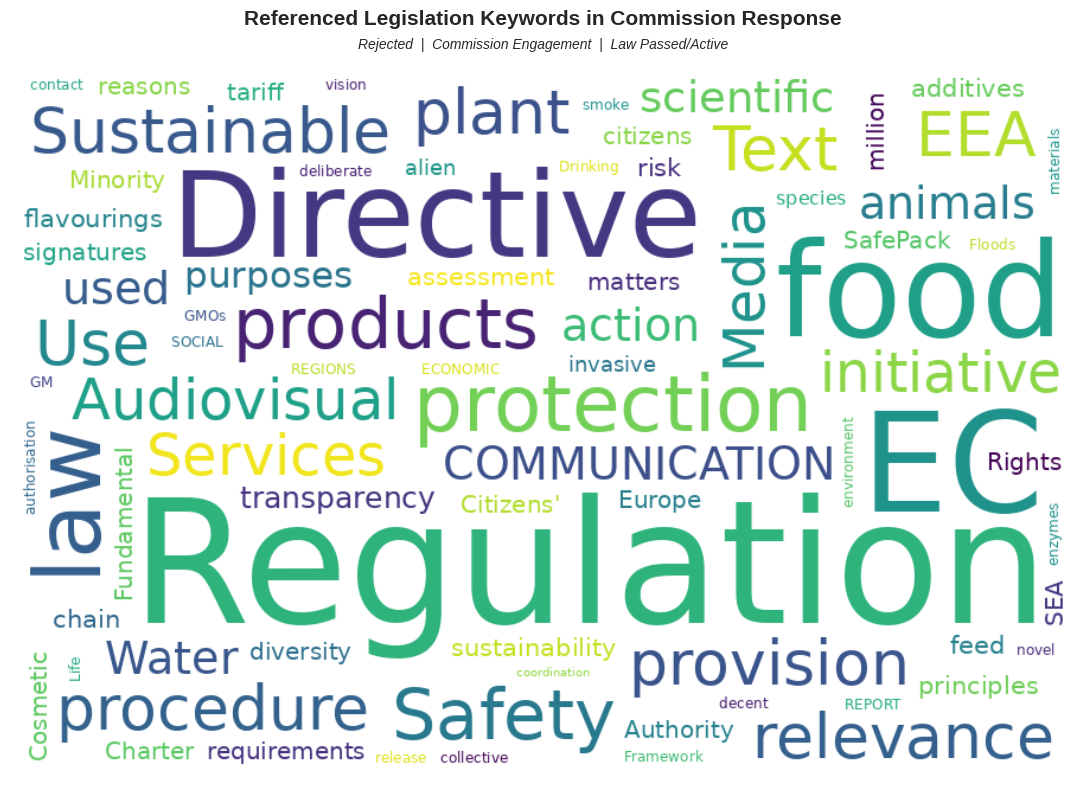

In [27]:
# ===============================================================================
# SIMPLIFIED WORD CLOUD ANALYSIS: FROM DATA TO VISUALIZATION
# ===============================================================================
# Objective: Analyze referenced legislation content in ECI outcomes
# Output: Word cloud visualization with frequency-based sizing
# ===============================================================================

# ===============================================================================
# STEP 1: LOAD DATA
# ===============================================================================

# Load legislation titles reference data
legislation_titles = pd.read_csv('legislation_titles.csv')

# ===============================================================================
# STEP 2: OUTCOME MAPPING
# ===============================================================================

def map_outcome_to_category(outcome_status):
    """
    Map final_outcome values to standardized categories.
    
    Categories:
    - Commission Engagement: Law Promised, Action Plan Created, Being Studied
    - Law Passed/Active: Law Active, Law Passed
    - Rejected: All rejection types
    """
    if pd.isna(outcome_status):
        return None
    
    outcome_str = str(outcome_status)
    
    if any(x in outcome_str for x in ['Law Promised', 'Action Plan', 'Being Studied']):
        return 'Commission Engagement'
    elif any(x in outcome_str for x in ['Law Active', 'Law Passed']):
        return 'Law Passed/Active'
    elif 'Rejected' in outcome_str:
        return 'Rejected'
    
    return None

# ===============================================================================
# STEP 3: LEGISLATION REFERENCE EXTRACTION
# ===============================================================================

def extract_legislation_ids(referenced_leg_json):
    """Extract all legislation identifiers from referenced_legislation_by_id field."""
    if pd.isna(referenced_leg_json) or referenced_leg_json == '':
        return set()
    
    ids = set()
    
    try:
        if isinstance(referenced_leg_json, str):
            leg_data = ast.literal_eval(referenced_leg_json) if referenced_leg_json.strip() else {}
        else:
            leg_data = referenced_leg_json
        
        if isinstance(leg_data, dict):
            for key, value in leg_data.items():
                if isinstance(value, list):
                    ids.update(value)
                elif isinstance(value, str):
                    ids.add(value)
        elif isinstance(leg_data, str):
            for item in leg_data.split(','):
                item = item.strip()
                if item:
                    ids.add(item)
    except (ValueError, SyntaxError):
        if isinstance(referenced_leg_json, str):
            for item in referenced_leg_json.replace('Directive', '').replace('CELEX', '').split(','):
                item = item.strip()
                if item and item not in ['', '{}', '[]']:
                    ids.add(item)
    
    return ids


def map_ids_to_titles(ids_set, legislation_df):
    """Map legislation IDs to full legislation titles."""
    titles = []
    
    for leg_id in ids_set:
        if not leg_id or leg_id.strip() == '':
            continue
        
        leg_id_clean = leg_id.strip()
        
        # Try matching by natural_number
        match = legislation_df[legislation_df['natural_number'] == leg_id_clean]
        
        # If not found, try matching by celex_id
        if match.empty:
            match = legislation_df[legislation_df['celex_id'] == leg_id_clean]
        
        # Add title if found
        if not match.empty:
            title = match.iloc[0]['title']
            titles.append(title)
    
    return titles


def extract_named_legislation(referenced_leg_names_json):
    """Extract legislation names/titles from referenced_legislation_by_name field."""
    if pd.isna(referenced_leg_names_json) or referenced_leg_names_json == '':
        return []
    
    names = []
    
    try:
        if isinstance(referenced_leg_names_json, str):
            leg_data = ast.literal_eval(referenced_leg_names_json) if referenced_leg_names_json.strip() else {}
        else:
            leg_data = referenced_leg_names_json
        
        if isinstance(leg_data, dict):
            for key, value in leg_data.items():
                if isinstance(value, list):
                    names.extend(value)
                elif isinstance(value, str) and value.strip():
                    names.append(value)
        elif isinstance(leg_data, str):
            for item in leg_data.split(','):
                item = item.strip()
                if item and item not in ['', '{}', '[]']:
                    names.append(item)
    except (ValueError, SyntaxError):
        if isinstance(referenced_leg_names_json, str):
            for item in referenced_leg_names_json.split(','):
                item = item.strip()
                if item and item not in ['', '{}', '[]', 'directives', 'regulations', 'charters']:
                    names.append(item)
    
    return names

# ===============================================================================
# STEP 4: PREPARE WORD CLOUD DATA
# ===============================================================================

def prepare_wordcloud_data(df_responses, legislation_titles):
    """
    Prepare complete dataset for word cloud visualization.
    
    Returns: DataFrame with columns:
        - legislation_title: Full title of referenced legislation
        - outcome: Standardized outcome category
        - eci_title: Title of the ECI for reference
    """
    
    wordcloud_records = []
    
    for idx, row in df_responses.iterrows():
        # Map outcome to standardized category
        outcome = map_outcome_to_category(row['final_outcome_status'])
        
        if outcome is None:
            continue
        
        eci_title = row['title']
        
        # Extract and map legislation from IDs
        leg_ids = extract_legislation_ids(row['referenced_legislation_by_id'])
        titles_from_ids = map_ids_to_titles(leg_ids, legislation_titles)
        
        # Extract named legislation
        named_legislation = extract_named_legislation(row['referenced_legislation_by_name'])
        
        # Combine all legislation references
        all_legislation = titles_from_ids + named_legislation
        
        # Create record for each unique legislation reference
        for leg_title in all_legislation:
            if leg_title and leg_title.strip():
                wordcloud_records.append({
                    'legislation_title': leg_title.strip(),
                    'outcome': outcome,
                    'eci_title': eci_title
                })
    
    # Create DataFrame
    df_wordcloud = pd.DataFrame(wordcloud_records)
    
    return df_wordcloud


# Prepare word cloud data
df_wordcloud = prepare_wordcloud_data(df_responses_enriched, legislation_titles)

# ===============================================================================
# STEP 5: FONT DETECTION
# ===============================================================================

def get_system_font():
    """Find a valid TrueType font available on the system."""
    font_paths = [
        '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf',
        '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf',
        '/usr/share/fonts/opentype/noto/NotoSans-Regular.ttf',
        '/Library/Fonts/Arial.ttf',
        'C:\\Windows\\Fonts\\arial.ttf',
    ]
    
    for font_path in font_paths:
        if Path(font_path).exists():
            return font_path
    
    try:
        fonts = fm.findSystemFonts()
        ttf_fonts = [f for f in fonts if f.endswith('.ttf')]
        if ttf_fonts:
            return ttf_fonts[0]
    except:
        pass
    
    return None

# ===============================================================================
# STEP 6: WORD CLOUD GENERATION
# ===============================================================================

def generate_wordcloud(df_wordcloud, width=900, height=600, max_words=80):
    """Generate simple word cloud from legislation titles."""
    
    # Get font
    font_path = get_system_font()
    
    # Create text from all legislation titles
    text = ' '.join(df_wordcloud['legislation_title'].tolist())
    
    # Define stopwords - common EU terms that don't provide insight
    stopwords = {
        # EU Law
        # 'Directive', 'Regulation', 'Treaty', 'Article', 'Framework',
        # EU institutional terms
        'EU', 'European', 'Council', 'Parliament', 'Commission',
        'Union', 'Member', 'States',
        'Common', 'General',
        'Committee', 'COMMITTEE',
        # Procedural terms
        'establishing', 'amending', 'laying', 'down', 'concerning',
        'relating', 'respect', 'regards', 'accordance', 'implementation',
        'Implementing', 'Proposal',
        # Common English stopwords
        'the', 'of', 'and', 'to', 'in', 'for', 'on', 'with', 'as',
        'at', 'by', 'from', 'or', 'an', 'be', 'this', 'that', 'which',
        'a', 'is', 'are', 'was', 'were', 'been', 'being', 'have', 'has',
        'had', 'do', 'does', 'did', 'will', 'would', 'should', 'could',
        'may', 'might', 'must', 'can', 'shall', 'its', 'it', 'their',
        'them', 'these', 'those', 'such', 'into', 'through', 'during',
        'before', 'after', 'above', 'below', 'between', 'under', 'again',
        'further', 'then', 'once', 'here', 'there', 'when', 'where',
        'why', 'how', 'all', 'both', 'each', 'few', 'more', 'most',
        'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own',
        'same', 'so', 'than', 'too', 'very', 'one', 'also', 'via'
        # Months
        'january', 'february', 'march', 'april', 'may', 'june', 
        'july', 'august', 'september', 'october', 'november', 'december',
        'January', 'February', 'March', 'April', 'May', 'June',
        'July', 'August', 'September', 'October', 'November', 'December'
    }
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=width,
        height=height,
        background_color='white',
        max_words=max_words,
        relative_scaling=0.5,
        min_font_size=10,
        collocations=False,
        font_path=font_path,
        colormap='viridis',
        margin=20,
        stopwords=stopwords  # Add stopwords here
    )
    
    wordcloud.generate(text)
    
    return wordcloud

# ===============================================================================
# STEP 7: VISUALIZATION
# ===============================================================================

def plot_wordcloud(wordcloud, df_wordcloud):
    """Create a simple word cloud visualization with margins."""
    
    fig, ax = plt.subplots(figsize=(16, 9))
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    
    # Main title
    ax.set_title('Referenced Legislation Keywords in Commission Response', 
                 fontsize=15, fontweight='bold', pad=30)
    
    # Subtitle with outcome breakdown
    outcome_counts = df_wordcloud['outcome'].value_counts()
    
    law_passed = outcome_counts.get('Law Passed/Active', 0)
    commission_engaged = outcome_counts.get('Commission Engagement', 0)
    rejected = outcome_counts.get('Rejected', 0)
    
    subtitle = (
                f"Rejected  |  "
                f"Commission Engagement  |  "
                f"Law Passed/Active"
    )
    
    fig.text(0.5, 0.89, subtitle, ha='center', fontsize=10, style='italic')
    #             ↑ Changed from 0.94 to 0.90 (moved down)
    
    # Add margins around the plot
    plt.subplots_adjust(left=0.05, right=0.95, top=0.87, bottom=0.08)
    #                                            ↑ Adjusted from 0.90 to 0.87
    
    return fig



# ===============================================================================
# STEP 8: STATISTICS
# ===============================================================================

def get_legislation_statistics(df_wordcloud):
    """Get detailed statistics about referenced legislation as DataFrame."""
    
    # Frequency of each legislation title
    leg_frequency = df_wordcloud['legislation_title'].value_counts()
    
    # Create list of records for top 15
    top_legislation = []
    for rank, (leg_title, count) in enumerate(leg_frequency.head(10).items(), 1):
        outcomes = df_wordcloud[df_wordcloud['legislation_title'] == leg_title]['outcome'].value_counts()
        
        top_legislation.append({
            'Legislation Title': leg_title,
            'Reference Count': count
        })
    
    # Create DataFrame
    df_stats = pd.DataFrame(top_legislation)
    
    return df_stats

# ===============================================================================
# STEP 9: EXECUTE
# ===============================================================================

# Generate word cloud
wordcloud = generate_wordcloud(df_wordcloud)

# Plot
fig = plot_wordcloud(wordcloud, df_wordcloud)
plt.show()


NOTE:
> **What types of legislation can the EU produce?:**<br>The EU has several [legal tools](https://european-union.europa.eu/institutions-law-budget/law/types-legislation_en) to implement policy changes:
> - **[Regulations:](https://european-union.europa.eu/institutions-law-budget/law/types-legislation_en)** are binding laws that apply directly to all member states without needing national approval—they become law immediately across the EU.
> - **[Directives:](https://european-union.europa.eu/institutions-law-budget/law/types-legislation_en)** set binding goals that member states must achieve, but each country decides how to implement them into national law within a set timeframe.
> - **[Decisions:](https://european-union.europa.eu/institutions-law-budget/law/types-legislation_en)** are binding acts targeting specific parties (countries, companies, or individuals).
> - **Recommendations and opinions:** are non-binding acts that provide guidance but carry no legal force.

In [28]:
# Print statistics
df_legislation_stats = get_legislation_statistics(df_wordcloud).style.hide(axis='index')
print("\n" + "=" * 80)
print("TOP 10 MOST REFERENCED LEGISLATION")
print("=" * 80)
display(df_legislation_stats)


TOP 10 MOST REFERENCED LEGISLATION


Legislation Title,Reference Count
"Regulation (EC) No 178/2002 of the European Parliament and of the Council of 28 January 2002 laying down the general principles and requirements of food law, establishing the European Food Safety Authority and laying down procedures in matters of food safety",2
SEA,2
Charter of Fundamental Rights,2
"COMMUNICATION FROM THE COMMISSION TO THE EUROPEAN PARLIAMENT, THE COUNCIL, THE EUROPEAN ECONOMIC AND SOCIAL COMMITTEE AND THE COMMITTEE OF THE REGIONS A decent Life for all: from vision to collective action",1
Audiovisual Media Services Directive,1
Invasive Alien Species Regulation,1
Commission Implementing Regulation (EU) 2025/1422 of 17 July 2025 amending Implementing Regulation (EU) 2016/1141 to update the list of invasive alien species of Union concern,1
REACH Regulation,1
EU Cosmetics Regulation,1
Cosmetic Products Regulation,1


NOTE:
> - **A Successful Example of Legislation:**  
> The **Right2Water ECI** (2012) gathered 1,659,543 signatures and led to the revision of the **Drinking Water Directive (EU) 2020/2184**, which entered into force in 2021. The directive improved water quality monitoring, mandated access for vulnerable groups, and strengthened protections against privatization. It was the first ECI to result in concrete legislative change.


[↑ Table of Contents ↑](#table-of-contents)

<a id='question-7'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">7. What are official hearings and meetings with policy-makers?</p>

After submitting a successful initiative, organizers present their case in a public European Parliament hearing and meet privately with Commission officials to explain their goals in detail, before the Commission adopts its formal legal and political response.

In [29]:
# 1. Extraction logic (from your notebook)
def extract_timeline_date(timeline_json, step_name):
    if pd.isna(timeline_json): return pd.NaT
    try:
        timeline = json.loads(timeline_json) if isinstance(timeline_json, str) else timeline_json
        for step in timeline:
            if step.get('step') == step_name:
                return pd.to_datetime(step.get('date'), dayfirst=True, errors='coerce')
        return pd.NaT
    except: return pd.NaT

# 2. Data Prep
df_plot = df_responses_enriched.copy()
df_plot['date_collection_closed'] = df_plot['timeline'].apply(lambda x: extract_timeline_date(x, 'Collection closed'))
df_plot['date_parliament_hearing'] = pd.to_datetime(df_plot['parliament_hearing_date'], errors='coerce')
df_plot['date_commission_meeting'] = pd.to_datetime(df_plot['commission_meeting_date'], errors='coerce')

df_plot['wait_hearing'] = (df_plot['date_parliament_hearing'] - df_plot['date_collection_closed']).dt.days
df_plot['wait_meeting'] = (df_plot['date_commission_meeting'] - df_plot['date_collection_closed']).dt.days

# 3. Custom Hover Logic for Binned Data
def create_binned_data(df, wait_col, event_name, bin_size=150):
    valid_df = df.dropna(subset=[wait_col, 'initiative_title']).copy()
    valid_df['bin'] = (valid_df[wait_col] // bin_size) * bin_size
    
    grouped = valid_df.groupby('bin')
    bin_data = []

    for bin_start, group in grouped:
        ecis = group['initiative_title'].tolist()
        
        # Hover string with numbered list and truncation
        hover_text = f"<b>{event_name}</b><br>Wait: {int(bin_start)}-{int(bin_start+bin_size)} days<br>Count: {len(ecis)}<br><br>"
        if ecis:
            hover_text += "<b>ECIs:</b><br>"
            for i, eci in enumerate(ecis, 1):
                eci_short = eci if len(eci) <= 60 else eci[:57] + "..."
                hover_text += f"{i}. {eci_short}<br>"
        
        bin_data.append({'bin_start': bin_start, 'count': len(ecis), 'hover': hover_text})
    
    return pd.DataFrame(bin_data)

BIN_SIZE = 150
hearing_binned = create_binned_data(df_plot, 'wait_hearing', 'Parliament Hearing', BIN_SIZE)
meeting_binned = create_binned_data(df_plot, 'wait_meeting', 'Commission Meeting', BIN_SIZE)

# 4. Visualization
fig = go.Figure()

# Commission Meeting Bars
fig.add_trace(go.Bar(
    x=meeting_binned['bin_start'],
    y=meeting_binned['count'],
    name='Commission Meeting',
    text=meeting_binned['hover'],
    hoverinfo='text',
    textposition='none', # REMOVES TEXT FROM THE BARS
    marker_color='#ff7f0e',
    opacity=0.7,
    offsetgroup=0
))

# Parliament Hearing Bars
fig.add_trace(go.Bar(
    x=hearing_binned['bin_start'],
    y=hearing_binned['count'],
    name='Parliament Hearing',
    text=hearing_binned['hover'],
    hoverinfo='text',
    textposition='none', # REMOVES TEXT FROM THE BARS
    marker_color='#1f77b4',
    opacity=0.7,
    offsetgroup=1
))

fig.update_layout(
    title="<b>Wait Time Distribution with ECI Listings</b>",
    xaxis_title=f"Days from Collection End (Bins of {BIN_SIZE} days)",
    yaxis_title="Count of ECIs",
    yaxis=dict(
        dtick=1,        # Forces ticks to appear only at every 1 unit (integers)
        tickformat='d'  # Ensures the labels are formatted as integers
    ),
    barmode='group',
    template="plotly_white",
    bargap=0.15,
    hoverlabel=dict(bgcolor="white", font_size=12)
)

fig.show()

In [30]:
# Extract 5 examples of official roles met
official_roles = df_responses_enriched[['registration_number', 'initiative_title', 'commission_officials_met']].copy()
official_roles.columns = ['Registration Number', 'ECI Name', 'Name of the Met Person']
official_roles = official_roles[official_roles['Name of the Met Person'].notna()]

print("Examples of officials met during Commission meetings:")

official_roles_examples = official_roles.sample(5)
official_roles_examples.index = range(1, len(official_roles_examples) + 1)
official_roles_examples

Examples of officials met during Commission meetings:


,Registration Number,ECI Name,Name of the Met Person
1,2012/000005,One of us,"the Commissioner responsible for Research, Innovation and Science, Ms Geoghegan-Quinn; Deputy Director-General responsible for Development and Cooperation, Mr. Cornaro"
2,2012/000007,Stop vivisection,"Vice-President Jyrki Katainen, responsible for Jobs, Growth, Investment and Competitiveness; Director-General Karl Falkenberg, responsible for DG Environment"
3,2019/000016,Save bees and farmers ! Towards a bee-friendly agriculture for a healthy environment,"Vice-President for Values and Transparency, Věra Jourová; Commissioner for Health and Food Safety, Stella Kyriakides"
4,2017/000004,Minority SafePack – one million signatures for diversity in Europe,"Vice-President for ‘Values and Transparency’, Věra Jourová; Commissioner for ‘Innovation, Research, Culture, Education and Youth’, Mariya Gabriel"
5,2020/000001,Stop Finning – Stop the trade,"Vice-President for Values and Transparency, Věra Jourová; Commissioner for Environment, Oceans and Fisheries, Virginijus Sinkevičius"


NOTE:
> - **What is the Commission meeting?:**<br>Within 1 month after submitting a successful ECI (1 million+ signatures), organizers meet privately with Commission representatives to explain the issues raised in their initiative in detail. Who shows up matters—most ECIs meet with Vice-Presidents or Commissioners, while a few meet with Directors-General or Deputy Directors-General. These meetings are private.

In [31]:
# Create dataframe with the two ECI hearing videos
data = {
    'ECI Name': [
        'Stop Finning - Stop the Trade',
        'One of Us'
    ],
    'date': [
        '2023-01-20',  # Intergroup session date
        '2014-04-10'   # Actual hearing date
    ],
    'url': [
        'https://www.youtube.com/watch?v=l8vxWe8kr0I',
        'https://www.youtube.com/watch?v=M4OP1YRzsNc'
    ],
    'outcome': [
        'Commission responded (July 2023): Updated customs code tariffs for better monitoring, but rejected trade ban and most demands',
        'Commission rejected (May 2014): Refused to propose legislation; organizers appealed to Court of Justice, which rejected the appeal'
    ]
}

df_eci_videos = pd.DataFrame(data)

# Convert date to datetime
df_eci_videos['date'] = pd.to_datetime(df_eci_videos['date'])

# Set index to start from 1
df_eci_videos.index = df_eci_videos.index + 1

# Display the dataframe
print("Examples of parliament hearings:")
df_eci_videos

Examples of parliament hearings:


,ECI Name,date,url,outcome
1,Stop Finning - Stop the Trade,2023-01-20,https://www.youtube.com/watch?v=l8vxWe8kr0I,"Commission responded (July 2023): Updated customs code tariffs for better monitoring, but rejected trade ban and most demands"
2,One of Us,2014-04-10,https://www.youtube.com/watch?v=M4OP1YRzsNc,"Commission rejected (May 2014): Refused to propose legislation; organizers appealed to Court of Justice, which rejected the appeal"


NOTE:
> - **What are Parliament hearings?:**<br>After a successful ECI is validated, the European Parliament organizes a public hearing where the Citizens' Committee presents their initiative to Members of the European Parliament (MEPs).

[↑ Table of Contents ↑](#table-of-contents)

<a id='question-8'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">8. Are other examples of actions besides the legislative ones?</p>

While the primary goal of most initiatives is the creation of new laws, the Commission often addresses citizens' concerns using tools that do not require immediate legal reform.  These alternative steps include funding scientific research, shifting budget priorities, and opening new channels for expert and public discussion.

**Commission Policy Actions:**<br>
*(These categories are analytical classifications created for this dataset and do not reflect official Commission terminology)* 

- **Policy Implementation**: Enforcing existing rules through compliance reports and monitoring their application, ensuring laws deliver intended results without requiring new legislation.<br><br> 

- **Scientific Activity**: Building the evidence base for future policy decisions by funding research, commissioning expert opinions from agencies like EFSA, and developing new testing standards.<br><br> 

- **Policy Roadmap and Strategy**: Establishing long-term policy frameworks that set the agenda for upcoming legislative proposals, defining priorities and timelines for Commission action.<br><br> 

- **Data Collection and Transparency**: Gathering evidence through stakeholder consultations and improving public access to EU data, providing the facts needed for policy decisions.<br><br> 

- **Impact Assessment and Consultation**: Testing policy options and gathering public input through EU-wide consultations to shape regulations before they're formally proposed.<br><br> 

- **Funding Programme**: Delivering concrete support through existing budgets like Horizon Europe or agricultural transition funds, supporting policy goals with existing budgets rather than new laws.<br><br> 

- **Monitoring and Enforcement**: Verifying Member State compliance with EU law and maintaining research integrity standards, ensuring regulations achieve their objectives in practice.<br><br> 

- **Stakeholder Dialogue**: Creating structured platforms for experts, organizations, and interest groups to build consensus and identify practical solutions for policy issues.<br><br> 

- **International Cooperation**: Pursuing initiative goals in international meetings and agreements with other countries, building solutions beyond just the EU.<br><br>

In [32]:
# Parse policies_actions to extract all engagement types
def extract_policy_types(policies_json):
    """Extract all policy action types from the JSON field."""
    if pd.isna(policies_json):
        return []
    
    try:
        actions = json.loads(policies_json)
        return [action.get('type', 'Unknown') for action in actions]
    except:
        return []

# Add policy types to dataframe
df_responses_enriched['policy_types'] = df_responses_enriched['policies_actions'].apply(extract_policy_types)

# Get all unique policy types across all ECIs
all_types = []
for types_list in df_responses_enriched['policy_types']:
    all_types.extend(types_list)

unique_types = list(set(all_types))

# Count ECIs with each type of engagement
engagement_stats = {}
eci_lists = {}

for policy_type in unique_types:
    # Find ECIs that have this policy type
    has_type = df_responses_enriched['policy_types'].apply(lambda x: policy_type in x)
    count = has_type.sum()
    
    # Store count and ECI list
    engagement_stats[policy_type] = count
    eci_lists[policy_type] = df_responses_enriched[has_type]['title'].tolist()

# Extract categories and counts from the dictionary
categories = list(engagement_stats.keys())
counts = list(engagement_stats.values())

# Sort by counts in descending order (highest to lowest)
sorted_indices = np.argsort(counts)[::-1]
categories = [categories[i] for i in sorted_indices]
counts = [counts[i] for i in sorted_indices]

# Format hover text with ECI lists
hover_texts = []
for category in categories:
    ecis = eci_lists[category]
    hover_text = f"<b>{category}</b><br>Count: {len(ecis)}<br><br>"
    
    if ecis:
        hover_text += "<b>ECIs:</b><br>"
        for i, eci in enumerate(ecis, 1):
            # Truncate long titles
            eci_short = eci if len(eci) <= 60 else eci[:57] + "..."
            hover_text += f"{i}. {eci_short}<br>"
    
    hover_texts.append(hover_text)

# Generate viridis colors (yellow for highest, darkest for lowest)
n_bars = len(counts)
viridis_positions = np.linspace(1.0, 0.0, n_bars)  # Highest to lowest
viridis_colors = px.colors.sample_colorscale("Viridis", viridis_positions)

# Create plotly bar plot
fig = go.Figure(data=[
    go.Bar(
        x=categories,
        y=counts,
        marker=dict(
            color=viridis_colors,
            line=dict(color='white', width=2)
        ),
        text=counts,
        textposition='outside',
        textfont=dict(size=12, color='black'),
        hovertext=hover_texts,
        hoverinfo='text'
    )
])

# Update layout
fig.update_layout(
    title=dict(
        text='<b>Commission Engagement Patterns: Policy Action Types</b>',
        x=0.5,
        xanchor='center',
        font=dict(size=18)
    ),
    xaxis=dict(
        title='<b>Policy Action Type</b>',
        gridcolor='rgba(128,128,128,0.2)',
        showgrid=True,
        tickangle=-45  # Angle labels for better readability
    ),
    yaxis=dict(
        title='<b>Number of ECIs</b>',
        gridcolor='rgba(128,128,128,0.2)',
        showgrid=True,
        range=[0, max(counts) + 1]
    ),
    height=600,
    width=1000,
    showlegend=False,
    template='plotly_white',
    plot_bgcolor='white',
    paper_bgcolor='white',
    hovermode='closest',
    margin=dict(b=150)  # Add bottom margin for angled labels
)

print("\n" + "=" * 80)
print("COMMISSION ENGAGEMENT BY POLICY ACTION TYPE")
print("=" * 80)

fig.show()



COMMISSION ENGAGEMENT BY POLICY ACTION TYPE


In [33]:
# Function to extract examples for all engagement types
def extract_all_engagement_examples(df):
    """
    Extract examples of all policy action types from policies_actions
    Returns a DataFrame with one random sample per type
    Filters out non-informative examples (references, links, etc.)
    
    Parameters:
    - df: DataFrame with policies_actions column
    """
    # Collect all examples grouped by type
    examples_by_type = {}
    
    # Patterns to filter out non-informative descriptions
    filter_phrases = [
        'see the',
        'for more information',
        'further details',
        'further information',
        'click here',
        'visit the',
        'available at',
        'can be found',
        'please refer to',
        'consult the',
        'link to'
    ]
    
    for idx, row in df.iterrows():
        if pd.notna(row['policies_actions']):
            try:
                policies = json.loads(row['policies_actions'])
                for action in policies:
                    action_type = action.get('type', 'Unknown')
                    description = action.get('description', 'N/A')
                    
                    # Filter out non-informative examples
                    description_lower = description.lower()
                    
                    # Skip if contains filter phrases
                    if any(phrase in description_lower for phrase in filter_phrases):
                        continue
                    
                    # Skip if too short (less than 50 characters)
                    if len(description) < 50:
                        continue
                    
                    # Initialize list for this type if not exists
                    if action_type not in examples_by_type:
                        examples_by_type[action_type] = []
                    
                    # Add example
                    examples_by_type[action_type].append({
                        'Engagement Type': action_type,
                        'Registration Number': row['registration_number'],
                        'ECI Name': row['title'],
                        'Description': description
                    })
            except (json.JSONDecodeError, TypeError):
                continue
    
    # Sample 1 random example from each type
    sampled_examples = []
    for action_type, examples in examples_by_type.items():
        if examples:
            # Randomly select one example
            sampled = np.random.choice(len(examples))
            sampled_examples.append(examples[sampled])
    
    return pd.DataFrame(sampled_examples)


# Extract examples
df_engagement_examples = extract_all_engagement_examples(df_responses_enriched)

# Sort by Engagement Type for consistent display
df_engagement_examples = df_engagement_examples.sort_values('Engagement Type').reset_index(drop=True)

# Set index starting from 1
df_engagement_examples.index = range(1, len(df_engagement_examples) + 1)

if not df_engagement_examples.empty:
    print("=" * 150)
    print(f"COMMISSION ENGAGEMENT EXAMPLES (1 random sample per type, {len(df_engagement_examples)} types total)")
    print("=" * 150)
    print("\n")
    
    # Display with proper column widths
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.width', None)
    
    display(df_engagement_examples)

    
    # Optional: Save to CSV
    # df_engagement_examples.to_csv('engagement_examples_all_types.csv', index=True)
    # print("\n✓ Saved to: engagement_examples_all_types.csv")
else:
    print("No engagement examples found.")


COMMISSION ENGAGEMENT EXAMPLES (1 random sample per type, 9 types total)




,Engagement Type,Registration Number,ECI Name,Description
1,Data Collection and Transparency,2017/000002,Ban glyphosate and protect people and the environment from toxic pesticides,A proposal for a Regulation of the European Parliament and the Council on the transparency and sustainability of the EU risk assessment in the food chain was adopted by the Commission on 11 April 2018 in response to the second aim of the initiative (see above).
2,Funding Programme,2021/000006,SAVE CRUELTY FREE COSMETICS - COMMIT TO A EUROPE WITHOUT ANIMAL TESTING,"Modernise science in the EU: The Commission will continue to strongly support the development of alternative approaches with appropriate funding. It will also initiate a series of actions to accelerate the reduction of animal testing in research, education and training."
3,Impact Assessment and Consultation,2012/000003,"Water and sanitation are a human right! Water is a public good, not a commodity!","launching an EU-wide public consultation on the Drinking Water Directive, notably in view of improving access to quality water in the EU;"
4,International Cooperation,2012/000003,"Water and sanitation are a human right! Water is a public good, not a commodity!",advocating universal access to safe drinking water and sanitation as a priority area for Sustainable Development Goals.
5,Monitoring and Enforcement,2017/000004,Minority SafePack – one million signatures for diversity in Europe,"As regards rules on EU funding more generally, the Commission has reinforced compliance with the fundamental rights in the EU funds. The Common Provisions Regulation (CPR) setting out rules for the 2021-2027 budget contains an ‘enabling condition’ requiring Member States to ensure compliance with the Charter of Fundamental Rights and the non-discrimination principle when disbursing EU funds covered by the CPR. These will continue to support socio-economic integration including that of marginalised communities, vulnerable groups including ethnic minorities, in line with priorities and needs identified by the Commission and the Member States."
6,Policy Implementation,2012/000007,Stop vivisection,"The Commission published a review report of the Directive 2010/63/EU in 2017. In addition, it published a report on implementation of this Directive in February 2020. These reports provided the first assessments of the extent to which the Directive is reaching its objectives and is implemented by the Member States."
7,Policy Roadmap and Strategy,2022/000002,Fur Free Europe,"The Commission conducted, in 2024, three on-site visits to Member States with mink/fur farms, exploring the controls and the One Health mechanisms in place."
8,Scientific Activity,2022/000002,Fur Free Europe,"Scientific opinion on the welfare of American mink, red and Arctic foxes, raccoon dog and chinchilla kept for fur production, 2025"
9,Stakeholder Dialogue,2012/000007,Stop vivisection,"The Commission commits to active monitoring of compliance and enforcement of the legislation, and will continue supporting the development and validation of alternative approaches to the use of animals in research and testing. Dialogue with all stakeholders will continue, especially with the scientific community, to advance towards the goal of phasing out animal testing through knowledge sharing, dissemination, and education and training activities on non-animal alternatives and the Three Rs (Replacement, Reduction and Refinement of animal use in testing)."


NOTE:
> - **The "Soft" Rejection:**<br>The European Commission often uses "soft" policy actions as substitutes when it refuses to propose a new law, even if an initiative meets the 1 million signature requirement. This occurs when the Commission acknowledges the initiative's goals but believes that current laws, combined with new non-legislative actions, are sufficient to address the problem. The good example is the [**"Stop Vivisection"**](https://ec.europa.eu/commission/presscorner/detail/en/ip_15_5094).

[↑ Table of Contents ↑](#table-of-contents)

<a id='question-9'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">9. How does the Commission set a deadline for itself?</p>

The Commission must publish a timeline when it commits to action on an ECI, showing when it expects to complete specific tasks. According to EU [rules](https://eur-lex.europa.eu/legal-content/EN/TXT/PDF/?uri=CELEX:32019R0788), these timelines are required for any promised follow-up. However, the Commission isn't required to act on any ECI, and there are no legal penalties for missing its own deadlines.


In [34]:
def robust_parse(text):
    """
    Extracts all JSON or Python-dict objects from a string with extra text.
    Handles mixed quote styles and markdown headers.
    """
    if pd.isna(text) or text == "":
        return {}
    
    all_deadlines = {}
    # Find everything between { and }
    matches = re.findall(r'\{.*?\}', text, re.DOTALL)
    
    for match in matches:
        try:
            # Attempt to parse as JSON (double quotes)
            d = json.loads(match)
            all_deadlines.update(d)
        except:
            try:
                # Fallback to Python literal (single quotes)
                d = ast.literal_eval(match)
                all_deadlines.update(d)
            except:
                continue  # Skip malformed fragments
    
    return all_deadlines

def format_hover(text, width=60):
    """Wraps tooltip text for better readability."""
    return "<br>".join(textwrap.wrap(str(text), width)) if text else ""

# 1. Load data
df = df_responses_enriched.copy()

# Ensure the baseline is a datetime object
df['timeline_response_commission_date'] = pd.to_datetime(df['timeline_response_commission_date'])

parsed_rows = []
for _, row in df.iterrows():
    deadlines = robust_parse(row['commission_deadlines'])
    base_date = row['timeline_response_commission_date']
    
    clean_title = (row['title'][:47] + '...') if len(row['title']) > 50 else row['title']
    
    # Sort by deadline date
    sorted_deadlines = sorted(deadlines.items(), key=lambda x: x[0])
    
    for i, (date_str, action) in enumerate(sorted_deadlines, 1):
        deadline_date = pd.to_datetime(date_str)
        delta_days = (deadline_date - base_date).days if pd.notna(base_date) else None
        
        # FIX: First action shows full title, subsequent show only number
        if len(sorted_deadlines) > 1:
            display_title = f"{clean_title} ({i})"
        else:
            display_title = clean_title
        
        parsed_rows.append({
            'Display Title': display_title,
            'Initiative': clean_title,
            'Base Date': base_date,
            'Deadline Date': deadline_date,
            'Days from Response': delta_days,
            'Months': round(delta_days / 30.44, 1) if delta_days is not None else "N/A",
            'Formatted Action': format_hover(action)
        })

timeline_df = pd.DataFrame(parsed_rows)

# 2. Create the horizontal span timeline
fig = px.timeline(
    timeline_df, 
    x_start="Base Date",
    x_end="Deadline Date",
    y="Display Title",
    hover_data={
        "Base Date": "|%b %d, %Y",
        "Deadline Date": "|%b %d, %Y",
        "Days from Response": True,
        "Months": True,
        "Formatted Action": True,
        "Display Title": False,
        "Initiative": True
    },
    color="Initiative",
    title="<b>Commission Commitments: Progress from Response to Deadline</b>"
)

fig.update_traces(
    hovertemplate="<b>%{customdata[3]}</b><br><br>" +
                  "<b>Commission Response:</b> %{base|%b %d, %Y}<br>" +
                  "<b>Deadline:</b> %{x|%b %d, %Y}<br>" +
                  "<b>Duration:</b> %{customdata[0]} days (%{customdata[1]} months)<br>" +
                  "<b>Action:</b> %{customdata[2]}<br>" +
                  "<extra></extra>"  # Removes secondary box
)

# 3. Final layout adjustments
fig.update_layout(showlegend=False)
fig.update_yaxes(autorange="reversed", title="")
fig.show()


NOTE:
> - **Example of a Missed Deadline:**<br>
> The **"End the Cage Age"** initiative received a Commission commitment in June 2021 to publish a legislative proposal "by the end of 2023" to phase out cages for farmed animals. However, the Commission failed to meet this deadline. By October 2023, no proposal had been published. In March 2024, the Citizens' Committee [took legal action](https://animalequality.org.uk/news/2025/03/25/in-2021-the-eu-promised-to-ban-cages-but-years-later-nothing-has-changed/) against the Commission at the Court of Justice of the European Union to demand accountability for this failure.


[↑ Table of Contents ↑](#table-of-contents)

<a id='question-9'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">10. What is the role of the Court of Justice in ECIs?</p>

The Court of Justice of the European Union (CJEU) can play a crucial, though limited, role in the European Citizens' Initiative (ECI) process. Its involvement typically arises when organizers challenge the European Commission's decisions, acting as the final arbiter on procedural fairness and legal competence.

In [35]:
def count_ecis_with_court_references(df):
    """
    Count ECIs with and without court case references.
    Does NOT apply exclude_patterns - shows all court mentions.
    """
    
    case_pattern = r'\b[CT]-\d{1,4}/\d{2,4}\b'
    
    court_keywords = [
        'Court of Justice', 'General Court', 'European Court', 'CJEU',
        'judgment', 'ruling', 'annul', 'dismiss', 'Court ruled', 
        'Court decision', 'judicial review', 'court held'
    ]
    
    ecis_with_court = {}
    ecis_without_court = {}
    
    for idx, row in df.iterrows():
        reg_num = row['registration_number']
        title = row['initiative_title']
        has_court_reference = False
        
        # Check court_cases_referenced field
        if pd.notna(row['court_cases_referenced']):
            try:
                cases_dict = json.loads(row['court_cases_referenced'])
                if cases_dict:
                    has_court_reference = True
            except:
                pass
        
        # Check commission_answer_text
        if not has_court_reference and pd.notna(row['commission_answer_text']):
            text = str(row['commission_answer_text']).lower()
            if any(kw.lower() in text for kw in court_keywords) or re.search(case_pattern, text):
                has_court_reference = True
        
        # Check followup_events_with_dates
        if not has_court_reference and pd.notna(row['followup_events_with_dates']):
            text = str(row['followup_events_with_dates']).lower()
            if any(kw.lower() in text for kw in court_keywords) or re.search(case_pattern, text):
                has_court_reference = True
        
        if has_court_reference:
            ecis_with_court[reg_num] = title
        else:
            ecis_without_court[reg_num] = title
    
    return {
        'with_court': ecis_with_court,
        'without_court': ecis_without_court,
        'with_court_count': len(ecis_with_court),
        'without_court_count': len(ecis_without_court),
        'total': len(df)
    }


# Count ECIs with/without court references
data = count_ecis_with_court_references(df_responses_enriched)

# Format ECI lists for hover text
def format_eci_list_for_hover(eci_dict, max_display=15):
    """Format ECI list with newlines for Plotly hover"""
    items = list(eci_dict.items())
    lines = []
    
    for i, (reg_num, title) in enumerate(items[:max_display]):
        lines.append(f"• {title}")
    
    if len(items) > max_display:
        lines.append(f"<i>... (and {len(items) - max_display} more)</i>")
    
    return '<br>'.join(lines)

with_court_list = format_eci_list_for_hover(data['with_court'])
without_court_list = format_eci_list_for_hover(data['without_court'])

# Adjusted viridis colors:
viridis_darker_yellow = 'rgb(202, 220, 58)'  # #cadc3a - darker yellow-green (found)
viridis_dark_blue = 'rgb(68, 1, 84)'  # Dark blue/purple (not found)

# Create pie chart
fig = go.Figure(go.Pie(
    labels=['ECIs with Court References', 'ECIs without Court References'],
    values=[data['with_court_count'], data['without_court_count']],
    hole=0.1,
    marker=dict(colors=[viridis_darker_yellow, viridis_dark_blue]),
    customdata=[with_court_list, without_court_list],
    hovertemplate=(
        '<b>%{label}</b><br>'
        'Count: %{value}<br>'
        'Percentage: %{percent}<br><br>'
        '<b>ECIs:</b><br>%{customdata}'
        '<extra></extra>'
    ),
    texttemplate='%{label}<br>%{value}<br>%{percent}',
    textposition='inside',
    insidetextorientation='horizontal', 
    textfont=dict(size=11, color='white', family='Arial Black'),
    sort=False
))

fig.update_layout(
    title=f'<b>ECIs with Court References ({data["with_court_count"]} with court, {data["without_court_count"]} without court)</b>',
    height=600,
    showlegend=True,
    legend=dict(
        font=dict(size=12),
        orientation='v',
        yanchor='middle',
        y=0.5,
        xanchor='left',
        x=1.02
    )
)

fig.show()

# Print detailed statistics
print("=" * 80)
print("COURT REFERENCE STATISTICS")
print("=" * 80)
print(f"Total ECIs analyzed: {data['total']}")
print(f"ECIs with court references: {data['with_court_count']} ({data['with_court_count']/data['total']*100:.1f}%)")
print(f"ECIs without court references: {data['without_court_count']} ({data['without_court_count']/data['total']*100:.1f}%)")

print("\n" + "=" * 80)
print(f"ECIs WITH COURT REFERENCES ({data['with_court_count']}):")
print("=" * 80)
for reg_num, title in data['with_court'].items():
    print(f"  • {reg_num}: {title}")

COURT REFERENCE STATISTICS
Total ECIs analyzed: 11
ECIs with court references: 2 (18.2%)
ECIs without court references: 9 (81.8%)

ECIs WITH COURT REFERENCES (2):
  • 2017/000004: Minority SafePack – one million signatures for diversity in Europe
  • 2021/000006: SAVE CRUELTY FREE COSMETICS - COMMIT TO A EUROPE WITHOUT ANIMAL TESTING


In [36]:
def extract_court_case_info(df):
    """
    Extracts court case mentions from ECI data with clean context from JSON 'action' fields.
    Merges rows with identical context but different case numbers.
    Also extracts case numbers from CELEX URLs (e.g., CELEX:62023CJ0026 → C-26/23)
    Filters out generic/non-informative contexts.
    
    Parameters:
    -----------
    csv_file_path : str
        Path to CSV file with ECI response data
    
    Returns:
    --------
    pd.DataFrame with columns:
        - registration_number: ECI registration number
        - initiative_title: Name of the initiative
        - case_number: Court case identifier(s) - comma-separated if multiple (e.g., "T-655/20, T-656/20")
        - context: Clean extracted text from 'action' field or commission text
        - outcome: Extracted verdict (Dismissed, Annulled, etc.)
        - source_field: Which field contained the information
        - event_dates: Associated dates (if from followup_events)
    """
    
    # Pattern for standard case numbers (T-123/45, C-123/45)
    case_pattern = r'\b[CT]-\d{1,4}/\d{2,4}\b'
    
    # Pattern for CELEX numbers: 6YYYYTJNNNNN or 6YYYYCJNNNNN
    celex_pattern = r'CELEX:6(\d{4})(TJ|CJ)(\d{4})'
    
    # Patterns to exclude - generic statements without substance
    exclude_patterns = [
        r'will carefully consider.*court.*judgment',
        r'commission will.*consider.*in view of',
        r'will.*take.*into account.*judgment',
        r'^the commission will carefully consider',
        r'is currently being assessed.*cases?.*before.*court',
        r'are currently being assessed.*court',
        r'cases?.*pending.*before.*court',
        r'interface.*being assessed.*cases?.*court',
        r'two cases.*before.*court.*without.*specifics',
        r'ongoing.*cases?.*court.*without.*detail',
    ]
    def should_exclude_context(text):
        """Check if context is too generic and should be excluded"""
        text_lower = text.lower().strip()
        
        # Exclude very short contexts
        if len(text_lower) < 50:
            return True
        
        # Check against exclude patterns
        for pattern in exclude_patterns:
            if re.search(pattern, text_lower):
                return True
        
        return False
    
    def celex_to_case_number(match):
        """Convert CELEX format to standard case format"""
        year = match.group(1)
        court_type = match.group(2)
        case_num = match.group(3)
        
        # Remove leading zeros from case number
        case_num_int = int(case_num)
        
        # Get last 2 digits of year
        year_short = year[-2:]
        
        # Determine court prefix
        prefix = 'C' if court_type == 'CJ' else 'T'
        
        return f"{prefix}-{case_num_int}/{year_short}"
    
    outcome_patterns = {
        'dismissed': 'Dismissed/Lost',
        'annul': 'Annulled/Won',
        'reject': 'Rejected/Lost',
        'uphold': 'Upheld',
        'ruled in favour': 'Favorable',
        'ruled against': 'Unfavorable',
        'clarified': 'Clarification',
        'held that': 'Court held'
    }
    
    court_keywords = [
        'Court of Justice', 'General Court', 'European Court', 'CJEU',
        'judgment', 'ruling', 'annul', 'dismiss', 'Court ruled', 
        'Court decision', 'judicial review', 'court held'
    ]
    
    results = []
    
    for idx, row in df.iterrows():
        reg_num = row['registration_number']
        title = row['initiative_title']
        
        referenced_cases = set()
        if pd.notna(row['court_cases_referenced']):
            try:
                cases_dict = json.loads(row['court_cases_referenced'])
                for court_type, case_list in cases_dict.items():
                    referenced_cases.update(case_list)
            except:
                pass
        
        # Process commission_answer_text
        if pd.notna(row['commission_answer_text']):
            text = str(row['commission_answer_text'])
            sentences = re.split(r'\.(?:\s+|$)', text)
            
            for sentence in sentences:
                sentence = sentence.strip()
                if len(sentence) < 20:
                    continue
                
                # Skip generic contexts
                if should_exclude_context(sentence):
                    continue
                
                has_court = any(kw.lower() in sentence.lower() for kw in court_keywords)
                found_cases = re.findall(case_pattern, sentence)
                
                # Also extract from CELEX URLs
                celex_matches = re.finditer(celex_pattern, sentence)
                for match in celex_matches:
                    celex_case = celex_to_case_number(match)
                    if celex_case not in found_cases:
                        found_cases.append(celex_case)
                
                if has_court or found_cases:
                    outcome = None
                    for pattern, result in outcome_patterns.items():
                        if pattern in sentence.lower():
                            outcome = result
                            break
                    
                    case_numbers = found_cases if found_cases else []
                    for ref_case in referenced_cases:
                        if ref_case in sentence and ref_case not in case_numbers:
                            case_numbers.append(ref_case)
                    
                    if not case_numbers:
                        case_numbers = ['No specific case number']
                    
                    for case_num in case_numbers:
                        results.append({
                            'registration_number': reg_num,
                            'initiative_title': title,
                            'case_number': case_num,
                            'context': sentence,
                            'outcome': outcome if outcome else 'Not specified',
                            'source_field': 'commission_answer_text',
                            'event_dates': None
                        })
        
        # Process followup_events_with_dates (JSON array)
        if pd.notna(row['followup_events_with_dates']):
            try:
                events = json.loads(row['followup_events_with_dates'])
                
                for event in events:
                    action_text = event.get('action', '')
                    event_dates = event.get('dates', [])
                    
                    if len(action_text) < 20:
                        continue
                    
                    # Skip generic contexts
                    if should_exclude_context(action_text):
                        continue
                    
                    has_court = any(kw.lower() in action_text.lower() for kw in court_keywords)
                    found_cases = re.findall(case_pattern, action_text)
                    
                    # Also extract from CELEX URLs
                    celex_matches = re.finditer(celex_pattern, action_text)
                    for match in celex_matches:
                        celex_case = celex_to_case_number(match)
                        if celex_case not in found_cases:
                            found_cases.append(celex_case)
                    
                    if has_court or found_cases:
                        outcome = None
                        for pattern, result in outcome_patterns.items():
                            if pattern in action_text.lower():
                                outcome = result
                                break
                        
                        case_numbers = found_cases if found_cases else []
                        for ref_case in referenced_cases:
                            if ref_case in action_text and ref_case not in case_numbers:
                                case_numbers.append(ref_case)
                        
                        if not case_numbers:
                            case_numbers = ['No specific case number']
                        
                        for case_num in case_numbers:
                            results.append({
                                'registration_number': reg_num,
                                'initiative_title': title,
                                'case_number': case_num,
                                'context': action_text,
                                'outcome': outcome if outcome else 'Not specified',
                                'source_field': 'followup_events_with_dates',
                                'event_dates': ', '.join(event_dates) if event_dates else None
                            })
            except json.JSONDecodeError:
                pass
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Merge rows with identical context but different case numbers
    if len(results_df) > 0:
        # Group by all columns except case_number
        grouping_cols = ['registration_number', 'initiative_title', 'context', 
                        'outcome', 'source_field', 'event_dates']
        
        # Aggregate case_number by joining with ", "
        merged_df = results_df.groupby(grouping_cols, dropna=False).agg({
            'case_number': lambda x: ', '.join(sorted(set(x)))
        }).reset_index()
        
        # Reorder columns
        merged_df = merged_df[['registration_number', 'initiative_title', 'case_number', 
                               'context', 'outcome', 'event_dates']]
        
        # Add helper columns for sorting
        merged_df['case_count'] = merged_df['case_number'].apply(
            lambda x: len(x.split(', ')) if pd.notna(x) else 0
        )
        
        # Convert event_dates to datetime for sorting (take latest date if multiple)
        def get_latest_date(date_str):
            if pd.isna(date_str) or date_str is None or str(date_str) == 'None':
                return pd.NaT
            dates = str(date_str).split(', ')
            parsed_dates = [pd.to_datetime(d, errors='coerce') for d in dates]
            valid_dates = [d for d in parsed_dates if pd.notna(d)]
            return max(valid_dates) if valid_dates else pd.NaT
        
        merged_df['latest_date'] = merged_df['event_dates'].apply(get_latest_date)
        
        # Sort by: case_count (desc), registration_number (asc), latest_date (desc)
        merged_df = merged_df.sort_values(
            by=['case_count', 'registration_number', 'latest_date'],
            ascending=[False, True, False]
        )
        
        # Drop helper columns
        merged_df = merged_df.drop(columns=['case_count', 'latest_date'])
        
        # Reset index
        merged_df = merged_df.reset_index(drop=True)
        
        return merged_df
    
    return results_df

result = extract_court_case_info(df_responses_enriched)

def count_unique_cases(df):
    """
    Count unique case numbers from a DataFrame with potentially comma-separated case numbers.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with a 'case_number' column containing case identifiers
    
    Returns:
    --------
    int
        Number of unique case numbers (excluding "No specific case number")
    """
    unique_cases = set()
    for case_str in df['case_number'].dropna():
        cases = [c.strip() for c in str(case_str).split(',')]
        unique_cases.update(cases)
    
    # Exclude "No specific case number" from count
    unique_cases.discard('No specific case number')
    
    return len(unique_cases)


# Usage:
number_of_cases = count_unique_cases(result)
print("=" * 80)
print(f"Court of Justice cases found in responses (first 3 of {number_of_cases}):")
print("=" * 80)
result.head(3)

Court of Justice cases found in responses (first 3 of 4):


,registration_number,initiative_title,case_number,context,outcome,event_dates
0,2021/000006,SAVE CRUELTY FREE COSMETICS - COMMIT TO A EUROPE WITHOUT ANIMAL TESTING,"T-655/20, T-656/20",Judgments of the General Court on the relationship between REACH and the Cosmetic Products Regulation ( [T-655/20](https://curia.europa.eu/juris/document/document.jsf?text=&docid=279983&pageIndex=0&doclang=en&mode=req&dir=&occ=first&part=1&cid=1997743) and [T-656/20](https://curia.europa.eu/juris/document/document.jsf?text=&docid=279984&pageIndex=0&doclang=EN&mode=lst&dir=&occ=first&part=1&cid=4301162) ),Not specified,NaN
1,2017/000004,Minority SafePack – one million signatures for diversity in Europe,C-26/23,The organisers filed an appeal against this judgment with the Court of Justice on 21 January 2023. The appeal was dismissed by the [Court judgment](https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=CELEX:62023CJ0026) of 5 June 2025.,Dismissed/Lost,"2023-01-21, 2025-06-05"
2,2017/000004,Minority SafePack – one million signatures for diversity in Europe,T-158/21,"In a [judgement](https://curia.europa.eu/jcms/upload/docs/application/pdf/2022-11/cp220179en.pdf) of 9 November 2022 (case T-158/21), the General Court of the Court of Justice of the European Union dismissed the request of the organisers' group of 'Minority SafePack' to annul the Commission Communication C(2021) 171. The court held that the Commission has not erred in law nor infringed its obligations to state sufficient reasons in its communication, in which the Commission stated that no further legislation was necessary at this stage to achieve the objectives sought by the ECI.",Dismissed/Lost,2022-11-09


NOTE:

> **What Can Be Challenged in Court?:**
>
>  **1. Refusal to Register an ECI**: ✅ *Often Successful*
> 
> When the Commission refuses to register a proposed initiative (claiming it falls outside EU competence), organizers can challenge this decision. **Courts frequently side with organizers**, forcing the Commission to reconsider or directly annulling the refusal.
> 
> - Example: *Minority SafePack* ([Case T-646/13](https://curia.europa.eu/juris/liste.jsf?language=en&num=t-646%2F13)) **won** its registration challenge in 2017.
>
> **2. Refusal to Propose Legislation After Success**: ❌ *Rarely Successful*
> 
> When an ECI successfully collects 1 million signatures but the Commission decides not to propose any legislation, organizers can sue for "failure to act." However, **courts consistently rule that the Commission has broad discretionary power** and is not legally obliged to propose laws, even for successful initiatives.
> 
> - Example: *One of Us* ([Case T-561/14](https://curia.europa.eu/juris/documents.jsf?num=T-561%2F14)) collected 1.9 million signatures but **lost** at both the General Court (2018) and Court of Justice (2019).
>
> **3. Missed Deadlines for Promised Action**: ❔ *Untested Territory*
> 
> If the Commission makes a specific commitment with a deadline but fails to deliver, organizers may have grounds to sue for accountability. This is relatively new legal ground *(the reason why it is still not found in the response)*.
> 
> - Example: *End the Cage Age* [filed a case in March 2024](https://animalequality.org.uk/news/2025/03/25/in-2021-the-eu-promised-to-ban-cages-but-years-later-nothing-has-changed/) after the Commission missed its promised "end of 2023" deadline. The outcome is **pending**.
>
> **Key Takeaway:** The Courts protect citizens' right to be heard (registration), but not their right to be obeyed (legislation).


[↑ Table of Contents ↑](#table-of-contents)

<a id='question-1'></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">11. Key Findings</p>

Putting it all together

In [37]:

# ═══════════════════════════════════════════════════════════════════
# 11. KEY FINDINGS
# ═══════════════════════════════════════════════════════════════════

# ───────────────────────────────────────────────────────────────────
# COMMISSION RESPONSE LANDSCAPE
# ───────────────────────────────────────────────────────────────────

print("=" * 80)
print("COMMISSION RESPONSE LANDSCAPE")
print("=" * 80)

landscape_df = pd.DataFrame({
    'Metric': [
        'Total ECIs analyzed',
        'ECIs with Commission responses',
        'ECIs awaiting response',
        'Time period covered'
    ],
    'Value': [
        len(df_initiatives[df_initiatives['success_collection'] == True]),
        len(df_responses_enriched),
        get_waiting_for_response_ecis(df_initiatives, df_responses_enriched)['count'],
        f"{df_initiatives['timeline_registered'].min().year:.0f} - {df_initiatives['timeline_registered'].max().year:.0f}"
    ]
})

display(landscape_df.style.hide(axis="index"))


# ───────────────────────────────────────────────────────────────────
# COMMISSION OUTCOME DISTRIBUTION
# ───────────────────────────────────────────────────────────────────

print()
print("=" * 80)
print("COMMISSION OUTCOME DISTRIBUTION")
print("=" * 80)

# Define custom ranking order (High priority -> Low priority -> Negative)
OUTCOME_RANKING = {
    'Law Active': 8,
    'Law Passed': 7,
    'Law Promised': 6,
    'Action Plan Created': 5,
    'Being Studied': 4,
    'Awaiting Commission Response': 3,
    'Rejected - Alternative Actions': 2,
    'Rejected - Already Covered': 1,
    'Rejected': 0 # Fallback for generic rejections
}

# 1. Get counts of existing responses
outcome_dist = df_responses_enriched['final_outcome_status'].value_counts().reset_index()
outcome_dist.columns = ['Outcome', 'Count']

# 2. Add 'Awaiting Response' count
waiting_count = get_waiting_for_response_ecis(df_initiatives, df_responses_enriched)['count']
if waiting_count > 0:
    waiting_row = pd.DataFrame({'Outcome': ['Awaiting Commission Response'], 'Count': [waiting_count]})
    outcome_dist = pd.concat([outcome_dist, waiting_row], ignore_index=True)

# 3. Calculate percentages based on the TOTAL
outcome_dist['Percentage'] = (outcome_dist['Count'] / outcome_dist['Count'].sum() * 100).round(1)

# 4. Apply Custom Sorting
# Create a temporary rank column. Map unknown outcomes to -1 so they appear last.
outcome_dist['Rank'] = outcome_dist['Outcome'].map(OUTCOME_RANKING).fillna(-1)

# Sort by Rank (descending) and drop the helper column
outcome_dist = outcome_dist.sort_values('Rank', ascending=False).drop(columns=['Rank'])

display(outcome_dist.style.hide(axis="index").format({'Percentage': '{:.1f}%'}))

# Categorize outcomes (Stats relative to processed responses)
legislative_success = df_responses_enriched['final_outcome_status'].isin(['Law Active', 'Law Passed']).sum()
legislative_promised = df_responses_enriched['final_outcome_status'].isin(['Law Promised', 'Action Plan Created', 'Being Studied']).sum()
rejected = df_responses_enriched['final_outcome_status'].str.contains('Rejected', na=False).sum()

print(f"\nLegislative Success (Law Active/Passed): {legislative_success}/{len(df_responses_enriched)} ({legislative_success/len(df_responses_enriched)*100:.1f}%)")
print(f"Commitments (Promised/Planned): {legislative_promised}/{len(df_responses_enriched)} ({legislative_promised/len(df_responses_enriched)*100:.1f}%)")
print(f"Rejected: {rejected}/{len(df_responses_enriched)} ({rejected/len(df_responses_enriched)*100:.1f}%)")

# ───────────────────────────────────────────────────────────────────
# EXAMPLES OF OUTCOMES
# ───────────────────────────────────────────────────────────────────

print()
print("=" * 80)
print("EXAMPLES OF OUTCOMES")
print("=" * 80)

def get_outcome_year(row):
    """
    Determines the relevant 'Outcome Year'.
    - For Active/Passed Laws: Finds the EARLIEST year a law became active or was adopted.
    - For Others: Defaults to the Commission Response year.
    """

    # Parse the baseline Commission response date
    default_date = pd.to_datetime(row['official_communication_adoption_date'], errors='coerce')
    year = default_date.year if pd.notna(default_date) else float('nan')
    
    # If the ECI resulted in a law, check the detailed actions log for the actual implementation date
    if row['final_outcome_status'] in ['Law Active', 'Law Passed'] and pd.notna(row['laws_actions']):
        
        actions = json.loads(row['laws_actions'])
        
        valid_dates = []
        target_statuses = ['law_active', 'adopted', 'law_entered_into_force']
        
        for action in actions:
            # Check if the action status confirms the law was adopted or activated
            if action['status'] in target_statuses:
                # Extract the date for this specific action
                dt = pd.to_datetime(action['date'], errors='coerce')
                
                if pd.notna(dt):
                    valid_dates.append(dt)
        
        # Use the earliest date found (e.g., adoption date often precedes entry into force)
        if valid_dates:
            return min(valid_dates).year
            
    return year

# Create samples dataframe
samples_active = df_responses_enriched[df_responses_enriched['final_outcome_status'] == 'Law Active'].head(3).copy()
samples_rejected = df_responses_enriched[df_responses_enriched['final_outcome_status'].str.contains('Rejected', na=False)].head(3).copy()
samples_df = pd.concat([samples_active, samples_rejected])

# Apply the custom year logic
samples_df['Outcome Year'] = samples_df.apply(get_outcome_year, axis=1).astype('Int64')

# Select and rename columns for display
display_df = samples_df[['title', 'final_outcome_status', 'Outcome Year']].copy()
display_df.columns = ['ECI Title', 'Outcome Status', 'Outcome Year']

display(display_df.style.hide(axis="index"))

# ───────────────────────────────────────────────────────────────────
# TIME TO RESPONSE
# ───────────────────────────────────────────────────────────────────

print()
print("=" * 80)
print("TIME TO RESPONSE (End of Collection → Official Answer)")
print("=" * 80)

# Response time from collection end to Commission response
response_times = df_responses_enriched[df_responses_enriched['timeline_collection_closed'].notna()].copy()
response_times['response_days'] = (
    pd.to_datetime(response_times['official_communication_adoption_date'], errors='coerce') - 
    response_times['timeline_collection_closed']
).dt.days

time_stats = pd.DataFrame({
    'Metric': [
        'Median days to respond',
        'Mean days to respond',
        'Fastest response (days)',
        'Slowest response (days)',
        'Median years to respond'
    ],
    'Value': [
        f"{response_times['response_days'].median():.0f}",
        f"{response_times['response_days'].mean():.0f}",
        f"{response_times['response_days'].min():.0f}",
        f"{response_times['response_days'].max():.0f}",
        f"{response_times['response_days'].median()/365:.1f}"
    ]
})

display(time_stats.style.hide(axis="index"))

print("\nContext regarding the duration:")
print("- This metric measures the full waiting time from 'Collection Closed' to 'Official Response'.")
print("- It reflects the 'Real World' waiting time for citizens, which includes:")
print("  1. National Verification (~3-6 months): Member states must verify signatures.")
print("  2. Submission Lag (Variable): Organizers choose when to officially submit.")
print("  3. Commission Examination (6 months): The specific legal deadline for the official answer.")

# ───────────────────────────────────────────────────────────────────
# INSTITUTIONAL ENGAGEMENT
# ───────────────────────────────────────────────────────────────────

print()
print("=" * 80)
print("INSTITUTIONAL ENGAGEMENT")
print("=" * 80)

engagement_df = pd.DataFrame({
    'Engagement Type': [
        'Parliament hearings held',
        'Commission meetings held',
        'ECIs with both hearing and meeting'
    ],
    'Count': [
        df_responses_enriched['parliament_hearing_date'].notna().sum(),
        df_responses_enriched['commission_meeting_date'].notna().sum(),
        (df_responses_enriched['parliament_hearing_date'].notna() & df_responses_enriched['commission_meeting_date'].notna()).sum()
    ]
})

engagement_df['Percentage'] = (engagement_df['Count'] / len(df_responses_enriched) * 100).round(1).astype(str) + '%'

display(landscape_df.style.hide(axis="index"))


# ───────────────────────────────────────────────────────────────────
# COMMISSION POLICY ACTIONS
# ───────────────────────────────────────────────────────────────────

print()
print("=" * 80)
print("COMMISSION POLICY ACTIONS (NON-LEGISLATIVE)")
print("=" * 80)

# Parse policy actions
def extract_policy_types(policies_json):
    if pd.isna(policies_json):
        return []
    try:
        actions = json.loads(policies_json)
        return [action.get('type', 'Unknown') for action in actions]
    except:
        return []

df_responses_enriched_temp = df_responses_enriched.copy()
df_responses_enriched_temp['policy_types'] = df_responses_enriched_temp['policies_actions'].apply(extract_policy_types)

# Get all unique policy types
all_types = []
for types_list in df_responses_enriched_temp['policy_types']:
    all_types.extend(types_list)

unique_types = list(set(all_types))

# Count ECIs with each type
engagement_stats = {}
for policy_type in unique_types:
    has_type = df_responses_enriched_temp['policy_types'].apply(lambda x: policy_type in x)
    count = has_type.sum()
    engagement_stats[policy_type] = count

# Sort and display top 10
top_policies = sorted(engagement_stats.items(), key=lambda x: x[1], reverse=True)[:10]

policy_action_df = pd.DataFrame(top_policies, columns=['Policy Action Type', 'Number of ECIs'])

display(policy_action_df.style.hide(axis="index"))

print("\nNote: ECIs often receive multiple types of policy actions beyond legislative proposals.")
print("Disclaimer: The categories above are analytical labels describing *methods of implementation*.")
print("            They are not official EU legal instruments (like Regulations or Directives),")
print("            but rather describe soft power tools and administrative actions used by the Commission.")


# ───────────────────────────────────────────────────────────────────
# COURT INVOLVEMENT
# ───────────────────────────────────────────────────────────────────

print()
print("=" * 80)
print("COURT INVOLVEMENT")
print("=" * 80)

# Check for court references
court_keywords = ['Court of Justice', 'General Court', 'CJEU', 'judgment', 'ruling']

def has_court_reference(row):
    has_court = False

    # Check court_cases_referenced
    if pd.notna(row.get('court_cases_referenced')):
        has_court = True

    # Check commission_answer_text
    if not has_court and pd.notna(row.get('commission_answer_text')):
        text = str(row['commission_answer_text']).lower()
        if any(kw.lower() in text for kw in court_keywords):
            has_court = True

    return has_court

court_involved = df_responses_enriched.apply(has_court_reference, axis=1).sum()

court_df = pd.DataFrame({
    'Category': [
        'ECIs with court references',
        'ECIs without court involvement'
    ],
    'Count': [
        court_involved,
        len(df_responses_enriched) - court_involved
    ],
    'Percentage': [
        f"{court_involved/len(df_responses_enriched)*100:.1f}%",
        f"{(len(df_responses_enriched) - court_involved)/len(df_responses_enriched)*100:.1f}%"
    ]
})

display(court_df.style.hide(axis="index"))

print("\nNote: Court involvement typically relates to challenges of Commission decisions,")
print("      such as refusals to register an initiative (admissibility) or refusals to propose legislation.")


# ───────────────────────────────────────────────────────────────────
# SUCCESS BY OUTCOME TYPE
# ───────────────────────────────────────────────────────────────────

print()
print("=" * 80)
print("SUCCESS PATTERNS")
print("=" * 80)

# Compare signatures between outcome types
outcome_comparison = df_responses_enriched.groupby('final_outcome_status').agg({
    'signatures_numeric': ['count', 'mean', 'median']
}).round(0)

outcome_comparison.columns = ['Count', 'Avg Signatures', 'Median Signatures']
outcome_comparison = outcome_comparison.reset_index()
outcome_comparison.columns = ['Outcome', 'Count', 'Avg Signatures', 'Median Signatures']

print("\nSignatures by Outcome Type:")
display(outcome_comparison.style.hide(axis="index").format({
    'Avg Signatures': '{:,.0f}',
    'Median Signatures': '{:,.0f}'
}))

print("\nKey Finding: Number of signatures does NOT predict legislative success.")
print("The ECI with most signatures was rejected, while some with fewer signatures succeeded.")

COMMISSION RESPONSE LANDSCAPE


Metric,Value
Total ECIs analyzed,16
ECIs with Commission responses,11
ECIs awaiting response,5
Time period covered,2012 - 2026



COMMISSION OUTCOME DISTRIBUTION


Outcome,Count,Percentage
Law Active,4,25.0%
Law Passed,1,6.2%
Law Promised,1,6.2%
Action Plan Created,1,6.2%
Awaiting Commission Response,5,31.2%
Rejected - Alternative Actions,1,6.2%
Rejected - Already Covered,3,18.8%



Legislative Success (Law Active/Passed): 5/11 (45.5%)
Commitments (Promised/Planned): 2/11 (18.2%)
Rejected: 4/11 (36.4%)

EXAMPLES OF OUTCOMES


ECI Title,Outcome Status,Outcome Year
"Water and sanitation are a human right! Water is a public good, not a commodity!",Law Active,2023
Ban glyphosate and protect people and the environment from toxic pesticides,Law Active,2018
Save bees and farmers ! Towards a bee-friendly agriculture for a healthy environment,Law Active,2024
One of us,Rejected - Already Covered,2014
Stop vivisection,Rejected - Alternative Actions,2015
Minority SafePack – one million signatures for diversity in Europe,Rejected - Already Covered,2021



TIME TO RESPONSE (End of Collection → Official Answer)


Metric,Value
Median days to respond,520
Mean days to respond,548
Fastest response (days),138
Slowest response (days),1580
Median years to respond,1.4



Context regarding the duration:
- This metric measures the full waiting time from 'Collection Closed' to 'Official Response'.
- It reflects the 'Real World' waiting time for citizens, which includes:
  1. National Verification (~3-6 months): Member states must verify signatures.
  2. Submission Lag (Variable): Organizers choose when to officially submit.
  3. Commission Examination (6 months): The specific legal deadline for the official answer.

INSTITUTIONAL ENGAGEMENT


Metric,Value
Total ECIs analyzed,16
ECIs with Commission responses,11
ECIs awaiting response,5
Time period covered,2012 - 2026



COMMISSION POLICY ACTIONS (NON-LEGISLATIVE)


Policy Action Type,Number of ECIs
Policy Implementation,9
Scientific Activity,7
Policy Roadmap and Strategy,5
Impact Assessment and Consultation,4
Funding Programme,4
Monitoring and Enforcement,3
Data Collection and Transparency,3
Stakeholder Dialogue,1
International Cooperation,1



Note: ECIs often receive multiple types of policy actions beyond legislative proposals.
Disclaimer: The categories above are analytical labels describing *methods of implementation*.
            They are not official EU legal instruments (like Regulations or Directives),
            but rather describe soft power tools and administrative actions used by the Commission.

COURT INVOLVEMENT


Category,Count,Percentage
ECIs with court references,2,18.2%
ECIs without court involvement,9,81.8%



Note: Court involvement typically relates to challenges of Commission decisions,
      such as refusals to register an initiative (admissibility) or refusals to propose legislation.

SUCCESS PATTERNS

Signatures by Outcome Type:


Outcome,Count,Avg Signatures,Median Signatures
Action Plan Created,1,"1,217,916","1,217,916"
Law Active,4,"1,226,344","1,095,430"
Law Passed,1,"1,502,319","1,502,319"
Law Promised,1,"1,397,113","1,397,113"
Rejected - Already Covered,3,"1,371,466","1,269,351"
Rejected - Alternative Actions,1,"1,173,130","1,173,130"



Key Finding: Number of signatures does NOT predict legislative success.
The ECI with most signatures was rejected, while some with fewer signatures succeeded.


FINAL NOTE:<br>
> The European Citizens' Initiative works mainly as a way for people to suggest topics for discussion, rather than a way to make laws directly, since the European Commission has the final say on what happens. Even though groups have to collect one million signatures from seven different countries, looking at the current cases that made it this far shows that hitting this goal doesn't mean their specific ideas will become law. 
> 
> The results are very different for each one—some become active laws, like quite successful the ["Right to Water" initiative](https://citizens-initiative.europa.eu/initiatives/details/2012/000003/water-and-sanitation-are-human-right-water-public-good-not-commodity_en), while others like the ["Cohesion policy for the equality of the regions"](https://citizens-initiative.europa.eu/initiatives/details/2019/000003/cohesion-policy-equality-regions-and-sustainability-regional-cultures_en) initiative faced huge bureaucratic roadblocks despite support from the European Parliament. Even getting permission to *start* collecting signatures can be inconsistent: the Commission blocked or fought against registering politically difficult topics like ["Stop TTIP"](https://eulawanalysis.blogspot.com/2017/05/new-developments-in-context-of-european.html) or ["Minority SafePack"](https://citizens-initiative.europa.eu/initiatives/details/2017/000004_en) while easily accepting the ["European Day of Whatever It Takes"](https://citizens-initiative.europa.eu/initiatives/details/2022/000010_en) pledge *(though it fell short of the one-million-signature threshold)*. Basically, the ECI is a formal way for citizens to ask the EU to take action, but whether a law actually gets passed depends entirely on the Commission's decision. While this system created an important way for people to participate in government starting in 2012, the facts show that it acts more like a request for help than a direct command.
> 
> For the organizers trying to make this happen, the data proves that having a good cause isn't enough—they need the right practical tools to survive the process. Success usually requires money and strong organization, but the hardest work actually begins *after* the campaign is over. To turn a signature count into a law, organizers must treat the Commission’s response not as a final verdict but as a narrow legislative path where they have little legal leverage. While teams can try to [suggest explicit legal changes](https://citizens-initiative-forum.europa.eu/document/how-draft-initiative-legal-requirements-and-practical-advice_en#:~:text=Examples%20of%20how%20other%20ECIs%20have%20crafted%20their%20objectives) or [engineer a Parliament resolution](https://www.europarl.europa.eu/news/en/press-room/20201211IPR93639/minority-safepack-parliament-supports-proposals-for-diversity-across-eu) to keep the pressure on, the Commission retains the power to simply [say "no"](https://citizens-initiative.europa.eu/initiatives/details/2012/000005/one-us_en) or offer a [diluted compromise](https://www.pan-europe.info/press-releases/2017/12/commission-rejects-demands-stopglyphosate-citizens%E2%80%99-initiative)—cherry-picking specific demands while rejecting others.
> 
> The "Ban Glyphosate" initiative illustrates this perfectly: while the Commission declined to implement a ban, it conceded on the demand for [scientific transparency](https://citizens-initiative.europa.eu/initiatives/details/2017/000002/ban-glyphosate-and-protect-people-and-environment-toxic-pesticides_en), adopting a new regulation [(EU) 2019/1381](https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=CELEX%3A32019R1381) to open up industry studies to scrutiny. This maneuver allowed the Commission to claim a legislative "success" while ignoring the primary goal, forcing organizers into a long-term war of attrition. Instead of dissolving, the coalition pivoted to a "trench warfare" strategy: they used the new transparency rules to scrutinize scientific data for [future lawsuits](https://www.pan-europe.info/great-glyphosate-court-case), [lobbied individual member states](https://www.pan-europe.info/resources/reports/2024/06/banning-glyphosate-based-herbicide-national-level) for national bans, and even launched a [successor ECI](https://www.pan-europe.info/press-releases/2021/09/save-bees-and-farmers-european-citizens-initiative-citizens-demand-end) ("Save Bees and Farmers") to keep the political pressure alive for years after the official response.
> 
> To be fair, the Commission's reluctance isn't purely obstructionist—it reflects the reality of the EU's legislative machinery. The Commission can only *propose* laws; it cannot force them through. Every proposal must survive the [ordinary legislative procedure](https://www.europarl.europa.eu/infographic/legislative-procedure/index_en.html), facing potential amendments or vetoes from both the European Parliament and the Council of the EU, where national interests often clash. Consequently, the Commission often filters ECI demands through the pragmatic lens of *"what can realistically pass"* rather than purely on public popularity. If a proposal is likely to be killed by member states in the Council regardless of its merit, the Commission may choose not to advance it at all, leading to the frustrating ["successful but failed"](https://thegoodlobby.eu/when-failure-succeeds-and-success-fails-a-reality-check-on-the-european-citizens-initiative/) outcome where citizens' demands hit a wall of institutional feasibility.

[↑ Table of Contents ↑](#table-of-contents)

<a id="contact"></a>
## <p style="padding:10px;background-color:#fff798;margin:0;color:#435672;font-family:newtimesroman;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">✉️ Contact</p>

<b>Karol Łukaszczy:</b><br>
- Via e-mail: **karol.lukaszczyk.contact@proton.me**<br>
- Explore Github: **https://github.com/Luk-kar**